# Stock Price Forecasting

Conventional time series forecasting models have been widely used to construct predictions, such as the ARIMA models. Nevertheless, such models can perform quite poorly on financial data since financial markets are regarded as non-linear dynamic systems.

So, we introduce recurrent neural networks (RNNs) that can learn complex dimensionality of the financial time series, which is essential to improving prediction performance.

However, neural networks have a problem choosing parameters for the model, and solely the user's experience mostly determines them. To cope with this problem, metaheuristic optimization is considered such as particle swarm optimization, genetic algorithm, and so forth.

The purpose of this notebook is to construct GA-optimized RNNs, namely LSTM.

In addition, we want to test whether technical indicators are helpful for financial time series forecasting as additional features, as a RNN architecture allows us to use a multivariate time series.

## Getting Started

In [ ]:
!git clone https://github.com/DINESHKUMAR-05/Algorithmic-Trading-using-Meta-Heuristics.git

Cloning into 'Algorithmic-Trading-using-Meta-Heuristics'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 223 (delta 33), reused 0 (delta 0), pack-reused 149
Receiving objects: 100% (223/223), 6.53 MiB | 27.41 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [ ]:
import sys
sys.path.append('Algorithmic-Trading-using-Meta-Heuristics/')

In [ ]:
!cd /content/Algorithmic-Trading-using-Meta-Heuristics

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans",
    "font.sans-serif": ["Benton Sans"]})

rcParams['figure.figsize'] = 10, 8

theme_bw = 'Algorithmic-Trading-using-Meta-Heuristics/theme_bw.mplstyle'
plt.style.use(theme_bw)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
from src.genetic_algorithm import *

import pandas as pd

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
print(device)

cuda


Load the data.

In [ ]:
!pip install yfinance

In [ ]:
import datetime as dt

# Use https://github.com/pydata/pandas-datareader/issues/868 to overcome the issue with pandas_datareader
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

The Standard and Poor's 500, or simply the S\&P 500, index is considered to compare the ARIMA as a benchmark model with metaheuristically optimized RNNs.

In [ ]:
ticker = "SPY"
df = pdr.get_data_yahoo(ticker, dt.datetime(2000, 1,1,1), dt.datetime(2021, 1,1))

[*********************100%%**********************]  1 of 1 completed


Let us look at the time series.

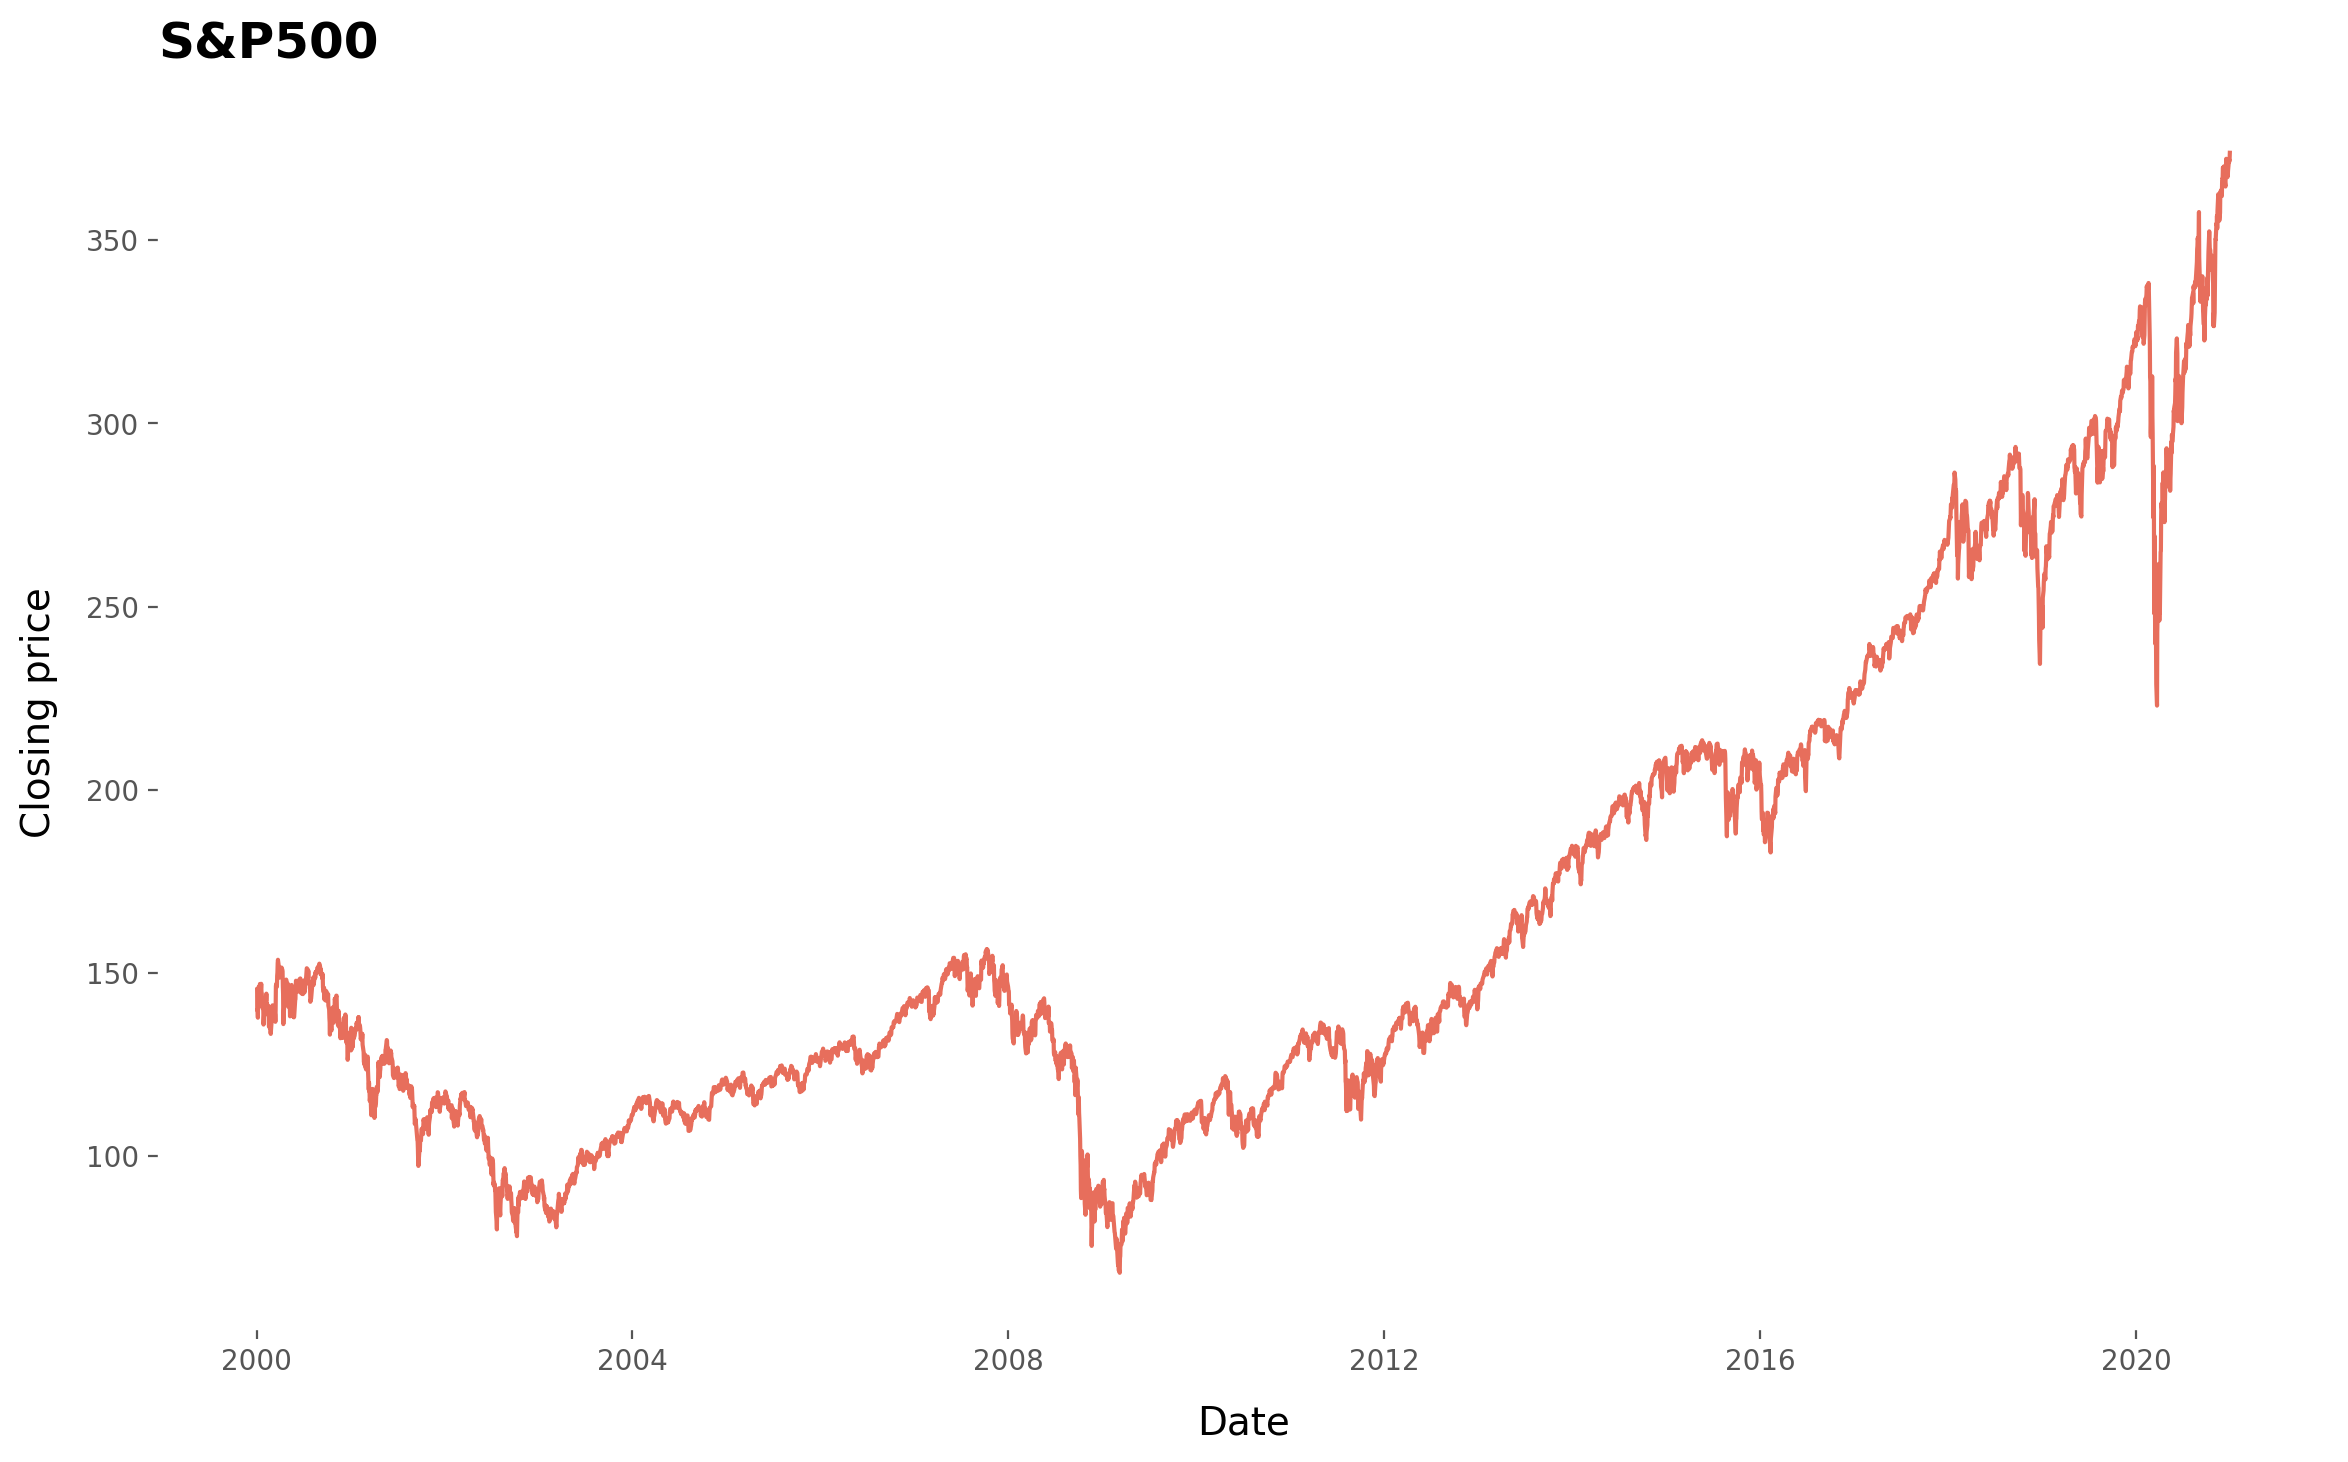

In [ ]:

plt.figure(figsize=(14, 8))
plt.title('S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')
plt.plot(df.index, df['Close'], alpha=0.8)
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14)
plt.grid(False);

In [ ]:
del df['Adj Close']

The research data for the index forecasting comes from 1 January 2000 to 1 January 2021 and is obtained from Yahoo Finance. Thus, an entire dataset has 5284 samples, or trading dates, in the form of daily closing prices. For the ARIMA model, we purely divide the dataset into training (90\%) and test (10\%) sets, while for globally optimized RNNs, we also separate the validation set (25\%) from the training set in order to correctly choose the hyperparameters $\Theta_{\text{RNN}}$.


In [ ]:
train_size = round(0.9 * df.shape[0])
test_size = df.shape[0] - train_size
val_size = round(0.25 * train_size)
train_size = train_size - val_size

In [ ]:
y_train = df['Close'][:val_size + train_size - 1]
y_test = df['Close'][val_size + train_size - 1:]

Several objective functions to measure forecast accuracy are used in the notebook, namely

$$\begin{equation*}
\begin{aligned}
\text{RMSE}(\hat y, X) = & \ \sqrt{\frac{1}{T}\sum\limits _{t=1}^{T}( y_{t} -\hat{y}( x_{t} ; w))^{2}} \\
\text{MAE}(\hat{y}, X) = & \ \frac{1}{T}\sum\limits _{t=1}^{T} |y_{t} -\hat{y}( x_{t} ; w)| \\
\text{SMAPE}(\hat{y}, X) = & \ \frac{1}{T}\sum _{t=1}^{T}\dfrac{|y_{t} -\hat{y}( x_{t} ; w) |}{( |y_{t} |+|\hat{y}(x_{t};  w) |) /2} \
\end{aligned}
\end{equation*}$$

and also one performance metric is used

$$R^{2}\left(\hat{y}, X\right) =1-\frac{\sum\limits _{t=1}^{T}( y_{t} -\hat{y}(x_{t} ; w))^{2}}{\sum\limits _{t=1}^{T}( y_{t} -\overline{y})^{2}} ,\ \overline{y} =\frac{1}{T}\sum\limits _{t=1}^{T} y_{t}$$

In [ ]:
from sklearn.metrics import r2_score

## Feature Engineering

Given the RNN architecture, we can add additional features into our dataset, namely trading volume for the S\&P500 index and its technical indicators, such as 14-day simple and weighted moving averages, 200-day exponential moving average, relative strength index, and bollinger bands. So, we consider models: (GA-)LSTM and (GA-)GRU that take only a series of closing prices as an input, plus (GA-)LSTM-TI and (GA-)GRU-TI that take a multivariate series with technical indicators.

In [ ]:
import src.technical_indicators as ti

In [ ]:
df['SMA(10)'] = ti.simple_moving_average(df, 10)
df['WMA(10)'] = ti.weighted_moving_average(df, 10)
df['EMA(200)'] = ti.weighted_moving_average(df, 10)

In [ ]:
rsi = ti.relative_strength_index(df, 14)

#k_percent, d_percent = ti.stochastic_oscillator(df)
low_bb, high_bb = ti.bollinger_bands(df)
macd, macd_signal, macd_difference = ti.moving_average_convergence_divergence(df)

In [ ]:
df['Above_SMA(10)'] = np.where(df['Close'] > df['SMA(10)'], 1, 0)
df['Above_WMA(10)'] = np.where(df['Close'] > df['WMA(10)'], 1, 0)
df['Above_EMA(200)'] = np.where(df['Close'] > df['EMA(200)'], 1, 0)

df['Oversold_RSI(14)'] = np.where(rsi < 30, 1, 0)
df['Overbought_RSI(14)'] = np.where(rsi > 70, 1, 0)
df['Oversold_Bollinger'] = np.where(df['Close'] < low_bb, 1, 0)
df['Overbought_Bollinger'] = np.where(df['Close'] > high_bb, 1, 0)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.head()

Open       High        Low      Close   Volume     SMA(10)  \
Date                                                                          
2000-01-14  146.53125  147.46875  145.96875  146.96875  7437300  143.446875   
2000-01-18  145.34375  146.62500  145.18750  145.81250  6488500  143.484375   
2000-01-19  145.31250  147.00000  145.00000  147.00000  6157900  144.209375   
2000-01-20  146.96875  146.96875  143.81250  144.75000  5800100  144.684375   
2000-01-21  145.50000  145.50000  144.06250  144.43750  6244800  145.353125   

               WMA(10)    EMA(200)  Above_SMA(10)  Above_WMA(10)  \
Date                                                               
2000-01-14  144.234091  144.234091              1              1   
2000-01-18  144.664205  144.664205              1              1   
2000-01-19  145.303409  145.303409              1              1   
2000-01-20  145.401705  145.401705              1              0   
2000-01-21  145.356818  145.356818              0              0   

            Above_EMA(200)  Oversold_RSI(14)  Overbought_RSI(14)  \
Date                                                               
2000-01-14               1                 0                   0   
2000-01-18               1                 0                   0   
2000-01-19               1                 0                   0   
2000-01-20               0                 0                   0   
2000-01-21               0                 0                   0   

            Oversold_Bollinger  Overbought_Bollinger  
Date                                                  
2000-01-14                   0                     0  
2000-01-18                   0                     0  
2000-01-19                   0                     0  
2000-01-20                   0                     0  
2000-01-21                   0                     0

In [ ]:
df.describe()

Open         High          Low        Close        Volume  \
count  5275.000000  5275.000000  5275.000000  5275.000000  5.275000e+03   
mean    165.488683   166.467818   164.413143   165.489511  1.118193e+08   
std      67.259189    67.486134    66.997448    67.263784  9.743184e+07   
min      67.949997    70.000000    67.099998    68.110001  1.436600e+06   
25%     116.665001   117.475002   115.655003   116.584999  4.881745e+07   
50%     138.687500   139.660004   137.699997   138.625000  8.251650e+07   
75%     207.230003   208.235001   206.065002   207.354996  1.487062e+08   
max     373.809998   378.459991   371.570007   373.880005  8.710263e+08   

           SMA(10)      WMA(10)     EMA(200)  Above_SMA(10)  Above_WMA(10)  \
count  5275.000000  5275.000000  5275.000000    5275.000000    5275.000000   
mean    165.295525   165.360055   165.360055       0.590711       0.586540   
std      66.953008    67.047849    67.047849       0.491749       0.492501   
min      71.247000    70.557818    70.557818       0.000000       0.000000   
25%     116.478999   116.395999   116.395999       0.000000       0.000000   
50%     138.870001   138.771636   138.771636       1.000000       1.000000   
75%     206.989999   207.017725   207.017725       1.000000       1.000000   
max     370.258997   370.883089   370.883089       1.000000       1.000000   

       Above_EMA(200)  Oversold_RSI(14)  Overbought_RSI(14)  \
count     5275.000000       5275.000000         5275.000000   
mean         0.586540          0.018009            0.059147   
std          0.492501          0.132998            0.235922   
min          0.000000          0.000000            0.000000   
25%          0.000000          0.000000            0.000000   
50%          1.000000          0.000000            0.000000   
75%          1.000000          0.000000            0.000000   
max          1.000000          1.000000            1.000000   

       Oversold_Bollinger  Overbought_Bollinger  
count         5275.000000           5275.000000  
mean             0.068626              0.062749  
std              0.252840              0.242534  
min              0.000000              0.000000  
25%              0.000000              0.000000  
50%              0.000000              0.000000  
75%              0.000000              0.000000  
max              1.000000              1.000000

In addition to that, we introduce dummy variables that are considered to be buy and sell signals. They are supposed to help the (GA-)RNN-TI models predict the right closing price movement. Let $i \in \{\text{SMA}, \text{WMA}, \text{EMA}\}$ and $j \in \{\text{RSI}, \text{BB}\}$, then  dummy variables can be written as

$$
\begin{equation*}
\begin{aligned}
D^{\text{below}}_{it} = & \  {\displaystyle \begin{cases}
    1, &  \text{closing price is below $n$-day indicator $i$ at time $t$ }\\
    0, & \text{otherwise}
    \end{cases}}\\
D^{\text{above}}_{it} = & \ {\displaystyle \begin{cases}
    1, &  \text{closing price is above $n$-day indicator $i$ at time $t$ }\\
    0, & \text{otherwise}
    \end{cases}}\\
D^{\text{oversold}}_{jt} = & \  {\displaystyle \begin{cases}
1, &  \text{$n$-day indicator $j$ at time $t$ is lower than $30$}\\
0, & \text{otherwise}
\end{cases}}  \\
D^{\text{overbought}}_{jt} = & \  {\displaystyle \begin{cases}
    1, &  \text{$n$-day indicator $j$ at time $t$ is greater than $70$}\\
    0, & \text{otherwise}
    \end{cases}}  \\
\end{aligned}
\end{equation*}
$$

The indicator variables $D^{\text{oversold}}_{jt}$ and $D^{\text{overbought}}_{jt}$ are depicted below.

In [ ]:
buy_signal_rsi = np.where(df['Oversold_RSI(14)'].to_numpy() == 1, df['Close'], np.nan)
sell_signal_rsi = np.where(df['Overbought_RSI(14)'].to_numpy() == 1, df['Close'], np.nan)

buy_signal_bb = np.where(df['Oversold_Bollinger'].to_numpy() == 1, df['Close'], np.nan)
sell_signal_bb = np.where(df['Overbought_Bollinger'].to_numpy() == 1, df['Close'], np.nan)

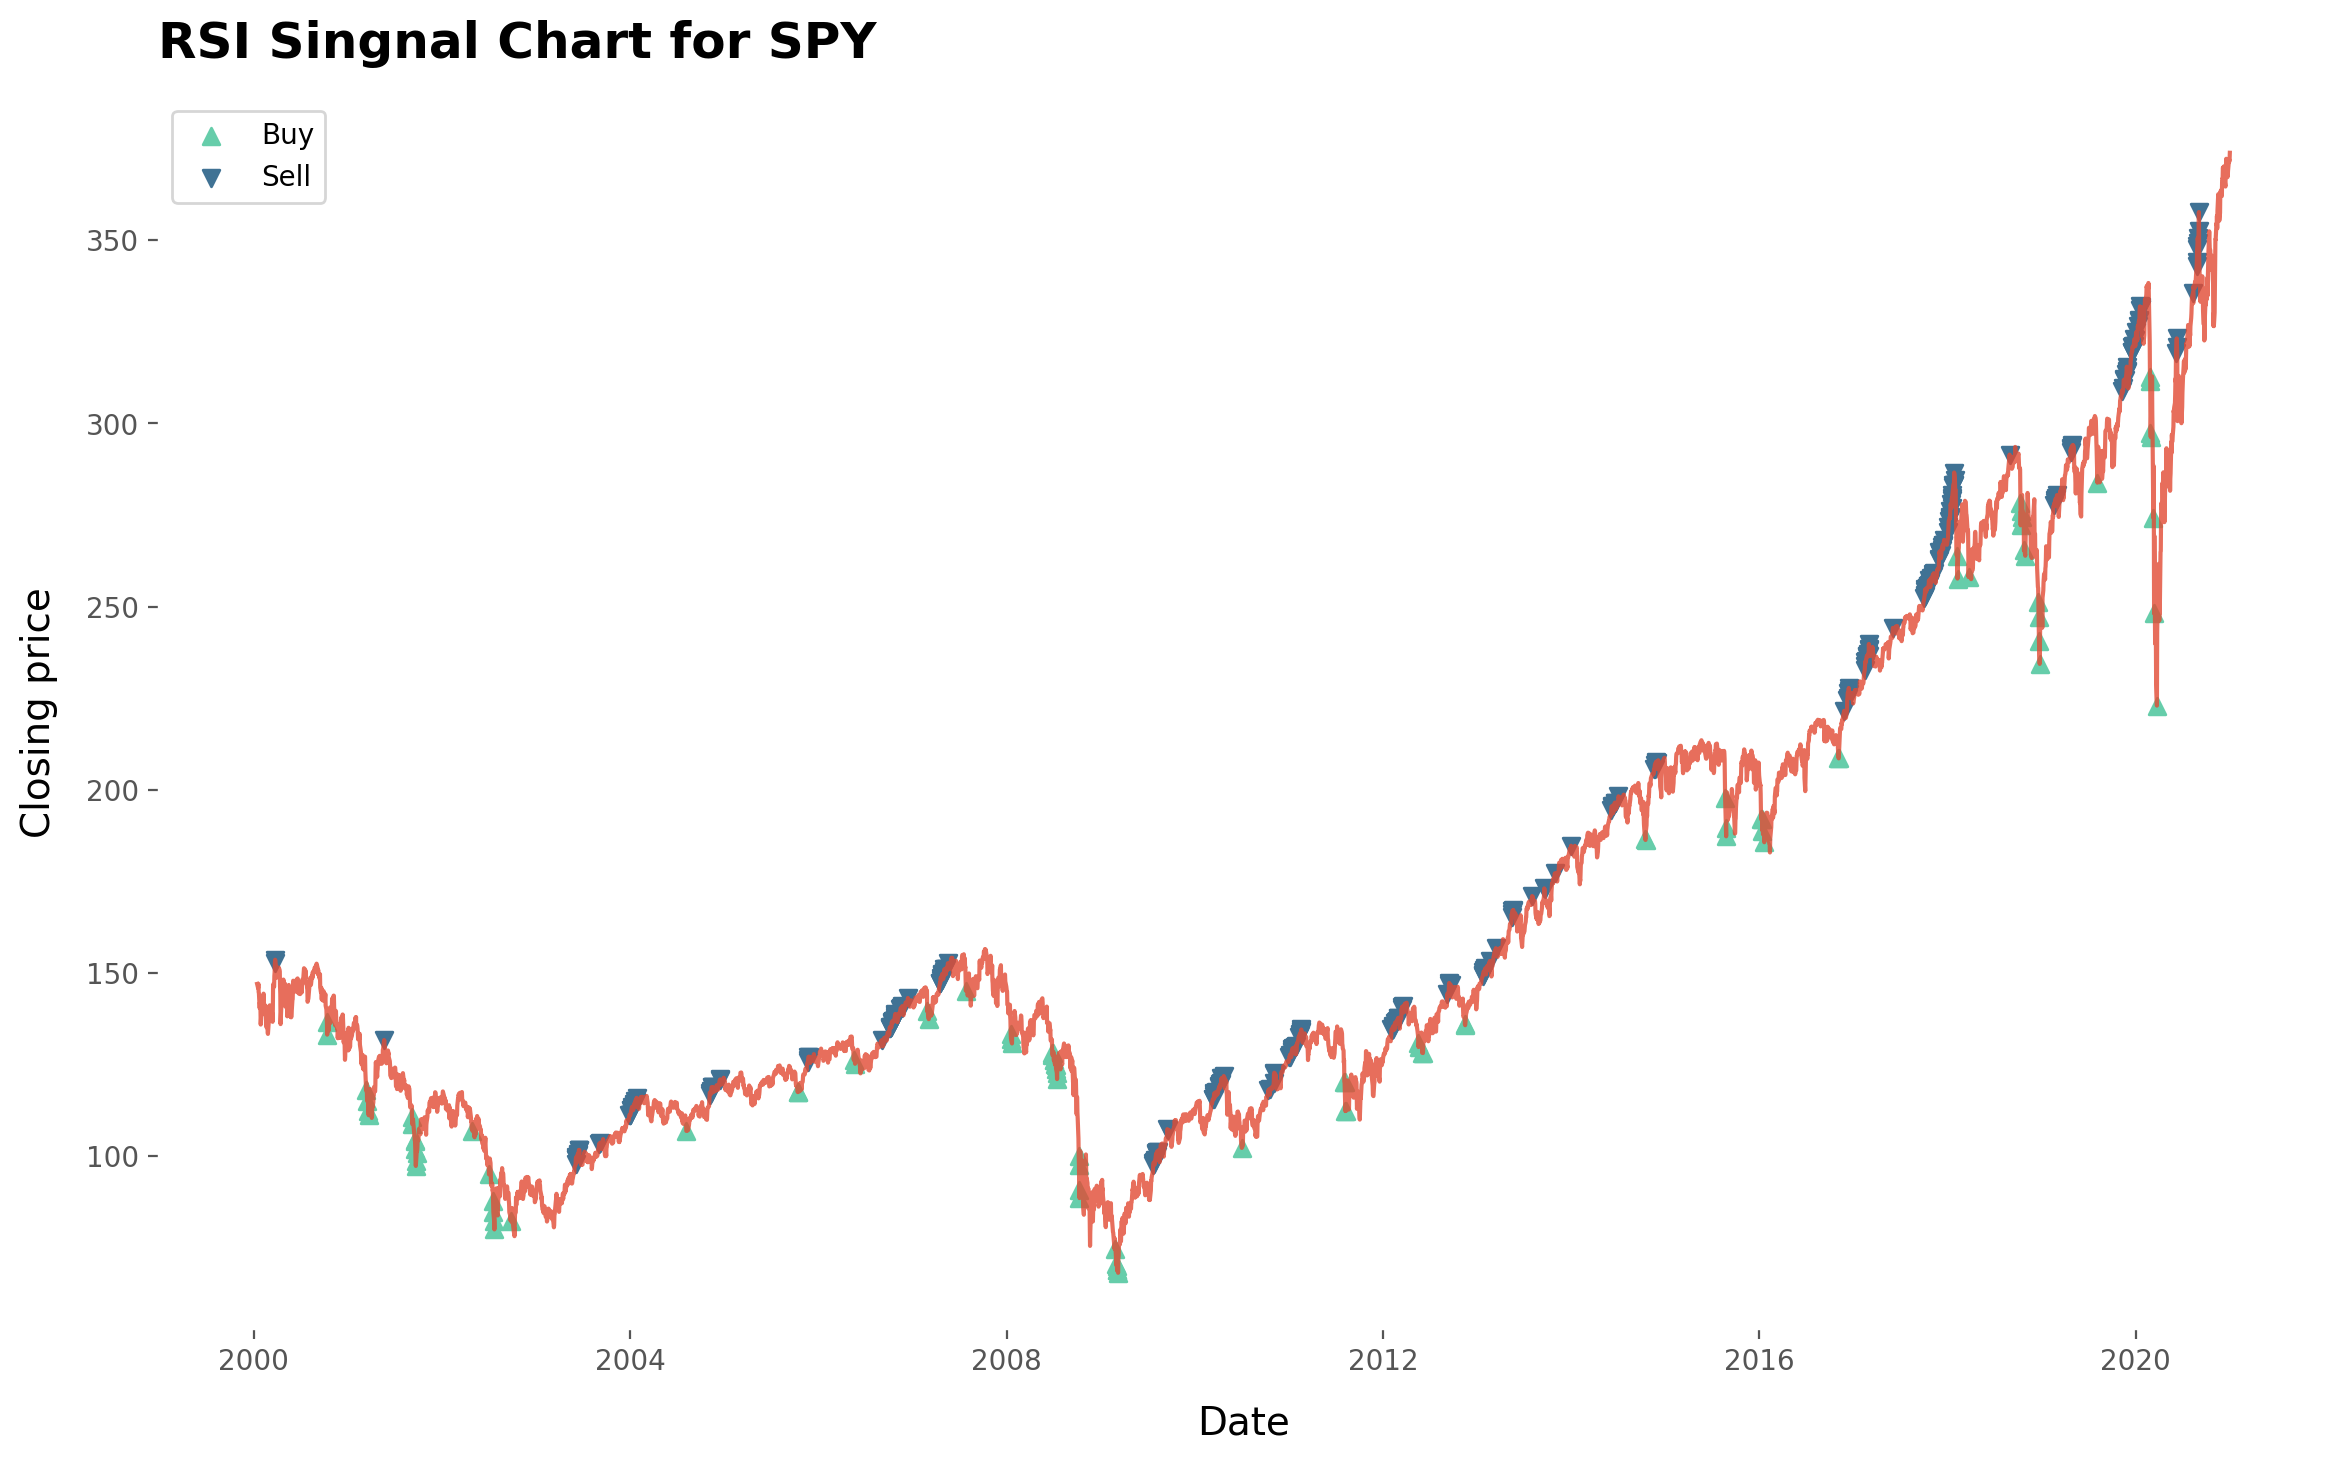

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(f'RSI Singnal Chart for {ticker}', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], alpha=0.8)
plt.scatter(df.index, buy_signal_rsi, label='Buy', marker='^', color='#66cdaa')
plt.scatter(df.index, sell_signal_rsi, label='Sell', marker='v', color='#407294')

plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14)
plt.grid(False)
plt.legend();

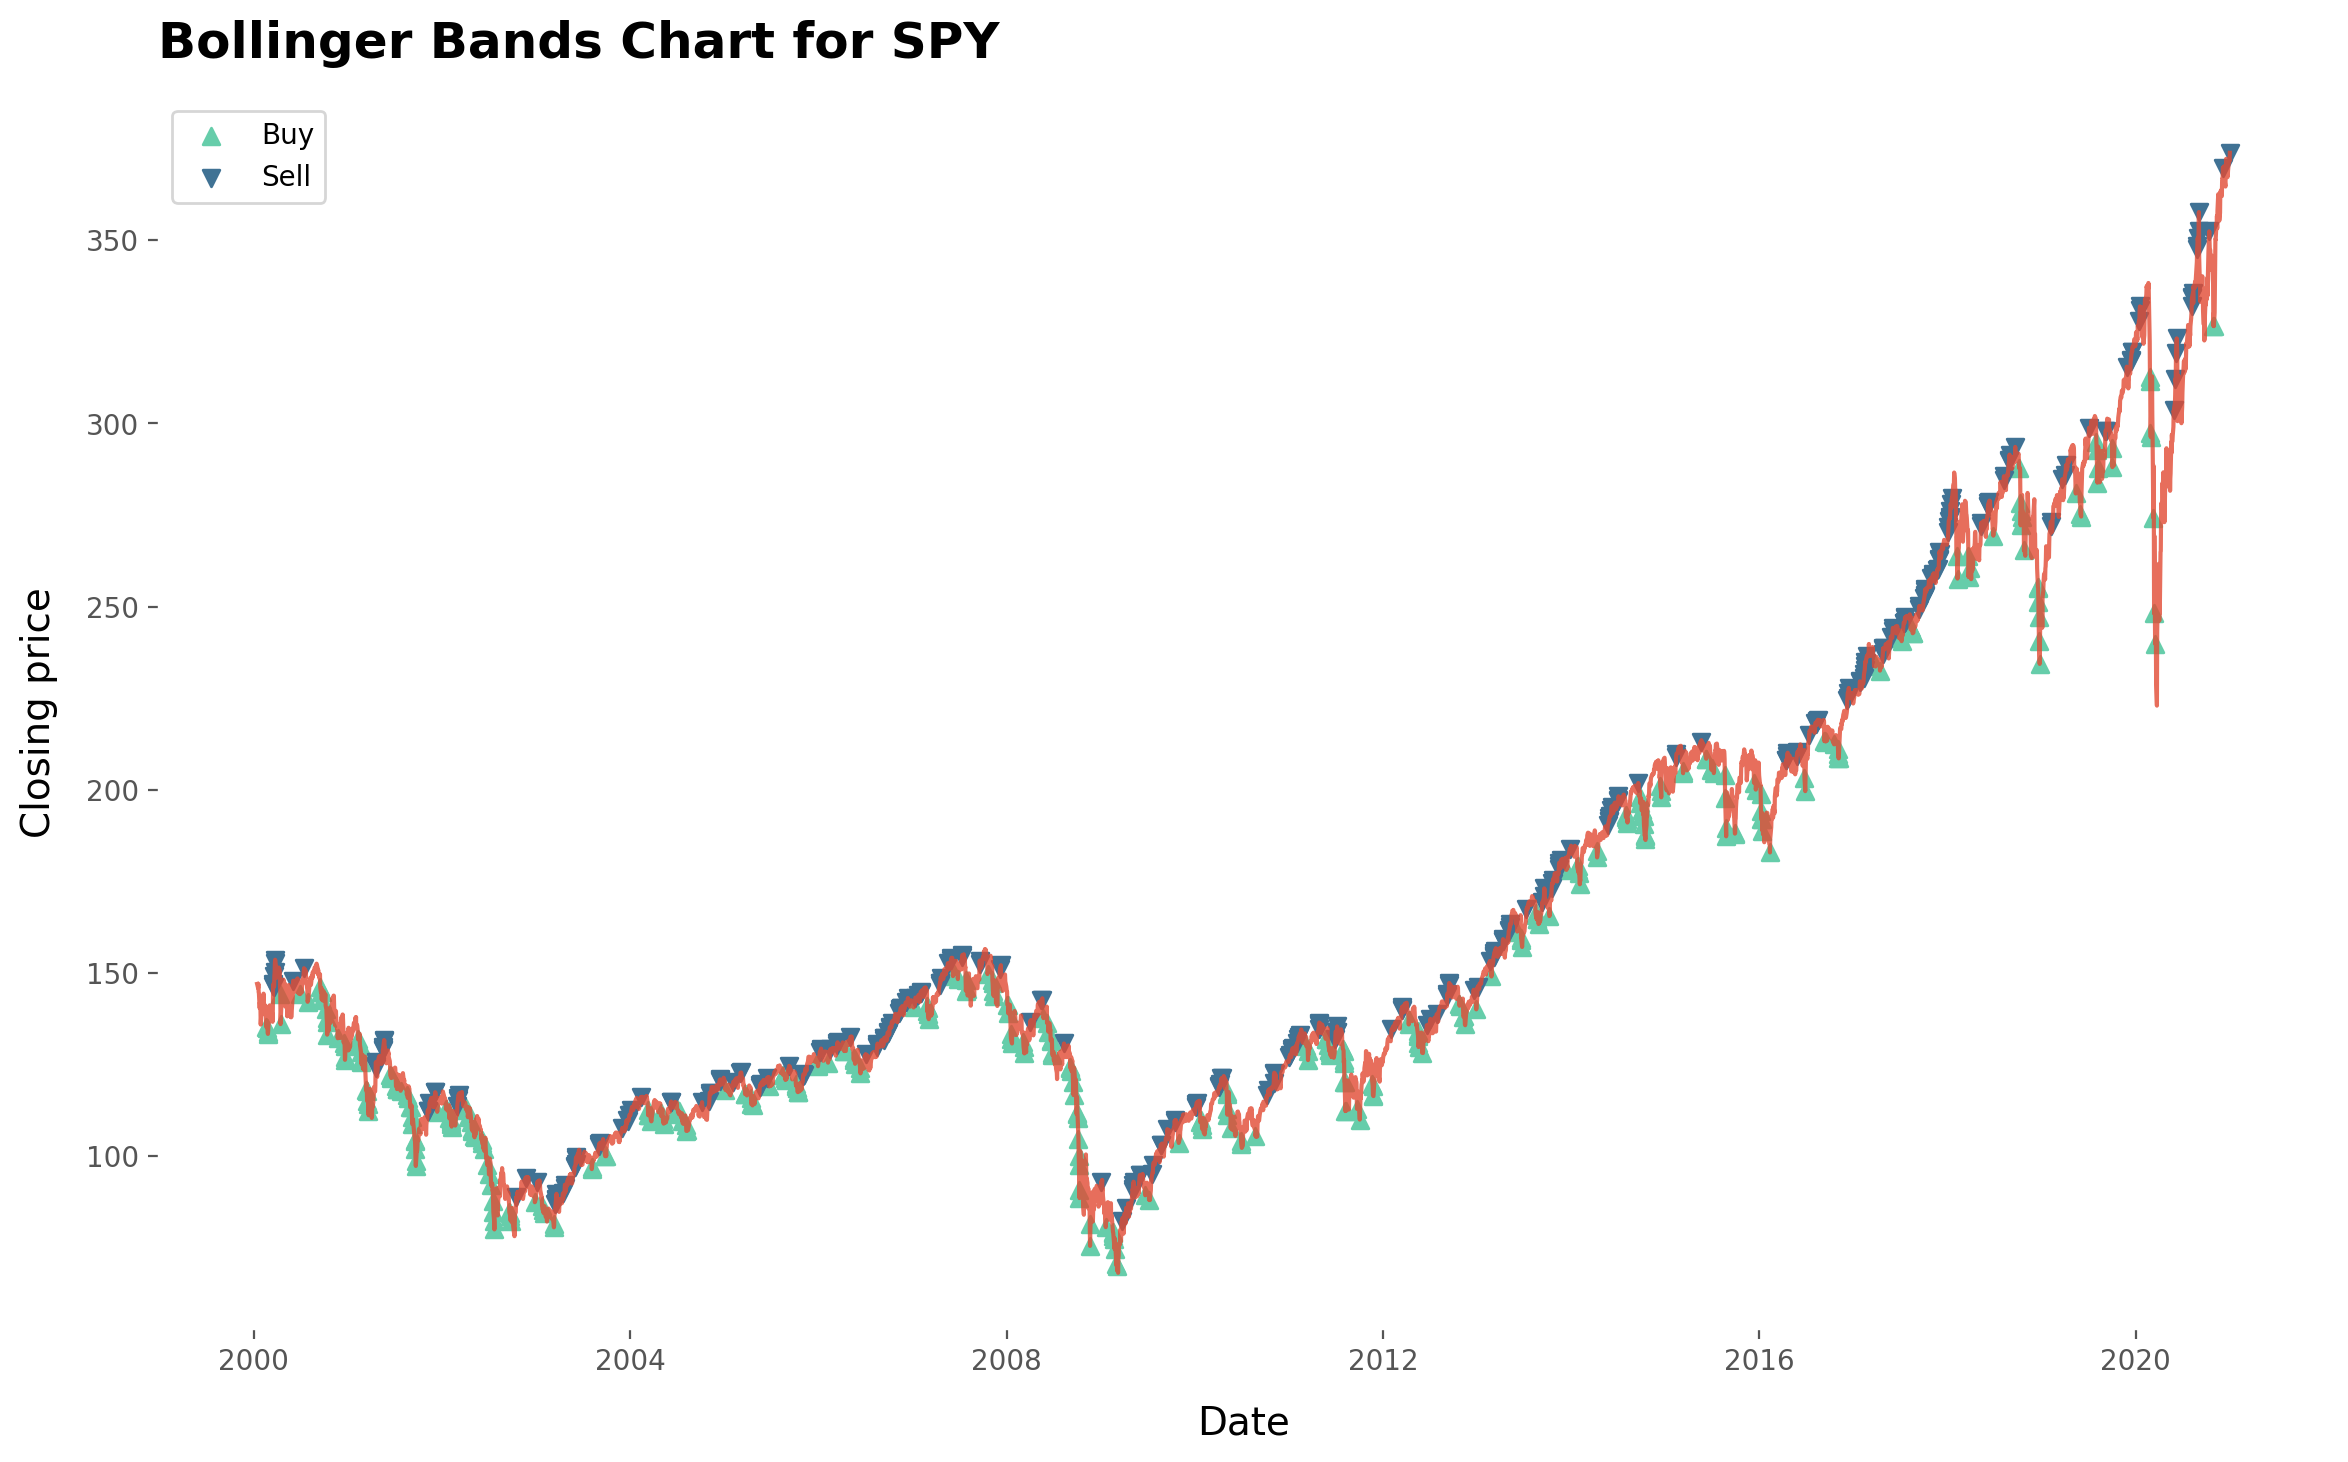

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(f'Bollinger Bands Chart for {ticker}', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], alpha=0.8)
plt.scatter(df.index, buy_signal_bb, label='Buy', marker='^', color='#66cdaa')
plt.scatter(df.index, sell_signal_bb, label='Sell', marker='v', color='#407294')

plt.grid(False)
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14)
plt.legend();

## Preprocess Data

Split the data on training, validation and test datasets to work with RNNs.

### Without Technical Indicators

In [ ]:
train_size = round(0.9 * df.shape[0])
test_size = df.shape[0] - train_size
val_size = round(0.25 * train_size)
train_size = train_size - val_size

In [ ]:
data = df['Close'].to_numpy()

After creating dummy variables, the time-series are min-max normalized, such that the preprocessed data lies between zero and one:

$$
    \tilde{x}_{tj} = \dfrac{x_{tj}-\min_tx_{tj}}{\max_tx_{tj}-\min_tx_{tj}}
$$


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_without = MinMaxScaler(feature_range=(-1, 1))
data_preproc = torch.tensor(scaler_without.fit_transform(data.reshape(-1, 1))).reshape(1, -1).type(torch.Tensor)

In [ ]:
window_size = 15

batch_windows = data_preproc.unfold(dimension=-1, size=window_size, step=1).reshape(-1, window_size, 1)

X_train_without = batch_windows[:val_size + train_size, :-1, :]
X_test_without = batch_windows[val_size + train_size:, :-1]

# Need predict the next value considering 14 lookback periods
y_train_without = batch_windows[:val_size + train_size, -1, :]
y_test_without = batch_windows[val_size + train_size:, -1, :]

### With Technical Indicators

In [ ]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA(10)', 'WMA(10)',
       'EMA(200)', 'Above_SMA(10)', 'Above_WMA(10)', 'Above_EMA(200)',
       'Oversold_RSI(14)', 'Overbought_RSI(14)', 'Oversold_Bollinger',
       'Overbought_Bollinger'],
      dtype='object')

In [ ]:
columns_titles = ['Close', 'High', 'Low', 'Open', 'Volume', 'SMA(10)', 'WMA(10)',
                  'EMA(200)', 'Oversold_RSI(14)', 'Overbought_RSI(14)',
                  'Oversold_Bollinger', 'Overbought_Bollinger']
df=df.reindex(columns=columns_titles)

In [ ]:
df.head()

Close       High        Low       Open   Volume     SMA(10)  \
Date                                                                          
2000-01-14  146.96875  147.46875  145.96875  146.53125  7437300  143.446875   
2000-01-18  145.81250  146.62500  145.18750  145.34375  6488500  143.484375   
2000-01-19  147.00000  147.00000  145.00000  145.31250  6157900  144.209375   
2000-01-20  144.75000  146.96875  143.81250  146.96875  5800100  144.684375   
2000-01-21  144.43750  145.50000  144.06250  145.50000  6244800  145.353125   

               WMA(10)    EMA(200)  Oversold_RSI(14)  Overbought_RSI(14)  \
Date                                                                       
2000-01-14  144.234091  144.234091                 0                   0   
2000-01-18  144.664205  144.664205                 0                   0   
2000-01-19  145.303409  145.303409                 0                   0   
2000-01-20  145.401705  145.401705                 0                   0   
2000-01-21  145.356818  145.356818                 0                   0   

            Oversold_Bollinger  Overbought_Bollinger  
Date                                                  
2000-01-14                   0                     0  
2000-01-18                   0                     0  
2000-01-19                   0                     0  
2000-01-20                   0                     0  
2000-01-21                   0                     0

In [ ]:
scaler_with = MinMaxScaler(feature_range=(-1, 1))
data_preproc = torch.tensor(scaler_with.fit_transform(df)).type(torch.Tensor)

In [ ]:
data_preproc_t = data_preproc.transpose(-2, -1)
data_preproc_t

tensor([[-0.4842, -0.4918, -0.4840,  ...,  0.9842,  0.9876,  1.0000],
        [-0.4977, -0.5032, -0.5007,  ...,  0.9711,  0.9652,  0.9754],
        [-0.4819, -0.4871, -0.4883,  ...,  0.9951,  1.0000,  0.9978],
        ...,
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000,  1.0000]])

In [ ]:
windows = []

for i in range(data_preproc.shape[1]):
    windows.append(data_preproc_t.unfold(dimension=-1, size=window_size, step=1)[i].reshape(-1, window_size, 1))

In [ ]:
batch_windows = torch.cat((windows), dim=2)

In [ ]:
X_train_with = batch_windows[:val_size + train_size, :-1, :]
X_test_with = batch_windows[val_size + train_size:, :-1]

y_train_with = y_train_without
y_test_with = y_test_without

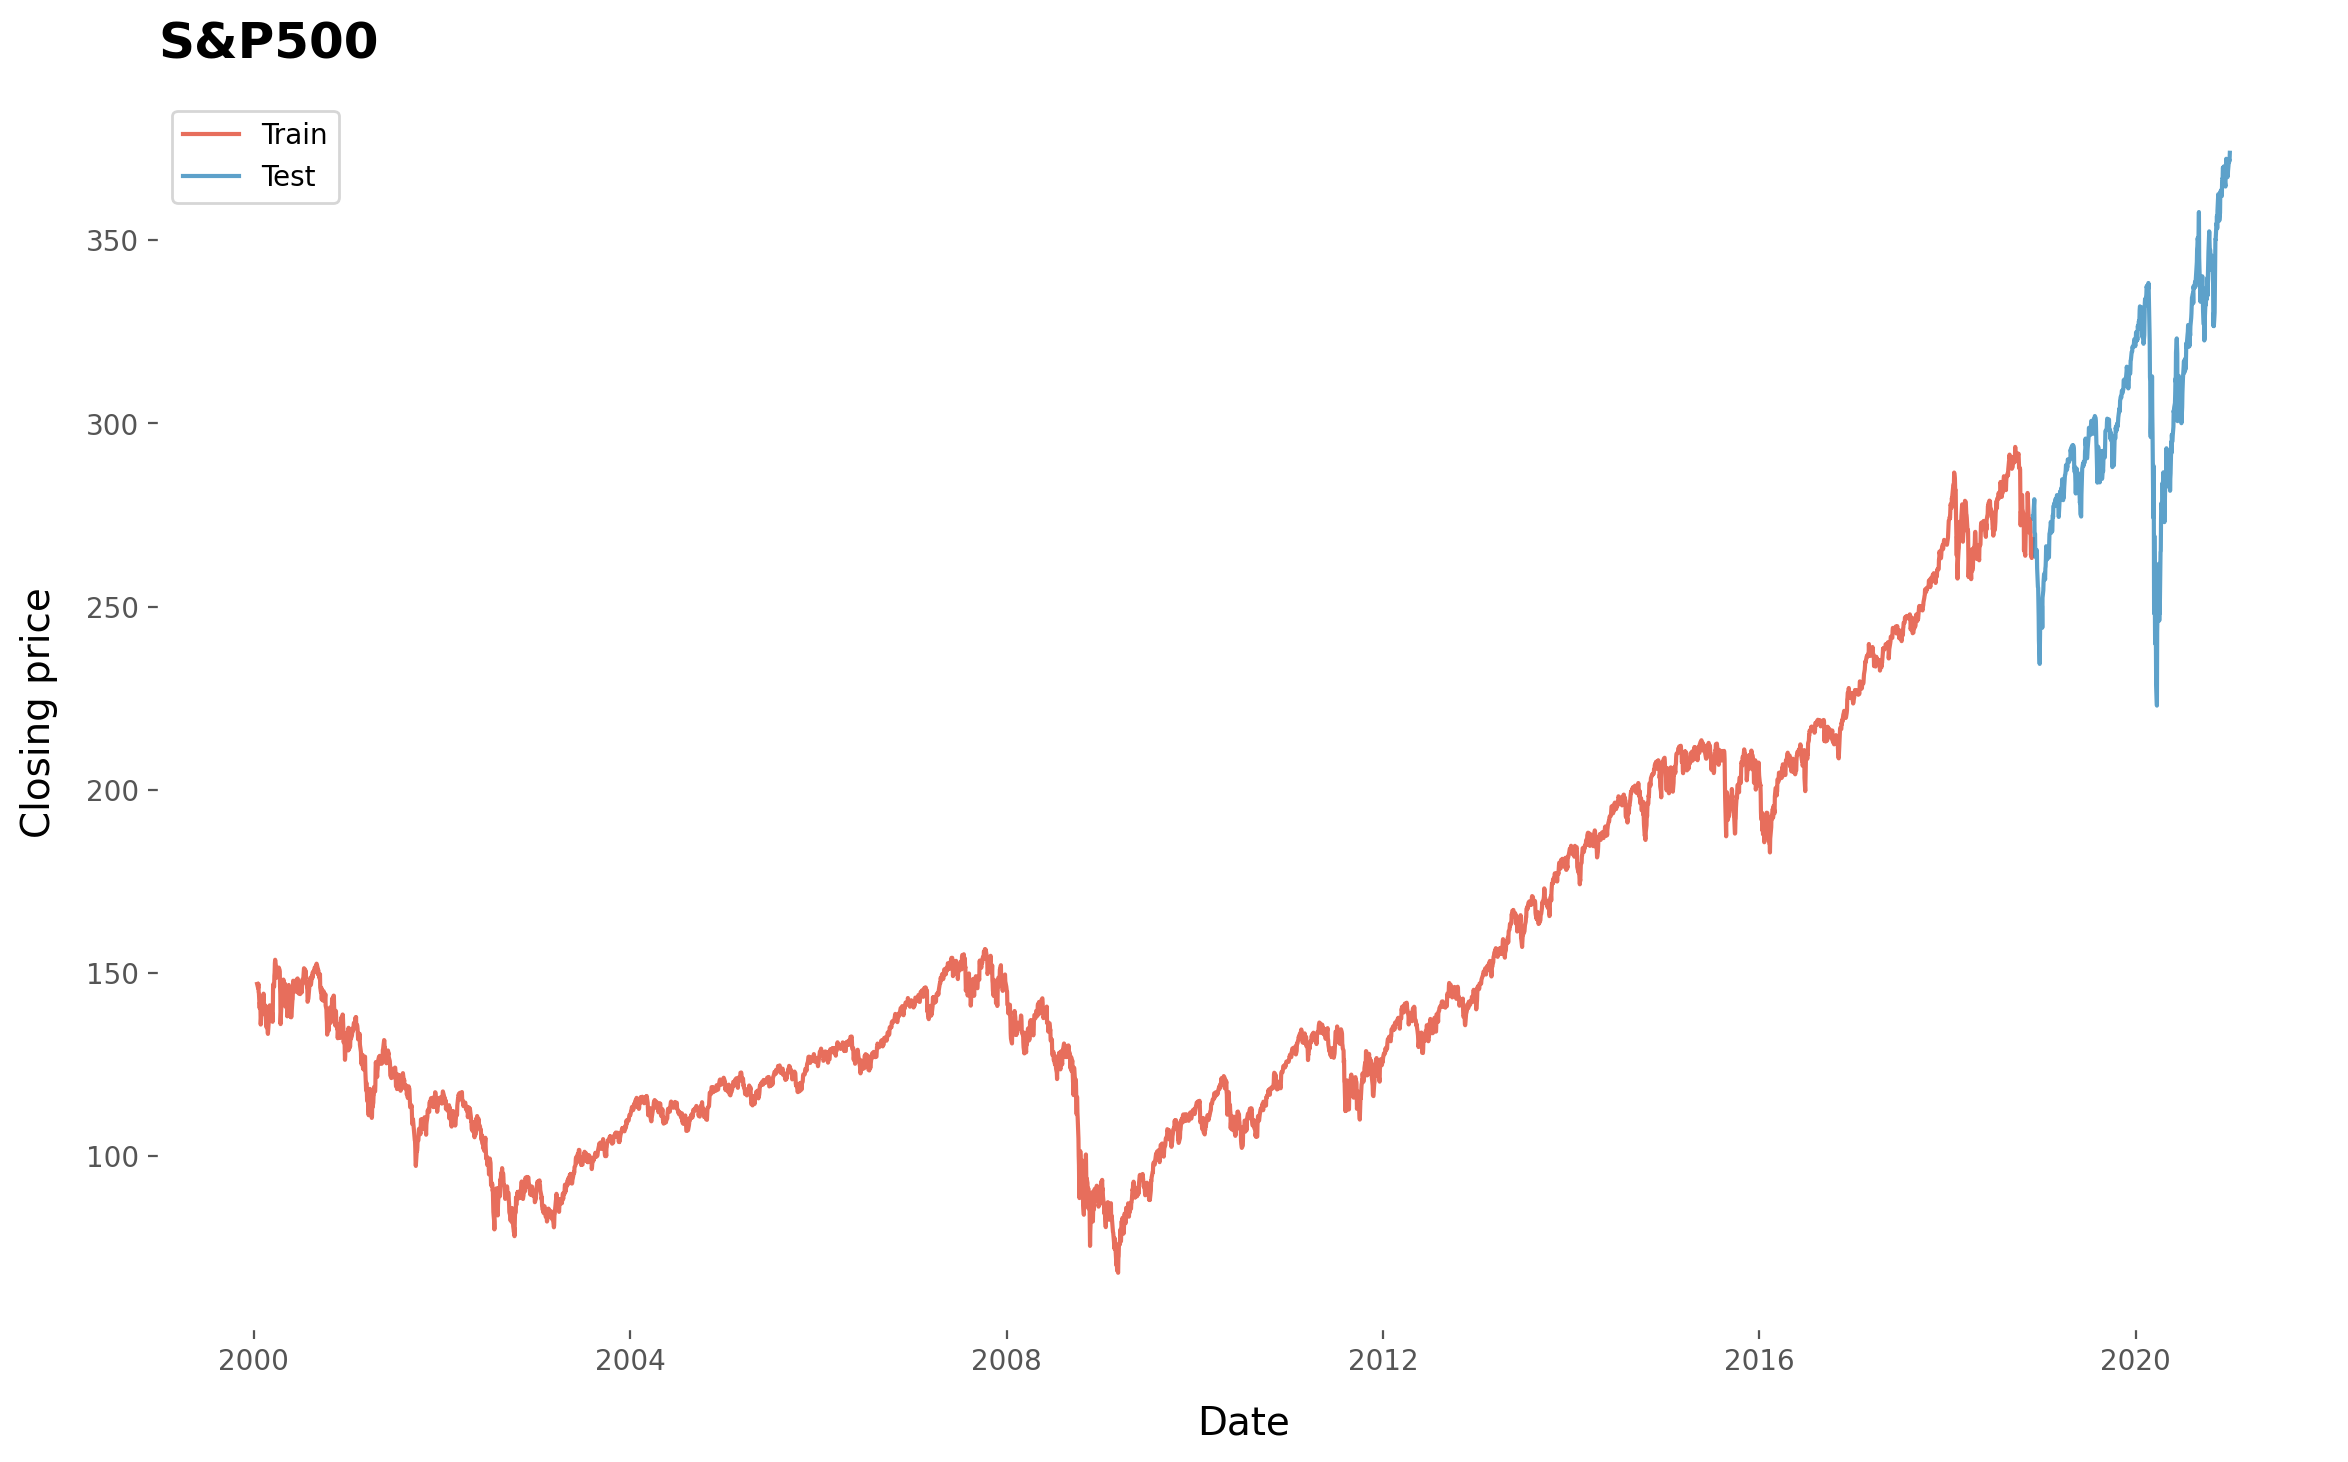

In [ ]:
plt.figure(figsize=(14, 8))
plt.title('S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index[:train_size+val_size],
         df['Close'][:train_size+val_size],
         label='Train', alpha=0.8)

plt.plot(df.index[train_size+val_size:],
         df['Close'][train_size+val_size:],
         label='Test', alpha=0.8)

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

## Models

In [ ]:
def get_predictions(model, scaler, X_train, y_train, X_test, y_test):
    model.eval()
    y_pred_train = model(X_train.to(device))
    y_pred_test = model(X_test.to(device))

    y_pred_train = scaler.inverse_transform(y_pred_train.cpu().detach().numpy())
    y_train = scaler.inverse_transform(y_train.cpu().detach().numpy())

    y_pred_test = scaler.inverse_transform(y_pred_test.cpu().detach().numpy())
    y_test = scaler.inverse_transform(y_test.cpu().detach().numpy())

    return y_pred_train, y_train, y_pred_test, y_test

In [ ]:
def eval_losses(y_pred_train, y_true_train, y_pred_test, y_true_test):
    print(f'Train RMSE = {np.sqrt(sum((y_pred_train - y_true_train) ** 2))[0]:.5}')
    print(f'Train MAE = {sum(np.abs(y_pred_train - y_true_train))[0]:.5}')
    smape_train = 100 / len(y_pred_train) * np.sum(2 * np.abs(y_pred_train - y_true_train) / (np.abs(y_pred_train) + np.abs(y_true_train)))
    print(f'Train SMAPE = {smape_train:.5}\n')

    print(f'Test RMSE = {np.sqrt(sum((y_pred_test - y_true_test) ** 2))[0]:.5}')
    print(f'Test MAE = {sum(np.abs(y_pred_test - y_true_test))[0]:.7}')
    smape_test = 100 / len(y_pred_test) * np.sum(2 * np.abs(y_pred_test - y_true_test) / (np.abs(y_pred_test) + np.abs(y_true_test)))
    print(f'Test SMAPE = {smape_test:.5}\n')

    print(f'R_sq = {r2_score(y_true_test, y_pred_test)}')

In [ ]:
class RMSELoss(nn.Module):
    def __init__(self, reduction):
        super().__init__()
        self.mse = nn.MSELoss(reduction=reduction)

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

In [ ]:
criterion = RMSELoss(reduction='mean')

## RNNs

A recurrent neural network (RNN) is a type of the ANN that is well-suited to time series $\{y_t\}_{t=1}^T$, since it is designed to work with sequence data.

<center><img src="https://github.com/khaykingleb/Stock-Price-Forecasting/blob/main/img/rnn_1.svg?raw=1"/></center>


Let us assume that we want to maximize the probability of a series $\{y_t\}_{t=1}^T$. Then the model would be written as
$$
 p(y_1, \dots, y_T) = \prod_{t=1}^{T}p(y_t \mid y_{t-1}, \dots, y_1) \rightarrow \max
$$

In order to get $\hat y_t$, there is a need to model the conditional probability given all previous values $\hat y_{t-1}, \dots, \hat y_1$:

$$
\hat y_t \sim p(y_t \mid \hat y_{t-1}, \dots, \hat y_1)
$$

Note that to get the probability of $y_t$ we need to construct $t-1$
sequential models. In such a case, the memory requirements grow exponentially with the time step $t$.

However, instead of modeling this probability, we could use a latent variable $h_t$ called a hidden state, which stores all data it has seen so far:

$$
p(y_t \mid \hat y_{t-1}, \dots, \hat y_1) \approx p(y_t \mid h_{t-1}), \ h_t = f(y_t, h_{t-1})
$$

The RNN uses this technique. It is the ANN with hidden states and is capable of conditioning the model on all previous values. Consider a multivariate time series $\{(x_t, y_t)\}_{t=1}^{T}$, $x_t \in \mathbb{R}^d \ \text{and} \  y_t \in \mathbb{R}$, then the RNN has the following architecture:

$$
\begin{equation*}
\begin{aligned}
h_{t} = & \ f_{h}( W_{xh} x_{t} +W_{hh} h_{t-1} +b_{h}) \\
\hat{y}_{t} = & \ f_{y}( W_{hy} h_{t} +b_{y})
\end{aligned}
\end{equation*}
$$

where $h_{t}$ is hidden state and $\hat y_t$ is output layer at the time step $t$, $W_{xh}$, $W_{hh}$, $W_{hy}$ are weights, $b_{h}, b_{y}$ are biases, and $f_{h}, f_{y}$ are activation functions.

<center><img src="https://github.com/khaykingleb/Stock-Price-Forecasting/blob/main/img/rnn_2.svg?raw=1"/></center>

### Backpropagation Through Time

To train a RNN model, we use backpropagation through time (BPTT), considering that now $L(y_{t}, \hat{y}( x_{t}; w))=\sum\limits_{t=1}^{T} L_t(y_{t}, \hat{y}_t( x_{t}; w))$.

The derivatives of the loss function when there are no recurrent loops are computed straightforward:
$$
\begin{equation*}
\begin{aligned}
\dfrac{\partial L}{\partial b_{y}} = & \  \sum _{i=t}^{T}\dfrac{\partial L_{t}}{\partial b_{y}} =\sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial \hat{y}_{t}}\dfrac{\partial \hat{y}_{t}}{\partial b_{y}} \\
\dfrac{\partial L}{\partial b_{h}} = & \ \sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial b_{h}} =\sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial h_{t}}\dfrac{\partial h_{t}}{\partial b_{h}}
\dfrac{\partial L}{\partial W_{hy}} = \sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial W_{hy}} =\sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial \hat{y}_{t}}\dfrac{\partial \hat{y}_{t}}{\partial W_{hy}}
\end{aligned}
\end{equation*}
$$

However, it gets a little bit more complicated when there are recurrent loops. Let $W\in \{W_{xh} ,W_{hh}\}$, then the derivatives of the loss function are written as follows

$$
\begin{equation*}
\begin{aligned}
\dfrac{\partial L}{\partial W} = & \ \sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial W} =\sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial \hat{y}_{t}}\dfrac{\partial \hat{y}_{t}}{\partial h_{t}}\dfrac{\partial h_{t}}{\partial W} = \\
= & \ \sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial \hat{y}_{t}}\dfrac{\partial \hat{y}_{t}}{\partial h_{t}}\left(\dfrac{\partial h_{t}}{\partial W} +\dfrac{\partial h_{t}}{\partial h_{t-1}}\dfrac{\partial h_{t-1}}{\partial W} +\dotsc +\dfrac{\partial h_{t}}{\partial h_{t-1}}\dfrac{\partial h_{t-1}}{\partial h_{t-2}} \dotsc \dfrac{\partial h_{1}}{\partial W}\right) = \\
= & \ \sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial \hat{y}_{t}}\dfrac{\partial \hat{y}_{t}}{\partial h_{t}}\sum _{i=1}^{t}\left(\prod _{j=i+1}^{t}\dfrac{\partial h_{j}}{\partial h_{j-1}}\right)\dfrac{\partial h_{t}}{\partial W}
\end{aligned}
\end{equation*}
$$

Note that because a neuron $h\in \mathbb{R}^{q}$, each $\partial h_{j} /\partial h_{j-1}$ is the Jacobian matrix for $h$:
$$\dfrac{\partial h_{j}}{\partial h_{j-1}} =\left(\dfrac{\partial h_{j}}{\partial h_{j-1,1}} ,\dotsc ,\dfrac{\partial h_{j}}{\partial h_{j-1,q}}\right) =\begin{pmatrix}
\dfrac{\partial h_{j,1}}{\partial h_{j-1,1}} & \dotsc  & \dfrac{\partial h_{j,1}}{\partial h_{j-1,q}}\\
\vdots  & \ddots  & \vdots \\
\dfrac{\partial h_{j,q}}{\partial h_{j-1,1}} & \dotsc  & \dfrac{\partial h_{j,q}}{\partial h_{j-1,q}}
\end{pmatrix}$$

Now it can be inferred that the RNN has vanishing and exploding gradient problems:

1. If $\parallel \dfrac{\partial h_{j}}{\partial h_{j-1}} \parallel _{2} \ < 1$, then the gradient is vanishing as the time step $t$ is becoming large. It means that $W^{new} = W^{old} -\eta _{t}\dfrac{\partial L}{\partial W} \approx W^{old}$. To put it another way, our neural network stops learning.

2. If $\parallel \dfrac{\partial h_{j}}{\partial h_{j-1}} \parallel _{2}  \ >1$, then the gradient is exploding as the time step $t$ is becoming large. Enormous updates to the weight during training reaches a bad parameter configuration and sometimes can cause a numerical overflow, i.e. NaNs.


Given that, the RNN models often need help to stabilize their training. To solve the problem of exploding gradients, Pascanu et al. introduced a simple solution that clips gradients to a small
number whenever they explode:

$$
    g = \min\left(1, \dfrac{\delta}{ \parallel g \parallel_2}  \right)g
$$

where $\delta$ is the threshold and $g = \dfrac{\partial L}{\partial W}$. Alas, we still have the vanishing gradient problem.

### LSTM

The main problem of the RNN is that it struggles to preserve information over many time steps, since the hidden state is constantly being rewritten $h_t = f_{h}( W_{xh} x_{t} +W_{hh} h_{t-1} +b_{h})$. In order to cope with this, specific gates $\Gamma = f( W_{x} x_{t} +W_{h} h_{t-1} +b)$ are introduced, where $W_{x}, W_{h}, b$ are weights specific to the gate and $f$ is an activation function.

<center><img src="https://github.com/khaykingleb/Stock-Price-Forecasting/blob/main/img/lstm.svg?raw=1"/></center>

Hochreiter and Schmidhuber proposed a RNN model with Long-Term Short-Term Memory (LSTM) blocks as a solution to the vanishing gradient problem. The LSTM block is designed to address long-term information preservation and short-term input skipping by using not only a hidden state $h_t$, but also a memory cell $c_t$ which is able to remember information over time.

It has the following architecture:
1. Hidden state $h_t$ and cell state $c_t$:

$$
\begin{equation*}
\begin{aligned}
c_{t} = & \ \Gamma _{i} \odot \Gamma _{c} + \Gamma _{f} \odot c_{t-1} \\
h_{t} = & \ \Gamma _{o} \odot \tanh( c_{t})
\end{aligned}
\end{equation*}
$$


2. Input gate that decides what parts of the new cell content are written to cell

$$
\begin{equation*}
\begin{aligned}
\Gamma _{i} = & \ \sigma ( W_{xi} x_{t} +W_{hi} h_{t-1} +b_{i})
\end{aligned}
\end{equation*}
$$

3. Cell gate that decides what new content to be written to the cell

$$
\begin{equation*}
\begin{aligned}
\Gamma _{c} = & \ \tanh( W_{xc} x_{t} +W_{hc} h_{t-1} +b_{c})
\end{aligned}
\end{equation*}
$$

   

4. Forget gate that decides what is kept and what is forgotten from previous cell state.

$$
\begin{equation*}
\begin{aligned}
\Gamma _{f} = & \ \sigma ( W_{xf} x_{t} +W_{hf} h_{t-1} +b_{f})
\end{aligned}
\end{equation*}
$$


5. Output gate that decides what parts of cell are output to hidden state

$$
\begin{equation*}
\begin{aligned}
\Gamma _{o} = & \ \sigma ( W_{xo} x_{t} +W_{ho} h_{t-1} +b_{o})
\end{aligned}
\end{equation*}
$$


Using BPTT, we can show that $\displaystyle \forall W \in \{W_{xi}, W_{hi}, W_{xf}, W_{hf}, W_{xc}, W_{hc}, W_{xo}, W_{ho}\}$ the derivatives of the loss function are written as
$$\dfrac{\partial L}{\partial W} =\sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial W} =\sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial h_{t}}\dfrac{\partial h_{t}}{\partial c_{t}}\dfrac{\partial c_{t}}{\partial c_{t-1}} \dotsc \dfrac{\partial c_{1}}{\partial W} =\sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial h_{t}}\dfrac{\partial h_{t}}{\partial c_{t}}\left(\prod _{j=i+1}^{t}\dfrac{\partial c_{j}}{\partial c_{j-1}}\right)\dfrac{\partial c_{1}}{\partial W}$$

To solve the vanishing or exploding gradient problem, we need $\parallel \dfrac{\partial c_{j}}{\partial c_{j-1}} \parallel _{2} \ \approx 1$.
So, let us then expand the product expression:

$$
\begin{equation*}
\begin{aligned}
\dfrac{\partial c_{j}}{\partial c_{j-1}} = & \ \dfrac{\partial }{\partial c_{j-1}}( \Gamma _{i} \odot \Gamma _{c} +\Gamma _{f} \odot c_{j-1}) =\dfrac{\partial }{\partial c_{j-1}}( \Gamma _{i} \odot \Gamma _{c}) +\dfrac{\partial }{\partial c_{j-1}}( \Gamma _{f} \odot c_{j-1}) =
\\
= & \ \dfrac{\partial \Gamma _{i}}{\partial c_{j-1}} \Gamma _{c} +\dfrac{\partial \Gamma _{c}}{\partial c_{j-1}} \Gamma _{i} +\dfrac{\partial \Gamma _{f}}{\partial c_{j-1}} c_{j-1} +\Gamma _{f}
\end{aligned}
\end{equation*}
$$

We can observe that LSTM's additive property enables us to balance the gradient values during BPTT:

$$\dfrac{\partial L}{\partial W} =\sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial h_{t}}\dfrac{\partial h_{t}}{\partial c_{t}}\left(\prod _{j=i+1}^{t}\left[\dfrac{\partial \Gamma _{i}}{\partial c_{j-1}} \Gamma _{c} +\dfrac{\partial \Gamma _{c}}{\partial c_{j-1}} \Gamma _{i} +\dfrac{\partial \Gamma _{f}}{\partial c_{j-1}} c_{j-1} +\Gamma _{f}\right]\right)\dfrac{\partial c_{1}}{\partial W}$$

#### Without Technical Indicators

In [ ]:
seed_everything()

lstm_model = LSTM()
lstm_model.to(device)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

Epoch: 100


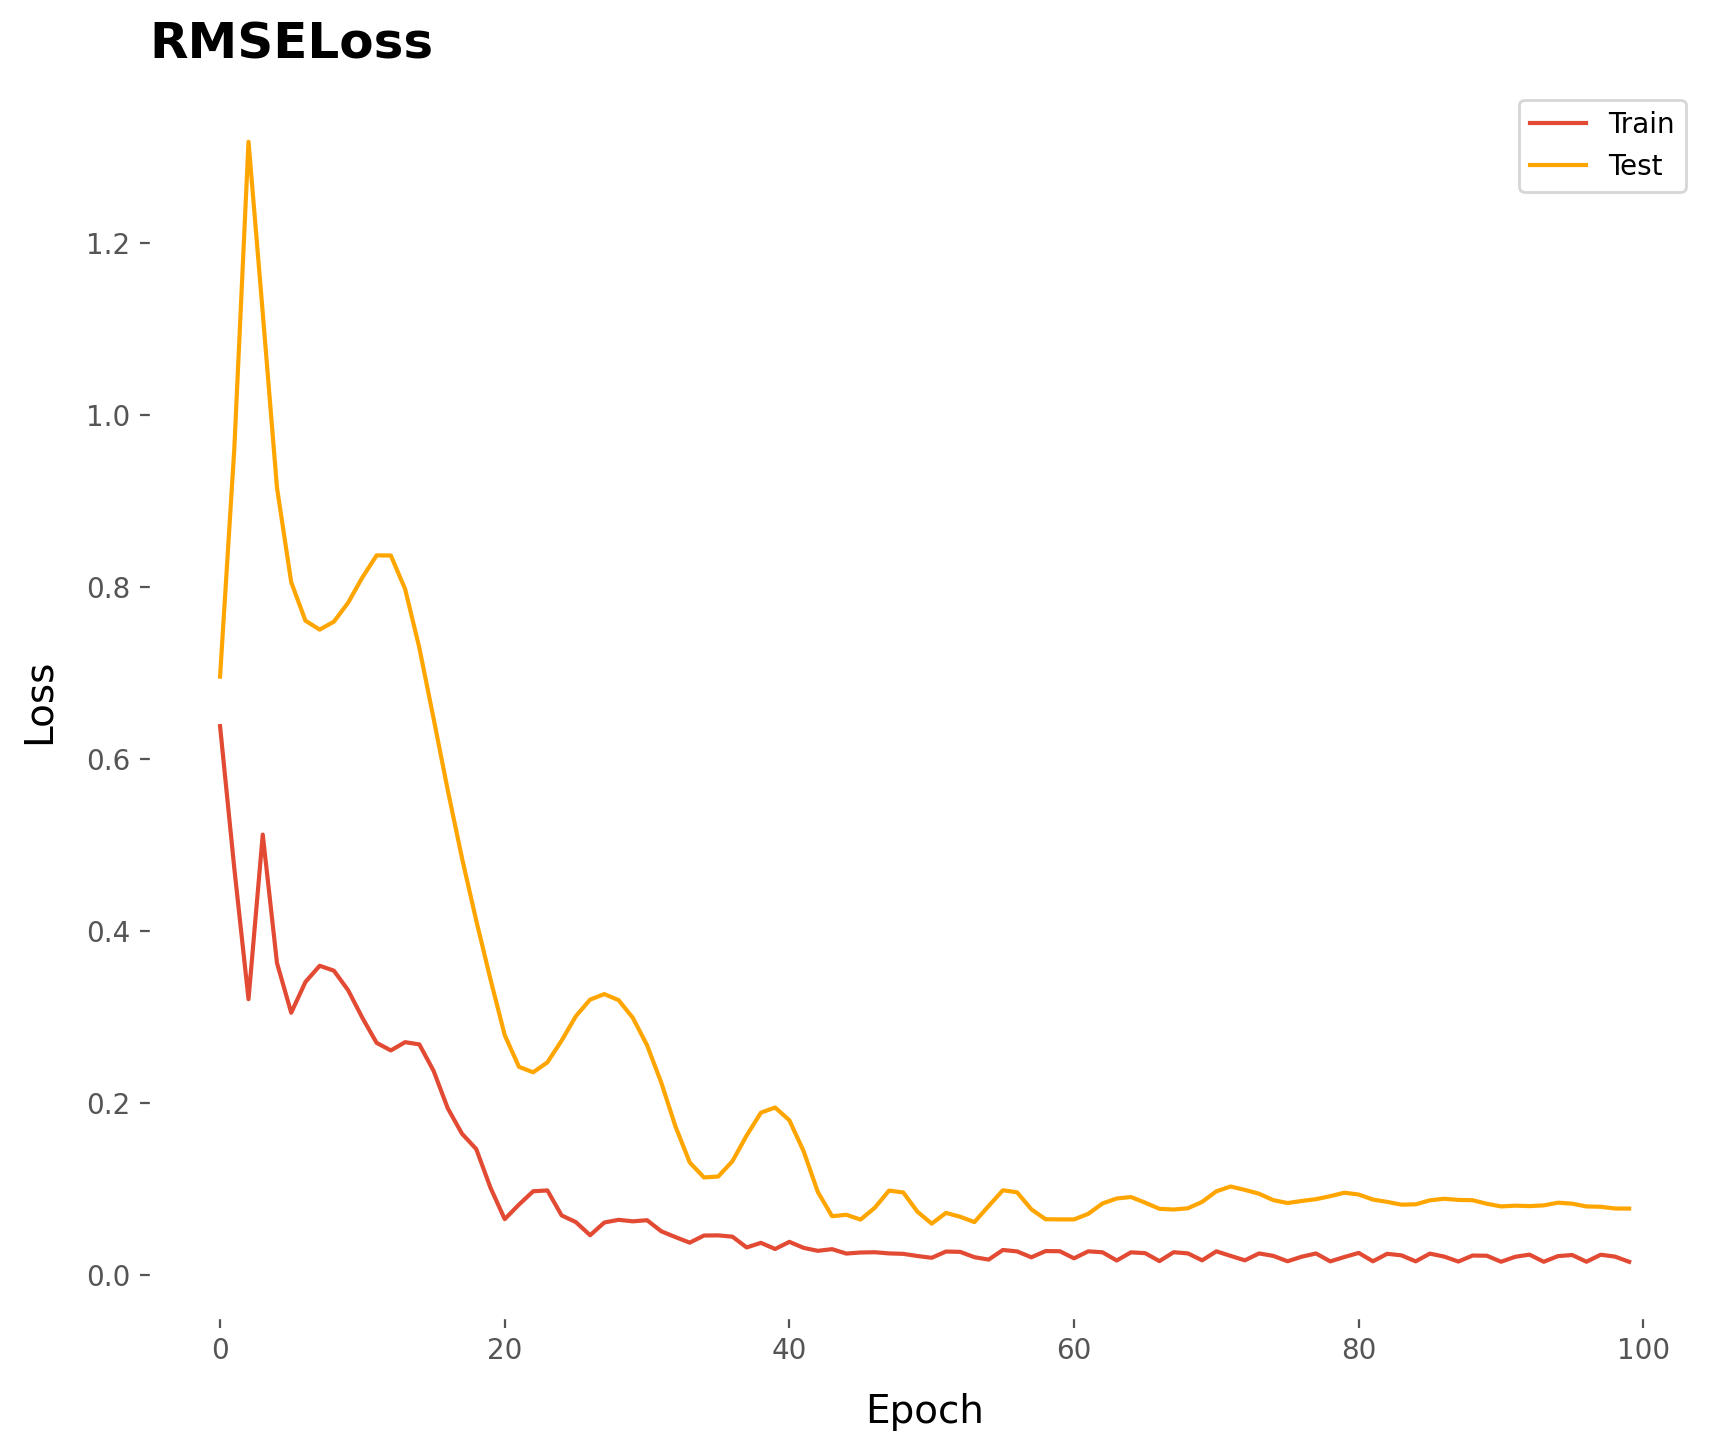

Train loss: 0.01559
Test loss: 0.07739


In [ ]:
seed_everything()
train_loss_lstm_without, test_loss_lstm_without = \
    train(lstm_model, criterion, optimizer, device, X_train_without, y_train_without,
           X_test_without, y_test_without, n_epochs=100)

In [ ]:
y_pred_train_lstm_without, y_train_lstm_without, y_pred_test_lstm_without, y_test_lstm_without = \
    get_predictions(lstm_model, scaler_without, X_train_without, y_train_without, X_test_without, y_test_without)

In [ ]:
eval_losses(y_pred_train_lstm_without, y_train_lstm_without,
            y_pred_test_lstm_without, y_test_lstm_without)

Train RMSE = 240.8
Train MAE = 1.3962e+04
Train SMAPE = 2.29

Test RMSE = 267.99
Test MAE = 4395.746
Test SMAPE = 2.7404

R_sq = 0.8432869985722032


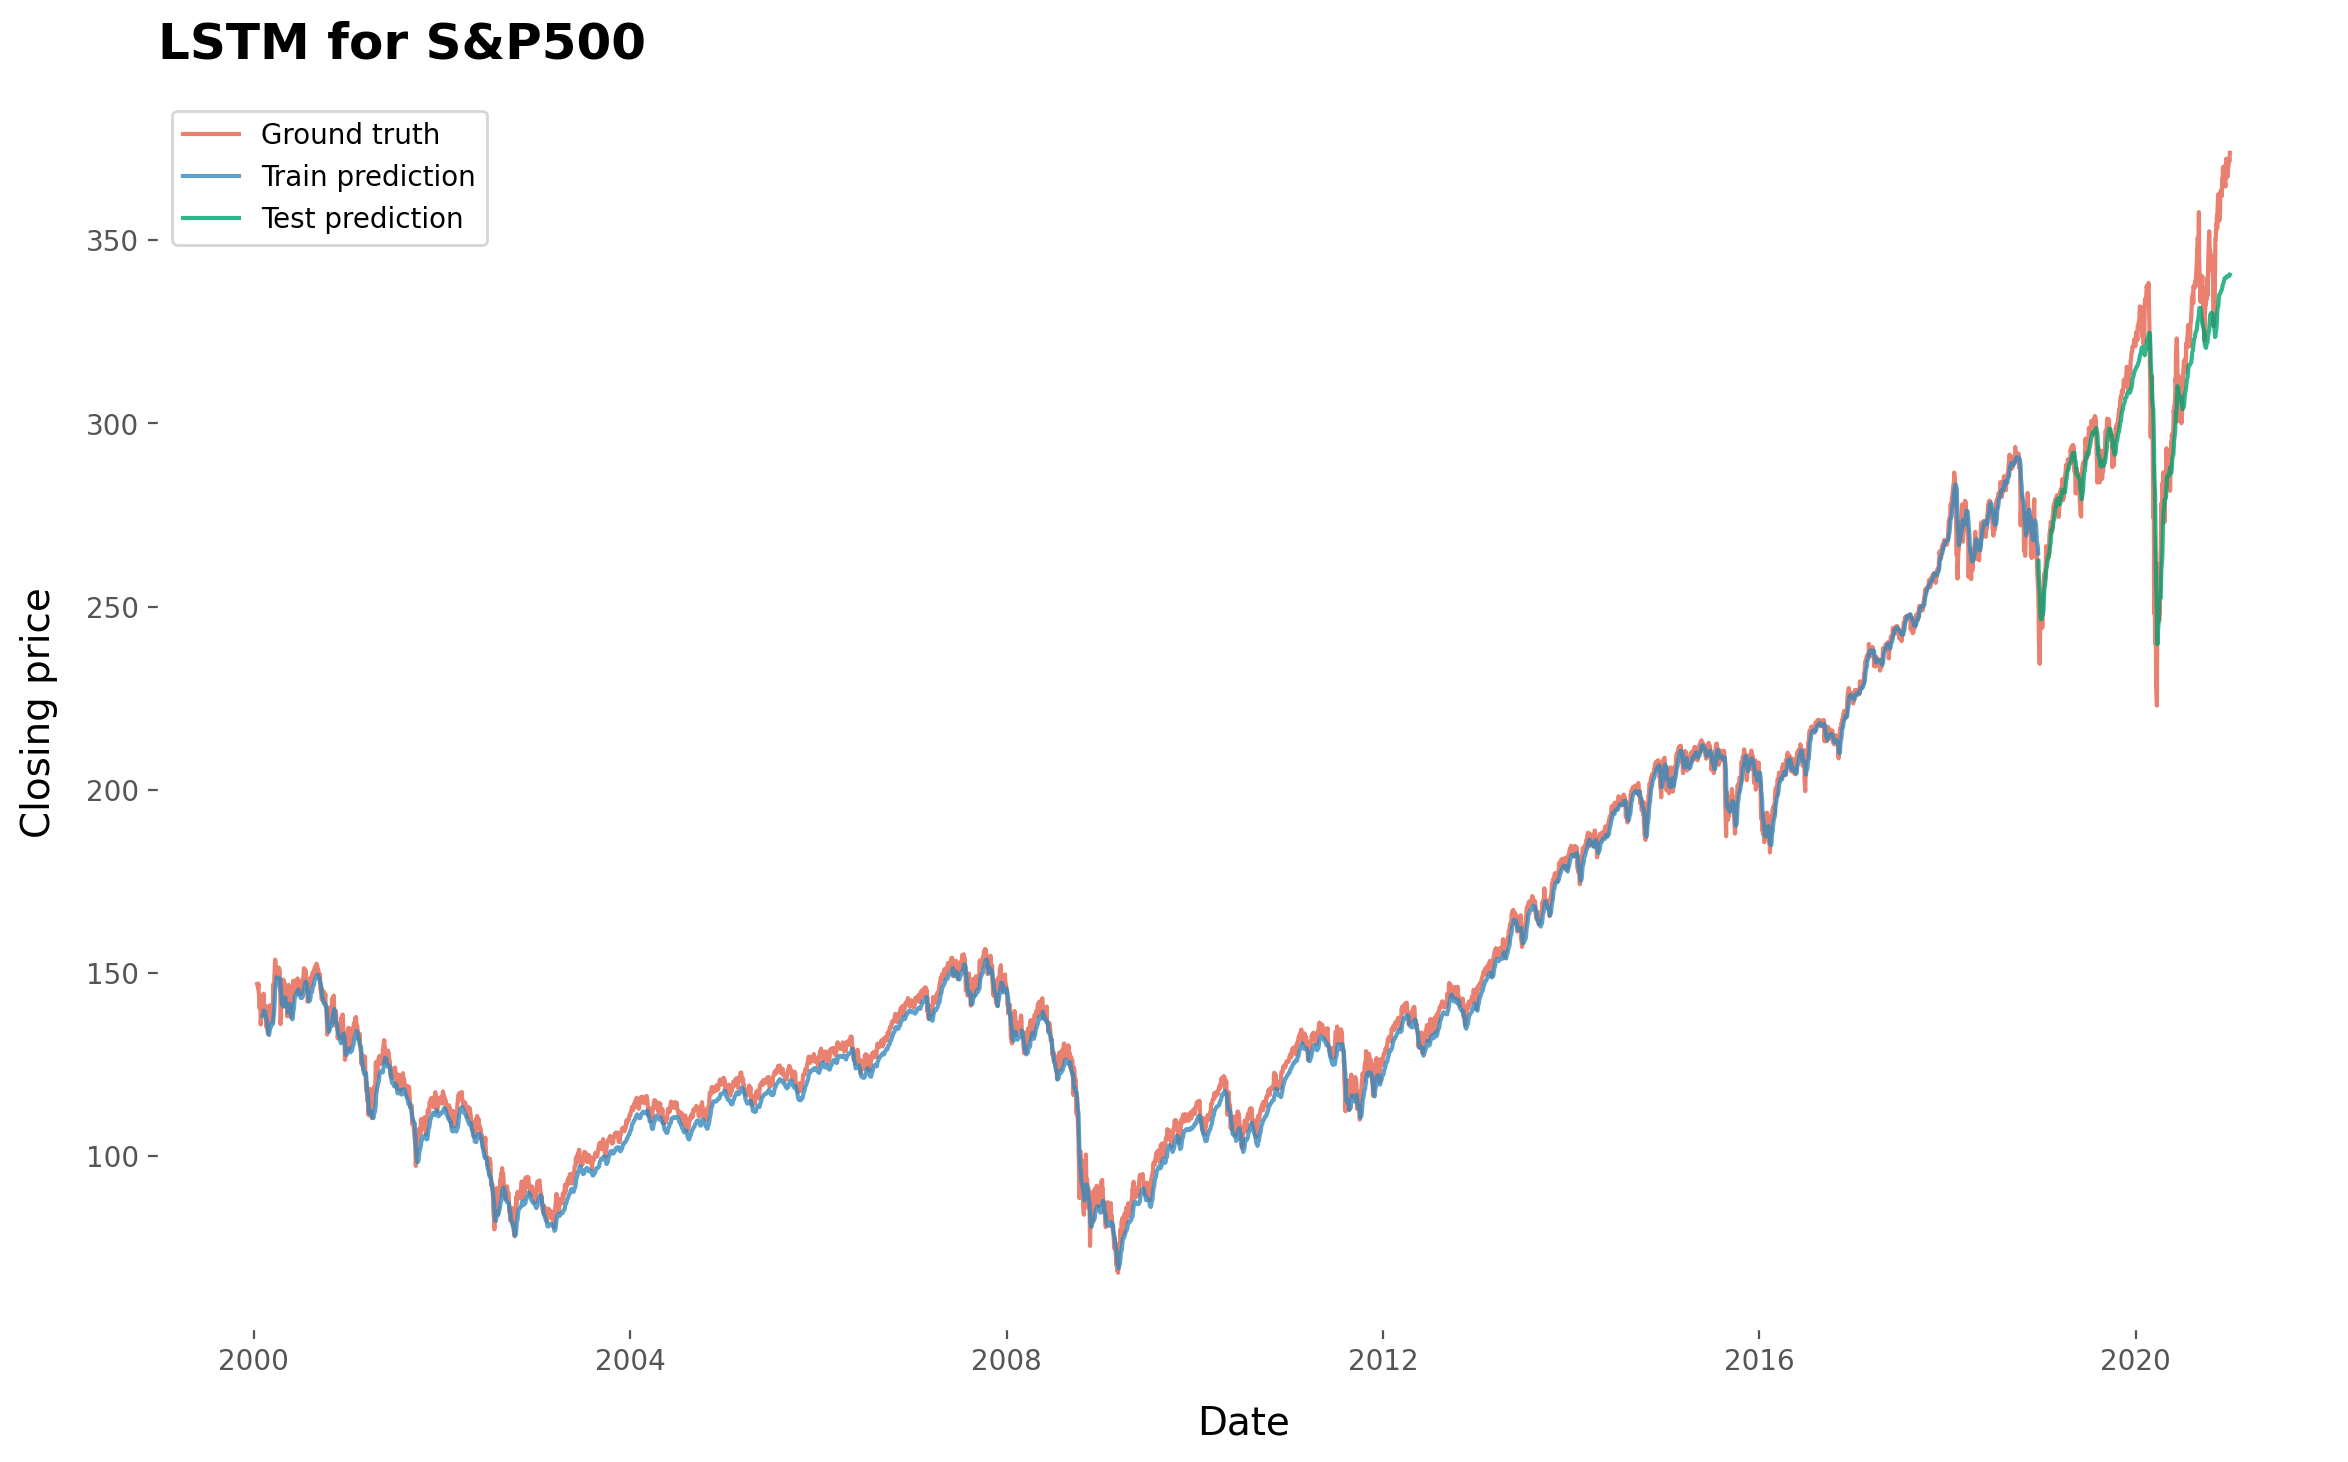

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(f'LSTM for S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth', alpha=0.7)

plt.plot(df.index[window_size-1:val_size+train_size+window_size-1],
         y_pred_train_lstm_without.ravel(),
         label='Train prediction', alpha=0.8)

plt.plot(df.index[val_size+train_size+window_size-1:],
         y_pred_test_lstm_without.ravel(),
         label='Test prediction', color='#00A170', alpha=0.8)

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

#### With Technical Indicators

In [ ]:
seed_everything()
lstm_model = LSTM(input_size=X_train_with.shape[2])
lstm_model.to(device)

LSTM(
  (lstm): LSTM(12, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

Epoch: 100


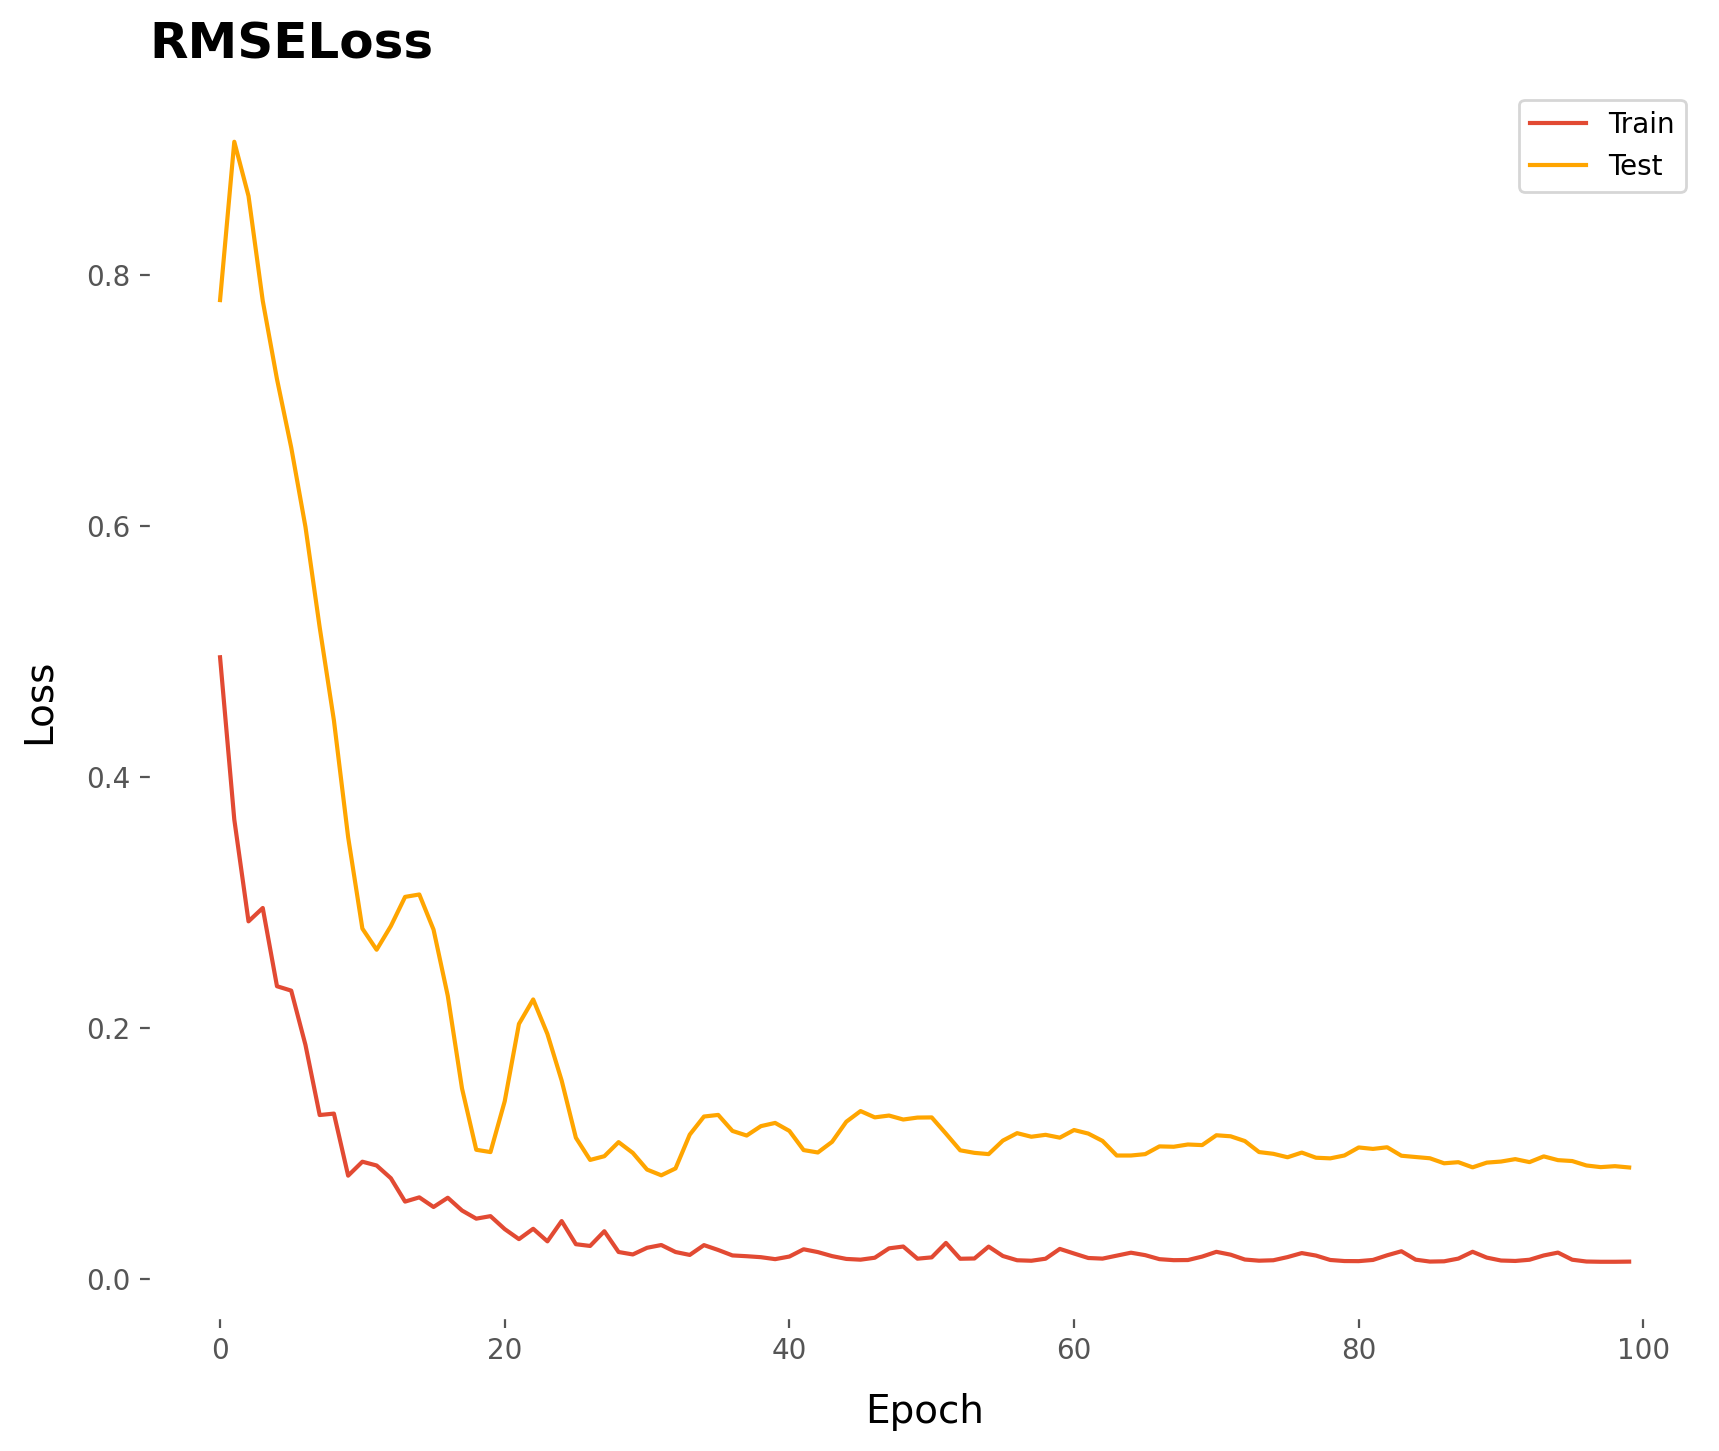

Train loss: 0.01362
Test loss: 0.08866


In [ ]:
seed_everything()
train_loss_lstm_with, test_loss_lstm_with = \
    train(lstm_model, criterion, optimizer, device, X_train_with, y_train_without,
          X_test_with, y_test_without, n_epochs=100)

In [ ]:
y_pred_train_lstm_with, y_train_lstm_with, y_pred_test_lstm_with, y_test_lstm_with = \
    get_predictions(lstm_model, scaler_without, X_train_with, y_train_with, X_test_with, y_test_with)

In [ ]:
eval_losses(y_pred_train_lstm_with, y_train_lstm_with, y_pred_test_lstm_with,
            y_test_lstm_with)

Train RMSE = 151.46
Train MAE = 8020.5
Train SMAPE = 1.2455

Test RMSE = 307.02
Test MAE = 4990.509
Test SMAPE = 3.0956

R_sq = 0.7943192487661481


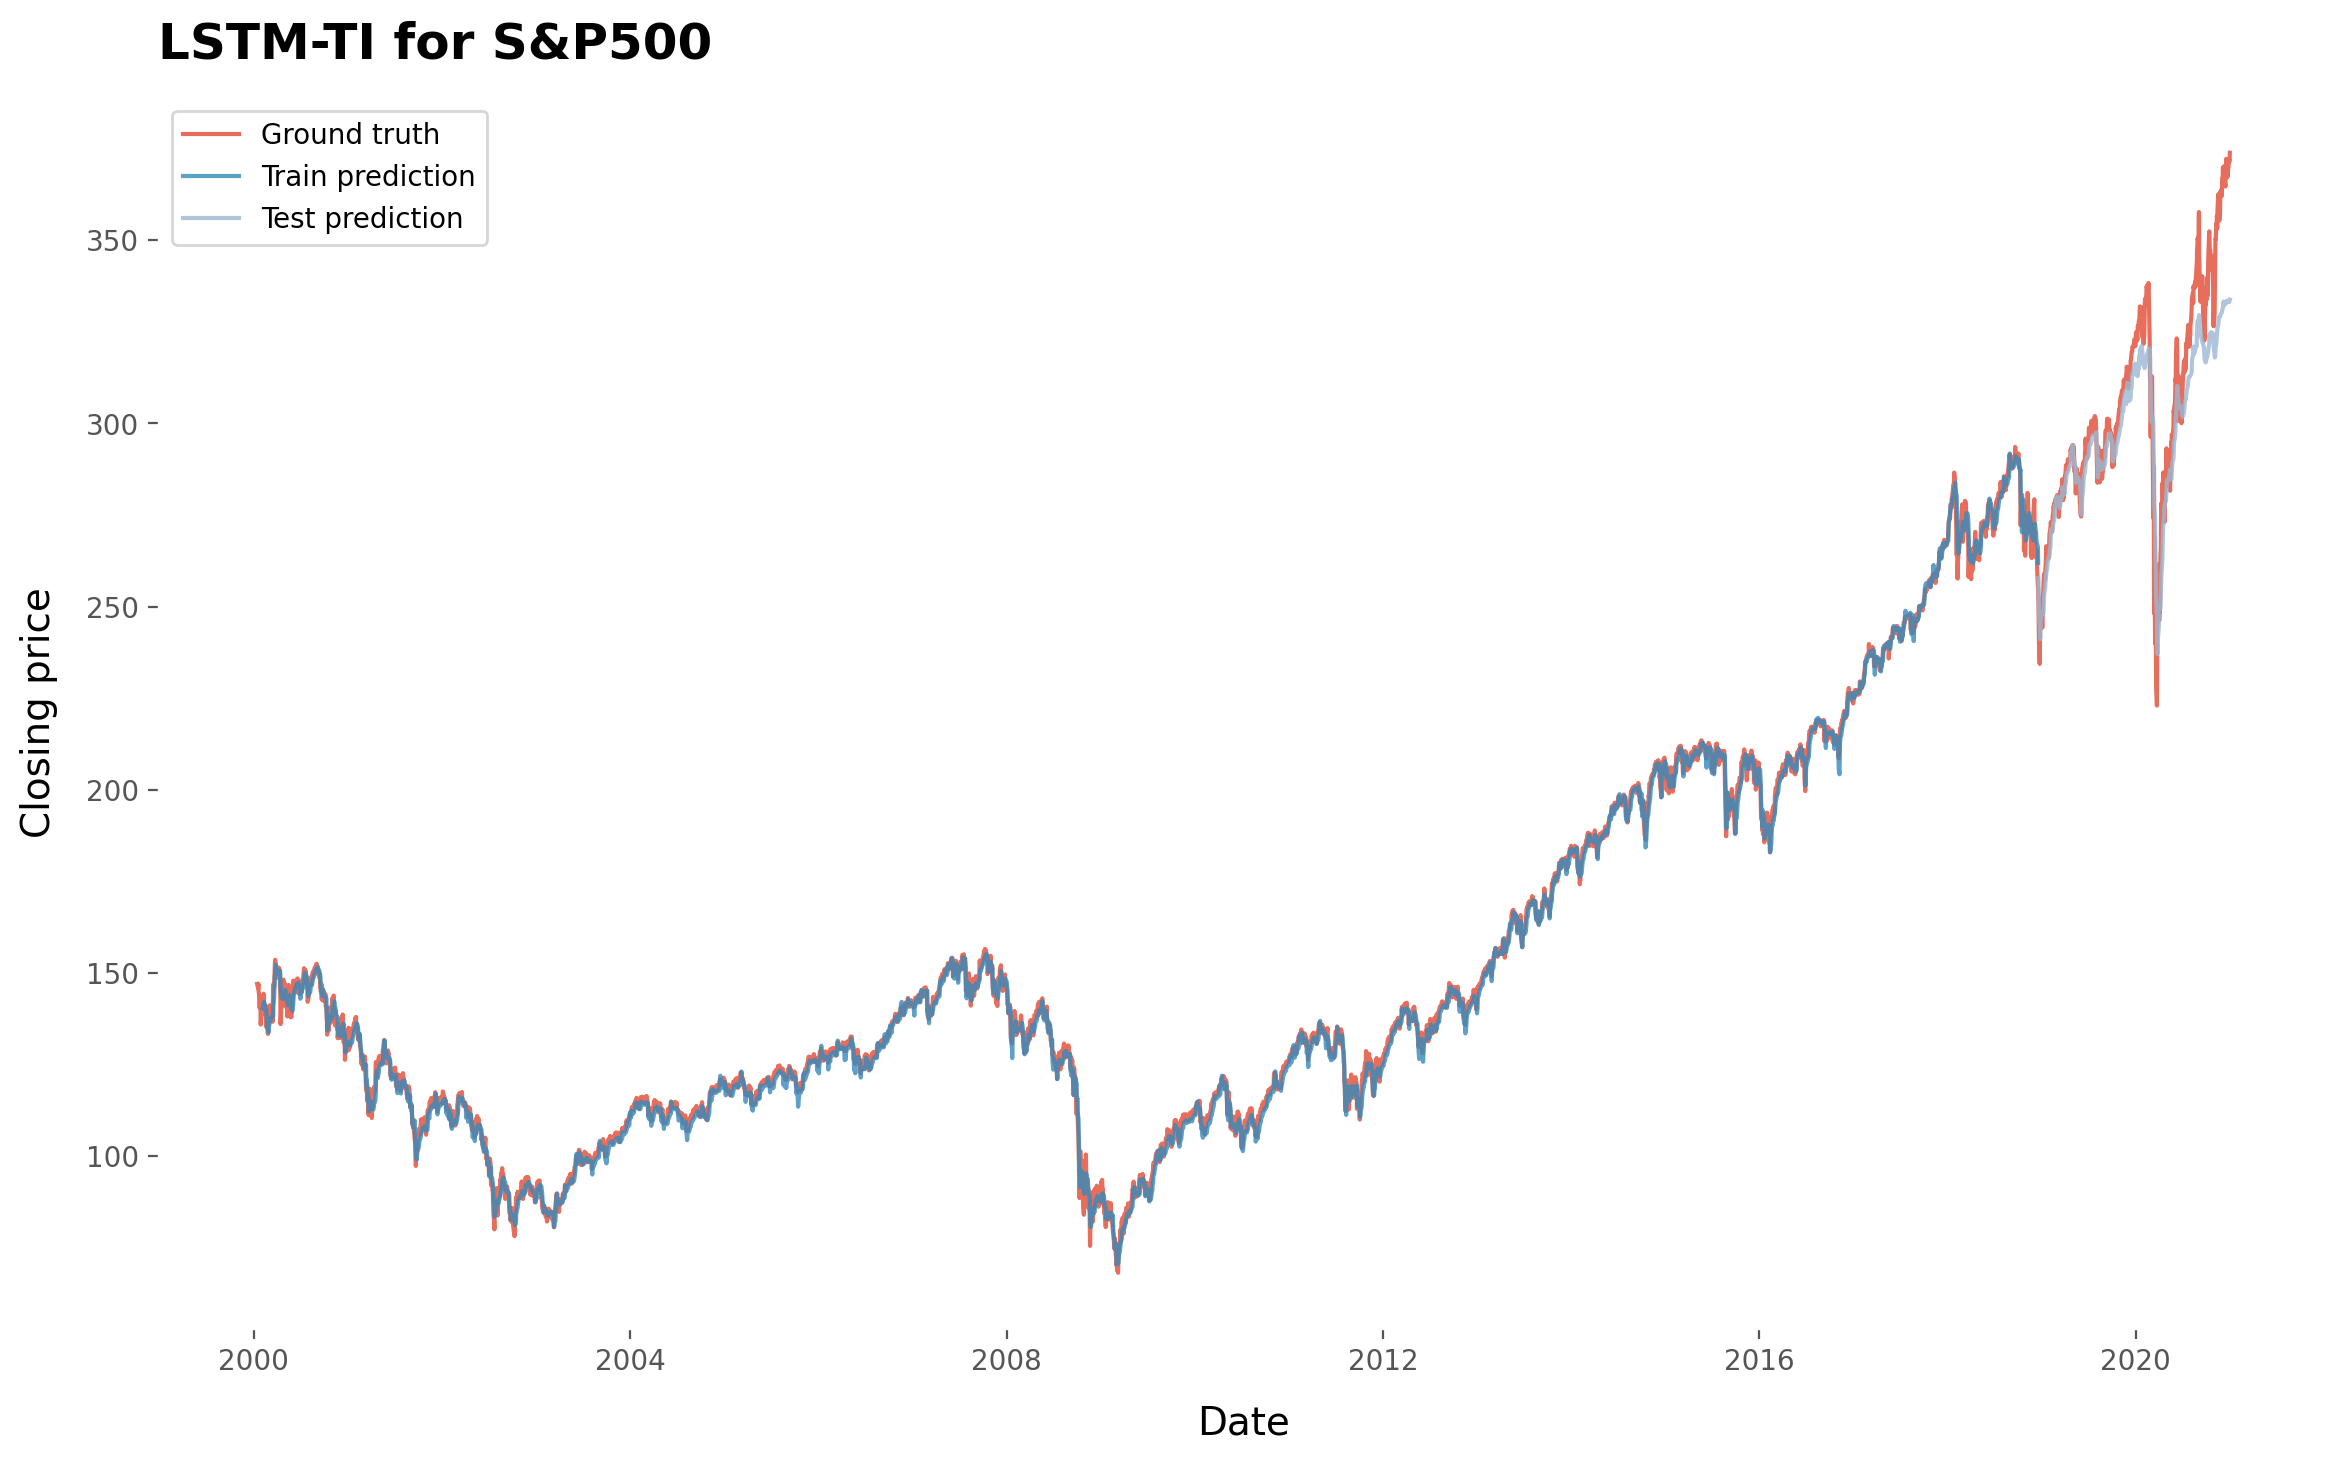

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(f'LSTM-TI for S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth', alpha=0.8)

plt.plot(df.index[window_size-1:val_size+train_size+window_size-1],
         y_pred_train_lstm_with.ravel(),
         label='Train prediction', alpha=0.8)

plt.plot(df.index[val_size+train_size+window_size-1:],
         y_pred_test_lstm_with.ravel(),
         label='Test prediction', color='#9BB7D4', alpha=0.8)

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

## Metaheuristic Optimization

Optimal hyperparameters, $\Theta$, of a RNN model that are set before training the neural network, such as a number of neurons and their size, are difficult to determine. Hence, we use a metaheuristic optimization technique to find a good approximation of the global minimum, in contrast to deterministic optimization methods that almost virtually find a local rather than a global optimum solution.

### Without Technicals

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_without = MinMaxScaler(feature_range=(-1, 1))
data_preproc = torch.tensor(scaler_without.fit_transform(data.reshape(-1, 1))).reshape(1, -1).type(torch.Tensor)

In [ ]:
batch_windows = data_preproc.unfold(dimension=-1, size=window_size, step=1).reshape(-1, window_size, 1)

X_train_without = batch_windows[:train_size, :-1, :]
X_val_without = batch_windows[train_size:train_size+val_size, :-1]
X_test_without = batch_windows[train_size+val_size:, :-1]

# Need predict the next value considering 14 lookback periods
y_train_without = batch_windows[:train_size, -1, :]
y_val_without = batch_windows[train_size:train_size+val_size, -1, :]
y_test_without = batch_windows[train_size+val_size:, -1, :]

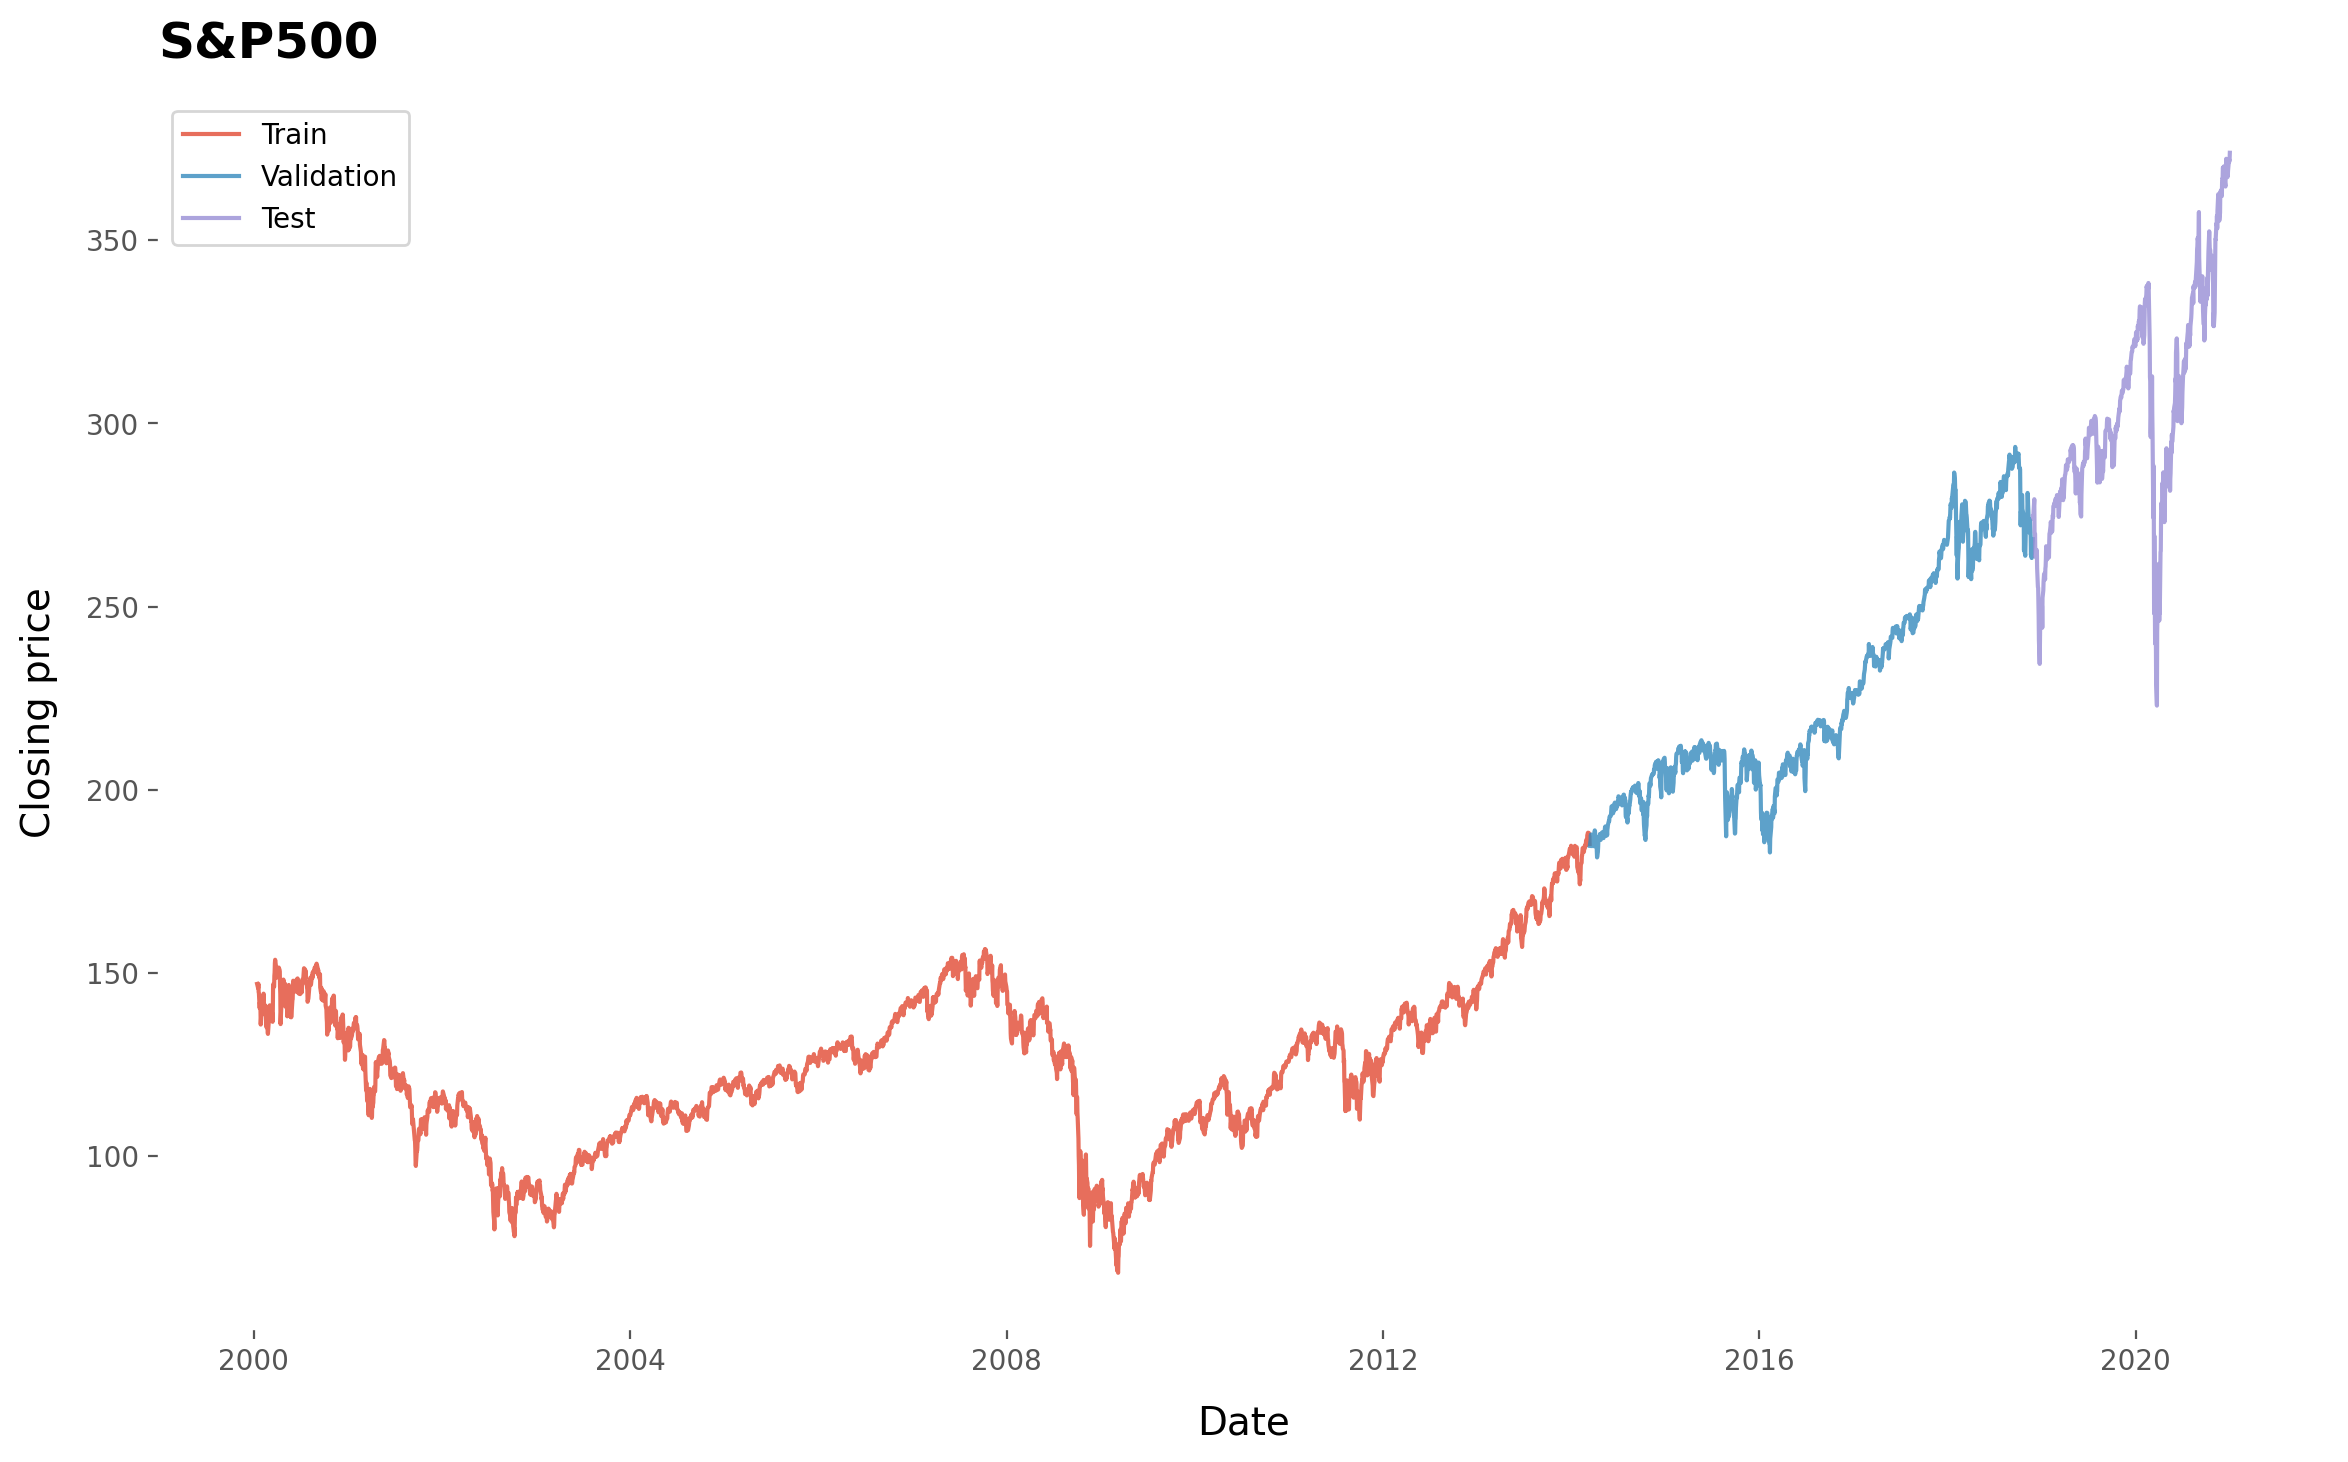

In [ ]:
plt.figure(figsize=(14, 8))
plt.title('S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index[:train_size],
         df['Close'][:train_size],
         label='Train', alpha=0.8)

plt.plot(df.index[train_size:train_size+val_size],
         df['Close'][train_size:train_size+val_size],
         label='Validation', alpha=0.8)

plt.plot(df.index[train_size+val_size:],
         df['Close'][train_size+val_size:],
         label='Test', alpha=0.8)

plt.grid(False)
plt.legend()

plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

### With Technicals

In [ ]:
scaler_with = MinMaxScaler(feature_range=(-1, 1))
data_preproc = torch.tensor(scaler_with.fit_transform(df)).type(torch.Tensor)
data_preproc_t = data_preproc.transpose(-2, -1)

windows = []

for i in range(data_preproc.shape[1]):
    windows.append(data_preproc_t.unfold(dimension=-1, size=window_size, step=1)[i].reshape(-1, window_size, 1))

batch_windows = torch.cat((windows), dim=2)

X_train_with = batch_windows[:train_size, :-1, :]
X_val_with = batch_windows[train_size:train_size+val_size, :-1]
X_test_with = batch_windows[train_size+val_size:, :-1]

# Need predict the next value considering 14 lookback periods
y_train_with = y_train_without
y_val_with = y_val_without
y_test_with = y_test_without

In [ ]:
X_val_with = batch_windows[train_size:train_size+val_size, :-1]

### Genetic Algorithm

Genetic algorithm (GA) is a population-based metaheuristic optimization algorithm proposed by Holland (Holland, 1984). The GA imitates the process of natural evolution in solving an optimization problem by relying on biologically inspired operations such as natural selection, mutation, and crossover.

<center><img src="https://github.com/khaykingleb/Stock-Price-Forecasting/blob/main/img/ga_algorithm.svg?raw=1"/></center>

Let our population $ \Theta$ has $\displaystyle \ell $ individuals with chromosomes $\{\theta_i\}_{i=1}^\ell$, as represented in the first figure, where a chromosome $\theta_i \in \mathbb{R}^p$ is a set of $p$ hyperparameters, and a hyperparameter is called a gene. Then, the population at the time step $\displaystyle k$ is written as follows:
$$ \Theta _{k} =\left\{\theta _{i}^{( k)} \mid \left( \theta _{i1}^{( k)} ,\dotsc ,\theta _{ip}^{( k)]}\right) \in \mathbb{R}^{p}\right\}_{i=1}^{\ell }$$

<center><img src="https://github.com/khaykingleb/Stock-Price-Forecasting/blob/main/img/ga_population.svg?raw=1"/></center>

Now let us look at the algorithm itself:

1.   We randomly generate the first population of individuals:
$$\Theta_{0} =\left\{\left(\theta_{1}^{( 0)}, \dotsc, \theta_{\ell}^{( 0)}\right) \in \mathbb{R}^{\ell\times d} \mid \theta _{ij}^{( 0)} \sim U(\alpha, \beta )\right\}$$

2. Then assess the fitness of each individual. For this, we need to calculate the values of the objective function for each chromosome
$$\mathcal{L}_{k} =\left\{Q\left( \theta _{i}^{( k)}\right)\right\}_{i=1}^{\ell }$$
and apply a transformation function
$$\sigma ( z) =\dfrac{z-\mathcal{L}_{k}^{worst}}{\mathcal{L}_{k}^{best} -\mathcal{L}_{k}^{worst}}$$
such that its components lie between zero and one. For instance, if an individual $z$ has near-one value, it means that it has high fitness relative to other. Hence, we get the values of the fitness function of individuals $ \mathcal {F}_{k} = \left\{\sigma \left(\mathcal {L}_{k}\left(\theta^{(k)}_i\right)\right)\right\}_{i=1}^\ell $.
3. Select the most fitted $m$ individuals for further breeding. For this, we assume that an individual $\xi$ is better fitted than an individual $\eta$ if $\mathcal{F}_{k}(\xi)= \sigma(Q(\xi)) > \sigma(Q(\eta)) = \mathcal{F}_{k}(\eta)$. Then, we rank individuals in the current population according to their fitness values in descending order, that is from the most fitted to the less:
$$\mathcal{F}_{k}^{[ 1]} \geqslant \dotsc \geqslant \mathcal{F}_{k}^{[ m]} \geqslant \dotsc \geqslant \mathcal{F}_{k}^{[ \ell ]}$$

4. Crossover the fittest $m$ individuals with everyone else. This is how we spread the "good" genes throughout the population. By crossover we mean the operation of creating a new chromosome, wherein a part of the genes will be from the high fitted individual $\displaystyle \xi ^{( k)} \in \left\{\theta _{i}^{( k)}\right\}_{i=1}^{m}$ with the probability of
$$\displaystyle \mathbb{P}\left\{ \theta _{i}^{new} =\xi ^{( k)}\right\} =\dfrac{\sigma \left( Q\left( \xi ^{( k)}\right)\right)}{\sigma \left( Q\left( \xi ^{( k)}\right)\right) +\sigma \left( Q\left( \eta ^{( k)}\right)\right)}$$
and of the genes will be from the less fitted individual $\eta ^{( k)} \in \left\{\theta _{i}^{( k)}\right\}_{i=m+1}^{n}$ with the probability of

$$\mathbb{P}\left\{\theta _{i}^{new} =\eta ^{( k)}\right\} =\dfrac{\sigma \left( Q\left( \eta ^{( k)}\right)\right)}{\sigma \left( Q\left( \xi ^{( k)}\right)\right) +\sigma \left( Q\left( \eta ^{( k)}\right)\right)}$$

Thus, we get
$$\theta _{ij}^{new} =\begin{cases} \xi _{j}^{( k)}, & \text{with} \ \mathbb{P}\left\{\theta _{i}^{new} =\xi ^{( k)}\right\}\\ \eta _{j}^{( k)}, & \text{with} \ \mathbb{P}\left\{\theta _{i}^{new} =\eta ^{( k)}\right\} \end{cases} ,\ i\in ( m+1,\dotsc ,n) ,\ j\in ( 1, \dotsc, p)$$

5. All individuals except the best in the current population, $ \left\{\theta _ {i} ^ {(k)} \right \} _ {i = 2} ^ {\ell} $, are mutated. The mutation changes an arbitrary number of genes in an individual's chromosome for other but rather close to the original value, so afterwards we get
$$ \Theta_{k+1} =\left\{\theta _{1}^{( k)}\right\} \cup \left\{\theta _{i}^{( k)} \mid \theta _{ij}^{( k)} =\theta _{ij}^{( k)} +\varepsilon _{j}\right\}_{i=2}^{\ell } $$

6. Go to the step 2 until the stop criterion is met. For instance, it can be a reach of the maximum possible number of population evolutions.

Now, we attempt to choose hyperparameters of our models, that is the correct number of hidden layers and training epochs, the hidden size of neurons, and the learning rate. For this reason, the genetic algorithm is used as a metaheuristic optimizer. Hence, we create a population with $150$ individuals—in our case, Adam optimized neural networks—with the mutation rate of $40\%$ and $10$ meta epochs considered. Moreover, we select the $40$ most fitted individuals to crossover.


![](https://github.com/khaykingleb/Stock-Price-Forecasting/blob/main/scripts/images/ga_rnn.svg?raw=1)



Given that a number of hidden layers can range from $1$ to $15$, training epochs from $60$ to $300$, a hidden size from $8$ to $512$, and a learning rate from $0.001$ to $1$.

#### GA-LSTM

In [ ]:
seed_everything()
# Here k is NOT a time step but m in the equations above!
config = GeneticAlgorithmConfig(ell=150, k=40, num_epochs=10, mutation_rate=0.4)
population = Population(config)

In [ ]:
ga_optimizer = GeneticAlgorithm(optimized_block='LSTM',criterion=criterion,
                                population=population, config=config,
                                device=device, verbose=True)

Epoch: 10


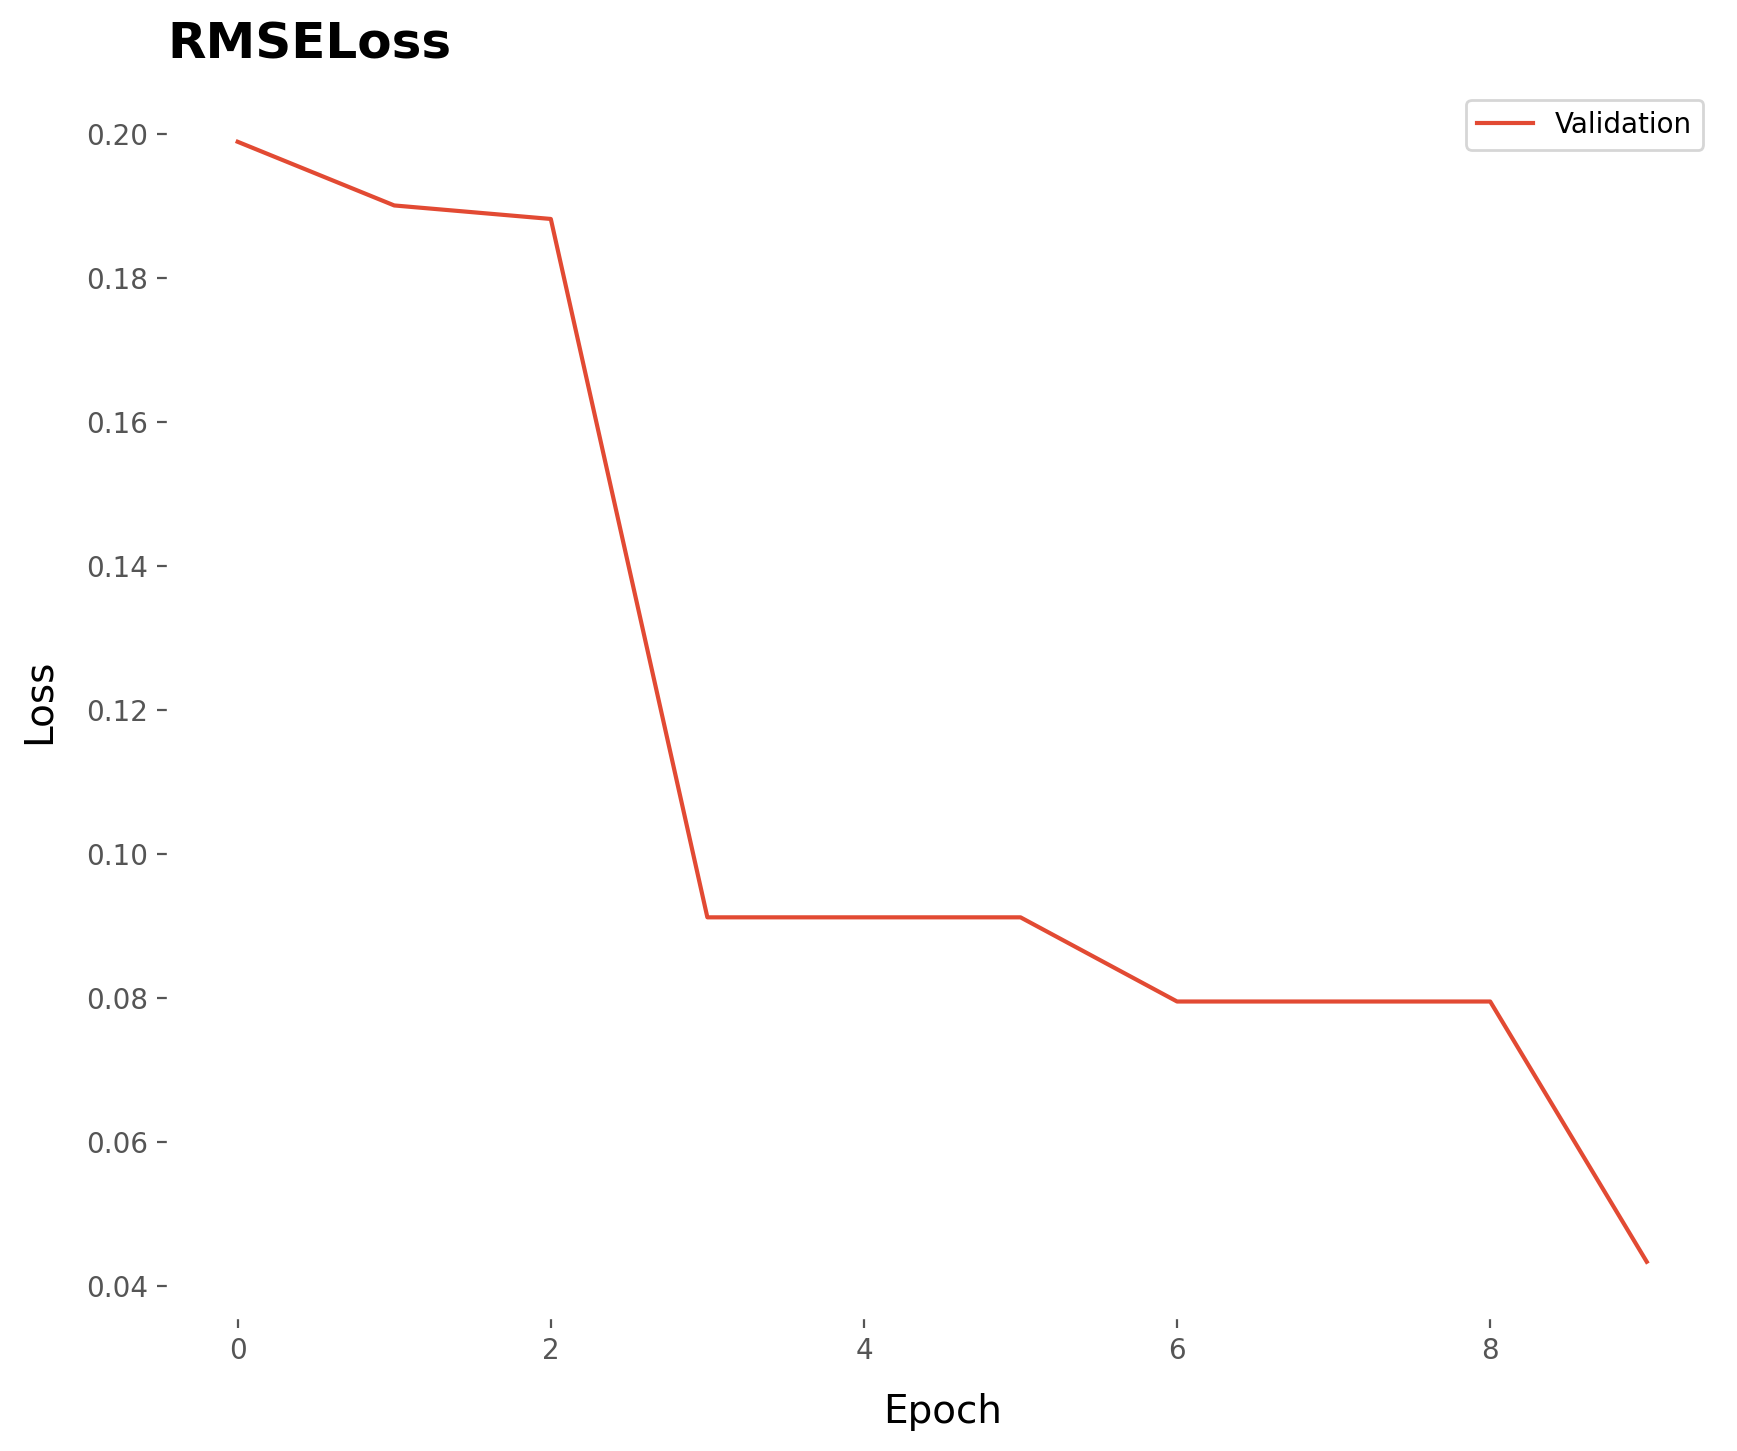

Chromosome #0428142 with the loss of 0.04331 and 65 epochs:
learning_rate = 0.001, num_layers = 3, hidden_size = 512
Chromosome #6668420 with the loss of 0.1995 and 215 epochs:
learning_rate = 0.05, num_layers = 9, hidden_size = 8
Chromosome #8633258 with the loss of 0.2001 and 258 epochs:
learning_rate = 0.081, num_layers = 10, hidden_size = 32
Chromosome #3072132 with the loss of 0.3351 and 288 epochs:
learning_rate = 0.13, num_layers = 5, hidden_size = 32
Chromosome #7584823 with the loss of 0.1266 and 162 epochs:
learning_rate = 0.1, num_layers = 2, hidden_size = 32
Chromosome #7584823 with the loss of 0.1266 and 162 epochs:
learning_rate = 0.1, num_layers = 2, hidden_size = 32
Chromosome #7584823 with the loss of 0.1266 and 162 epochs:
learning_rate = 0.1, num_layers = 2, hidden_size = 32
Chromosome #7458641 with the loss of 0.07949 and 186 epochs:
learning_rate = 0.05, num_layers = 2, hidden_size = 16
Chromosome #7458641 with the loss of 0.07949 and 186 epochs:
learning_rate = 0.

In [ ]:
ga_optimizer.fit(X_val_without, y_val_without)

In [ ]:
seed_everything()
ga_lstm_model = LSTM(input_size=X_train_without.shape[2],
                     hidden_size=ga_optimizer.population.best_indivdual.hidden_size,
                     num_layers=ga_optimizer.population.best_indivdual.num_layers)
ga_lstm_model.to(device)

LSTM(
  (lstm): LSTM(1, 512, num_layers=3, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(ga_lstm_model.parameters(),
                             lr=ga_optimizer.population.best_indivdual.learning_rate)

Epoch: 65


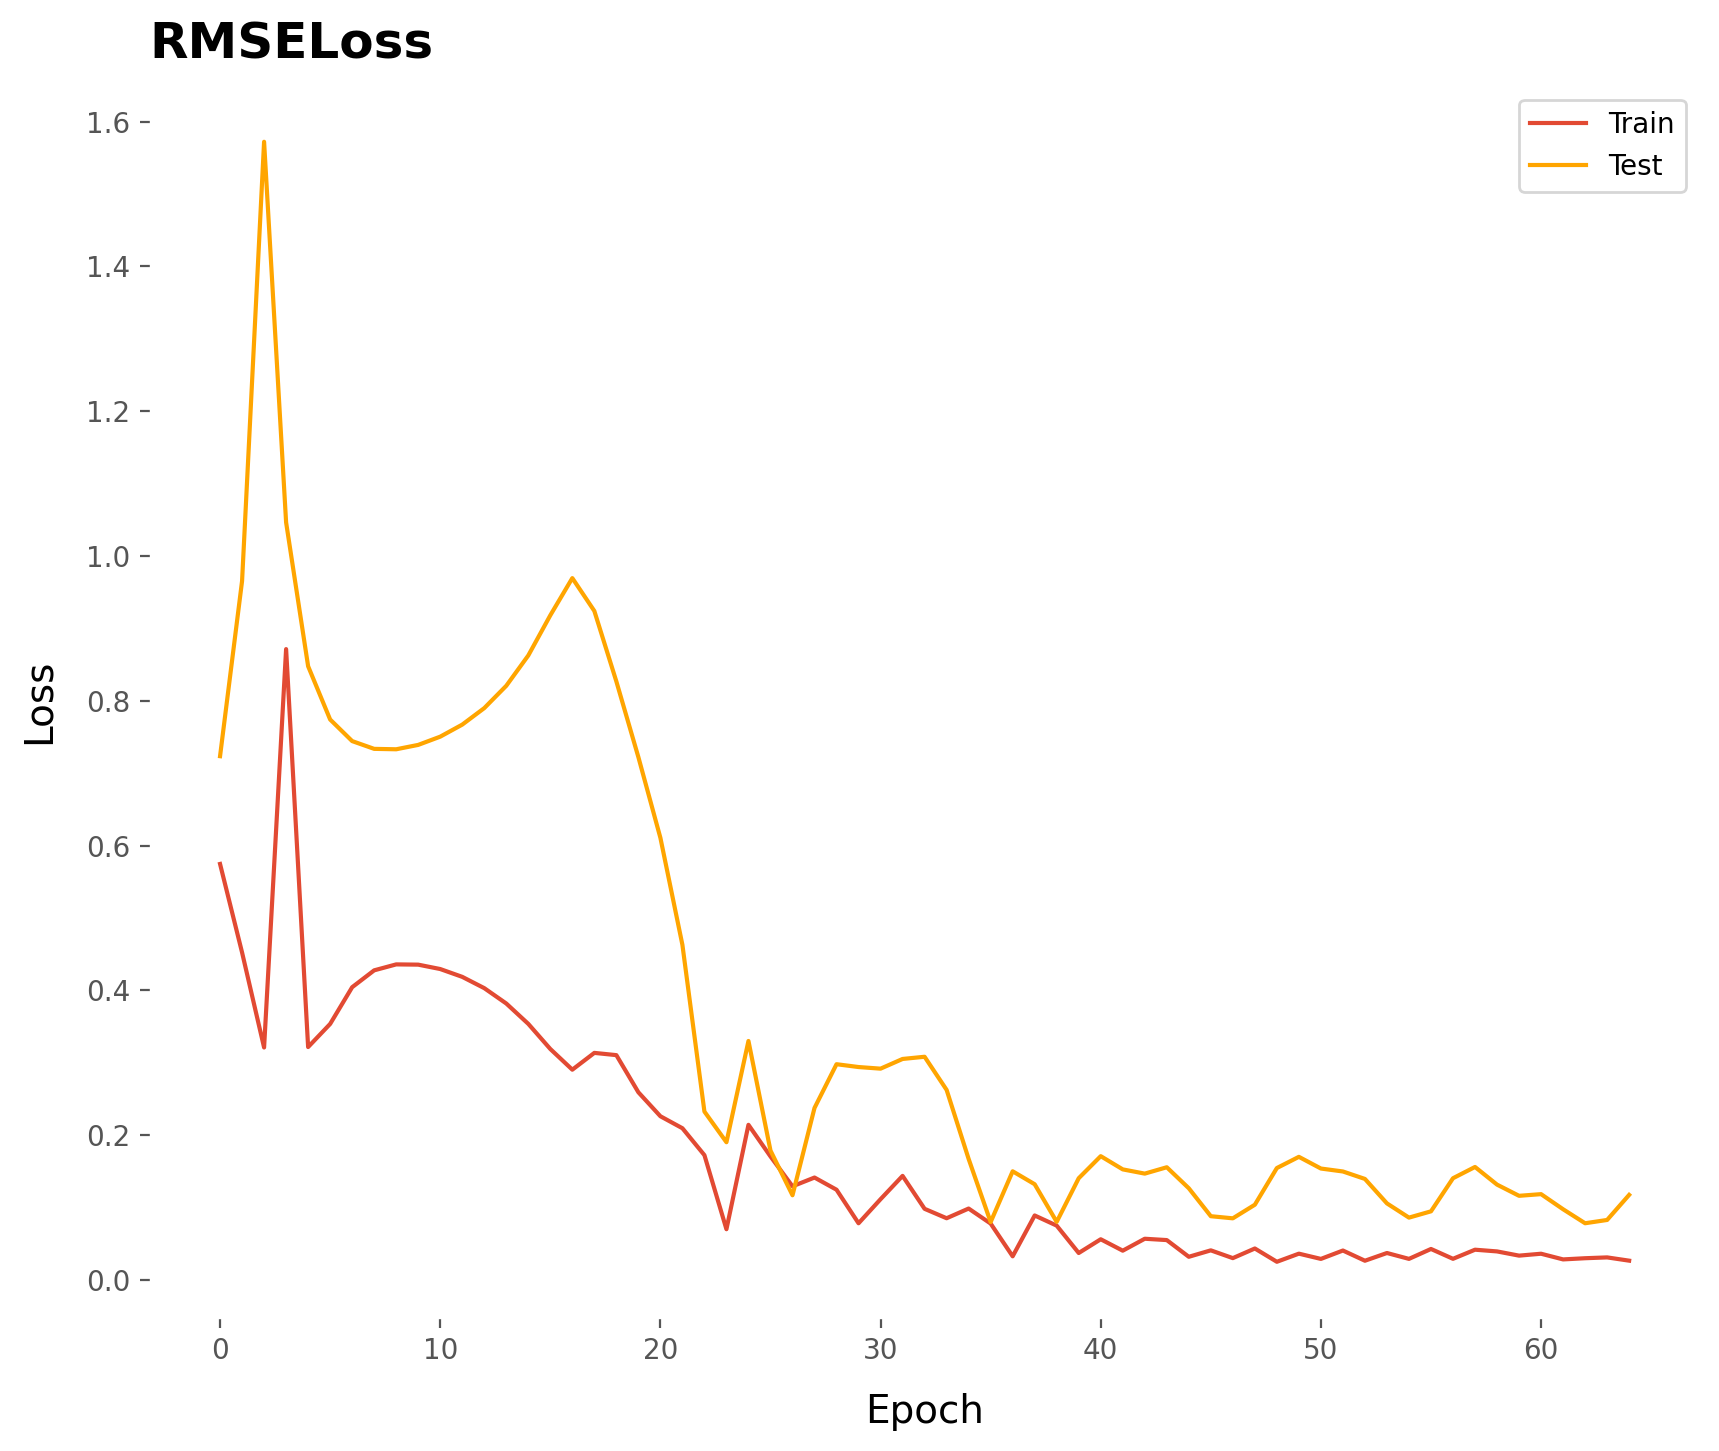

Train loss: 0.02668
Test loss: 0.1175


In [ ]:
seed_everything()
train_loss_ga_lstm_without, test_loss_ga_lstm_without = \
    train(ga_lstm_model, criterion, optimizer, device,
          torch.vstack((X_train_without, X_val_without)),
          torch.vstack((y_train_without, y_val_without)),
          X_test_without, y_test_without,
          n_epochs=ga_optimizer.population.best_indivdual.num_epochs_base)

In [ ]:
y_pred_train_ga_lstm_without, y_train, y_pred_test_ga_lstm_without, y_test = \
    get_predictions(ga_lstm_model, scaler_without,
                    torch.vstack((X_train_without, X_val_without)),
                    torch.vstack((y_train_without, y_val_without)),
                    X_test_without, y_test_without)

In [ ]:
eval_losses(y_pred_train_ga_lstm_without, y_train,
            y_pred_test_ga_lstm_without, y_test)

Train RMSE = 333.01
Train MAE = 1.7564e+04
Train SMAPE = 2.8974

Test RMSE = 407.02
Test MAE = 7726.552
Test SMAPE = 4.9094

R_sq = 0.6385226310405159


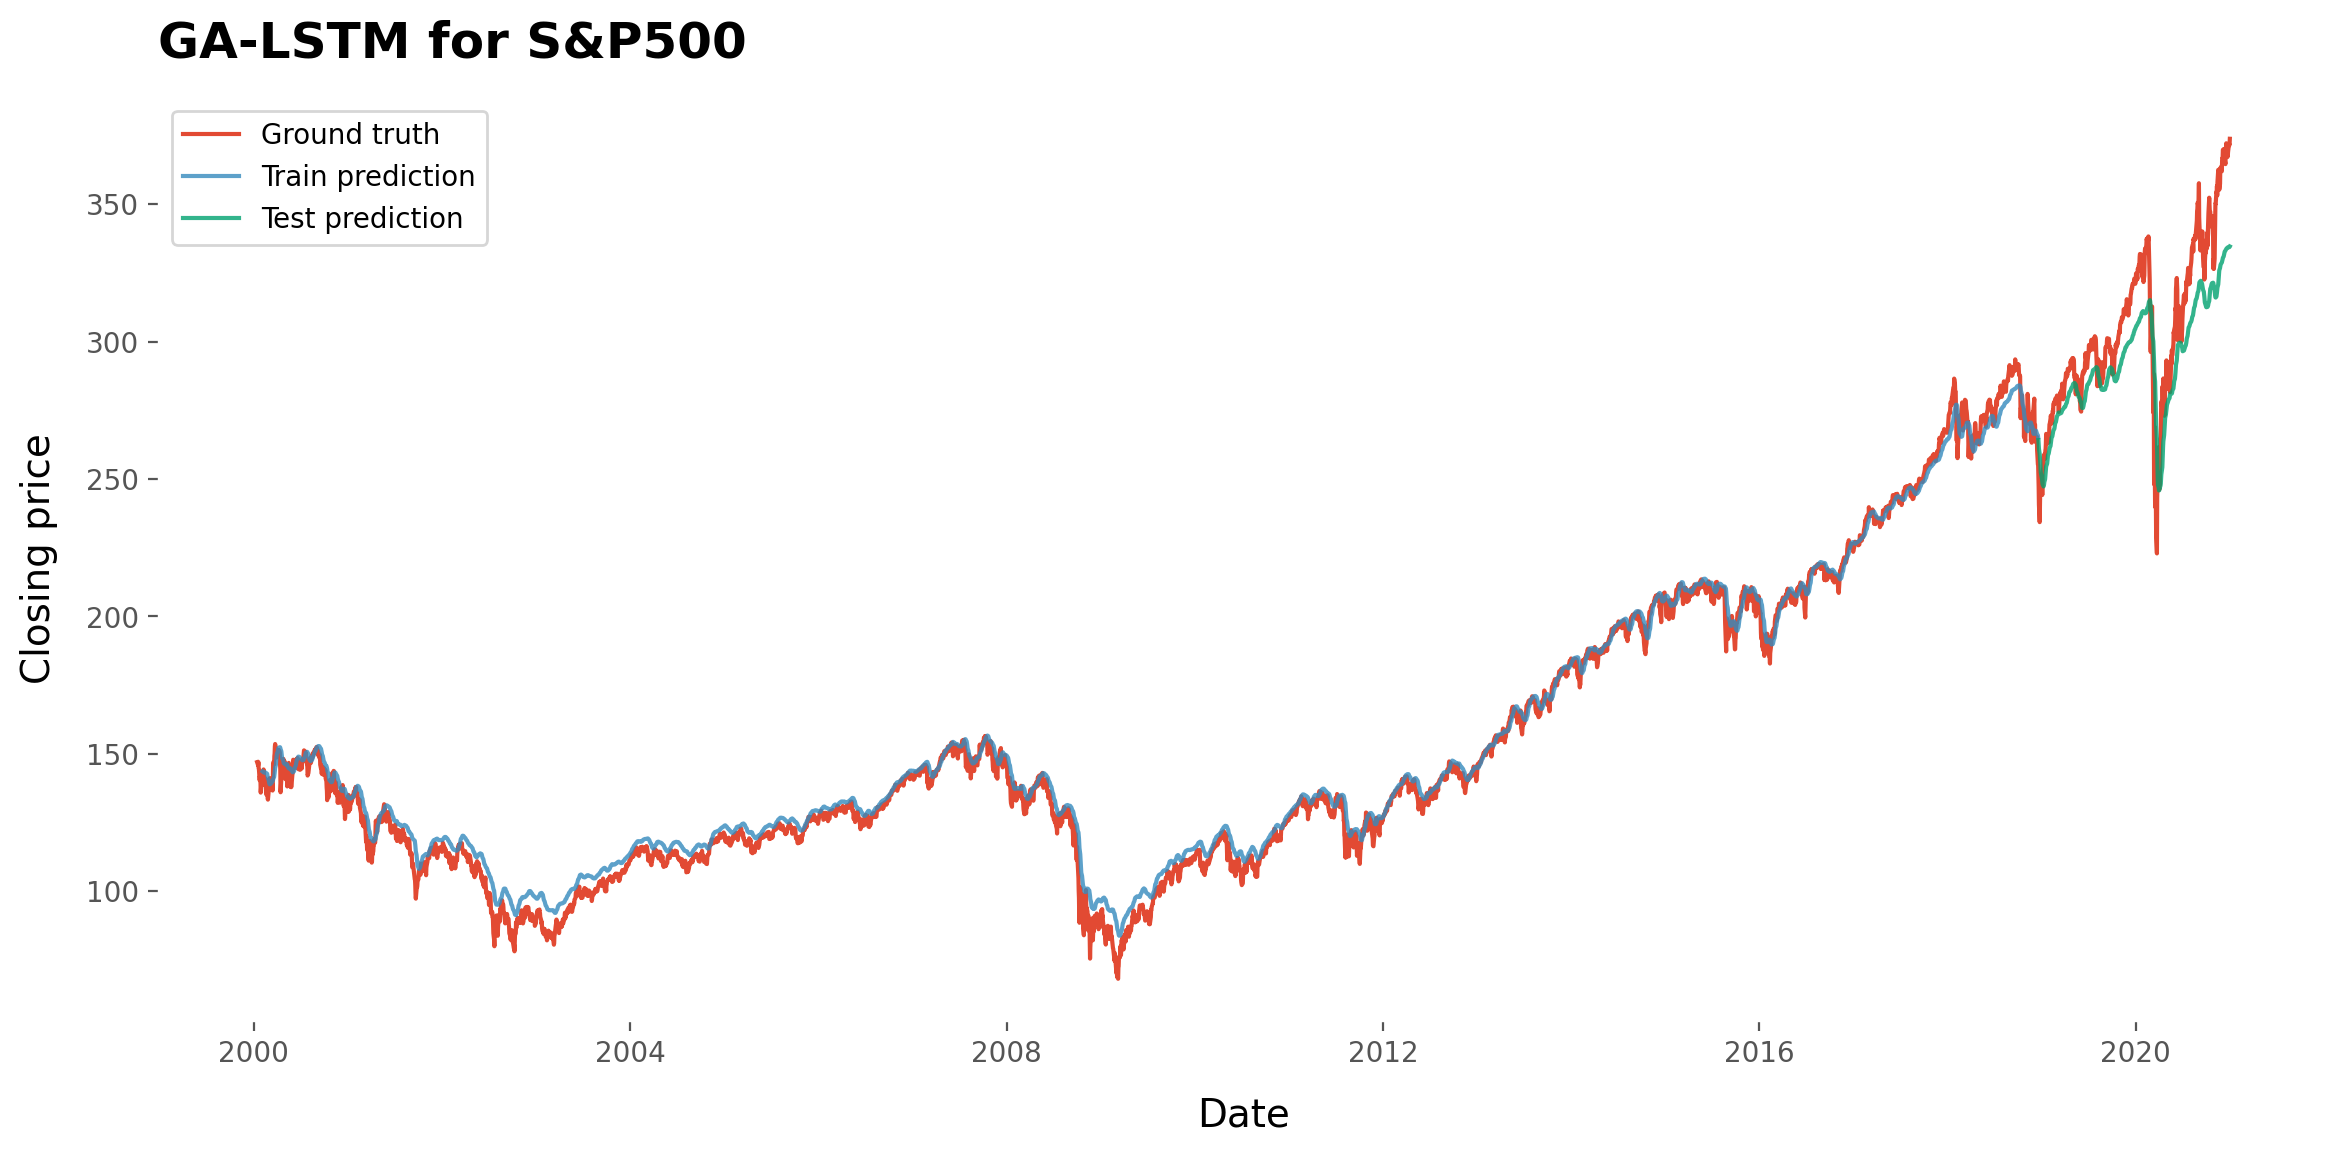

In [ ]:
plt.figure(figsize=(14, 6))
plt.title(f'GA-LSTM for S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth')
plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], y_pred_train_ga_lstm_without.ravel(), label='Train prediction', alpha=0.8)
plt.plot(df.index[val_size+train_size+window_size-1:], y_pred_test_ga_lstm_without.ravel(), label='Test prediction', color='#00A170', alpha=0.8)

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

#### GA-LSTM-TI

In [ ]:
seed_everything()
config = GeneticAlgorithmConfig(ell=150, k=40, num_epochs=10, mutation_rate=0.4)
population = Population(config)

In [ ]:
ga_optimizer = GeneticAlgorithm(optimized_block='LSTM',criterion=criterion,
                                population=population, config=config,
                                device=device, verbose=True)

Epoch: 10


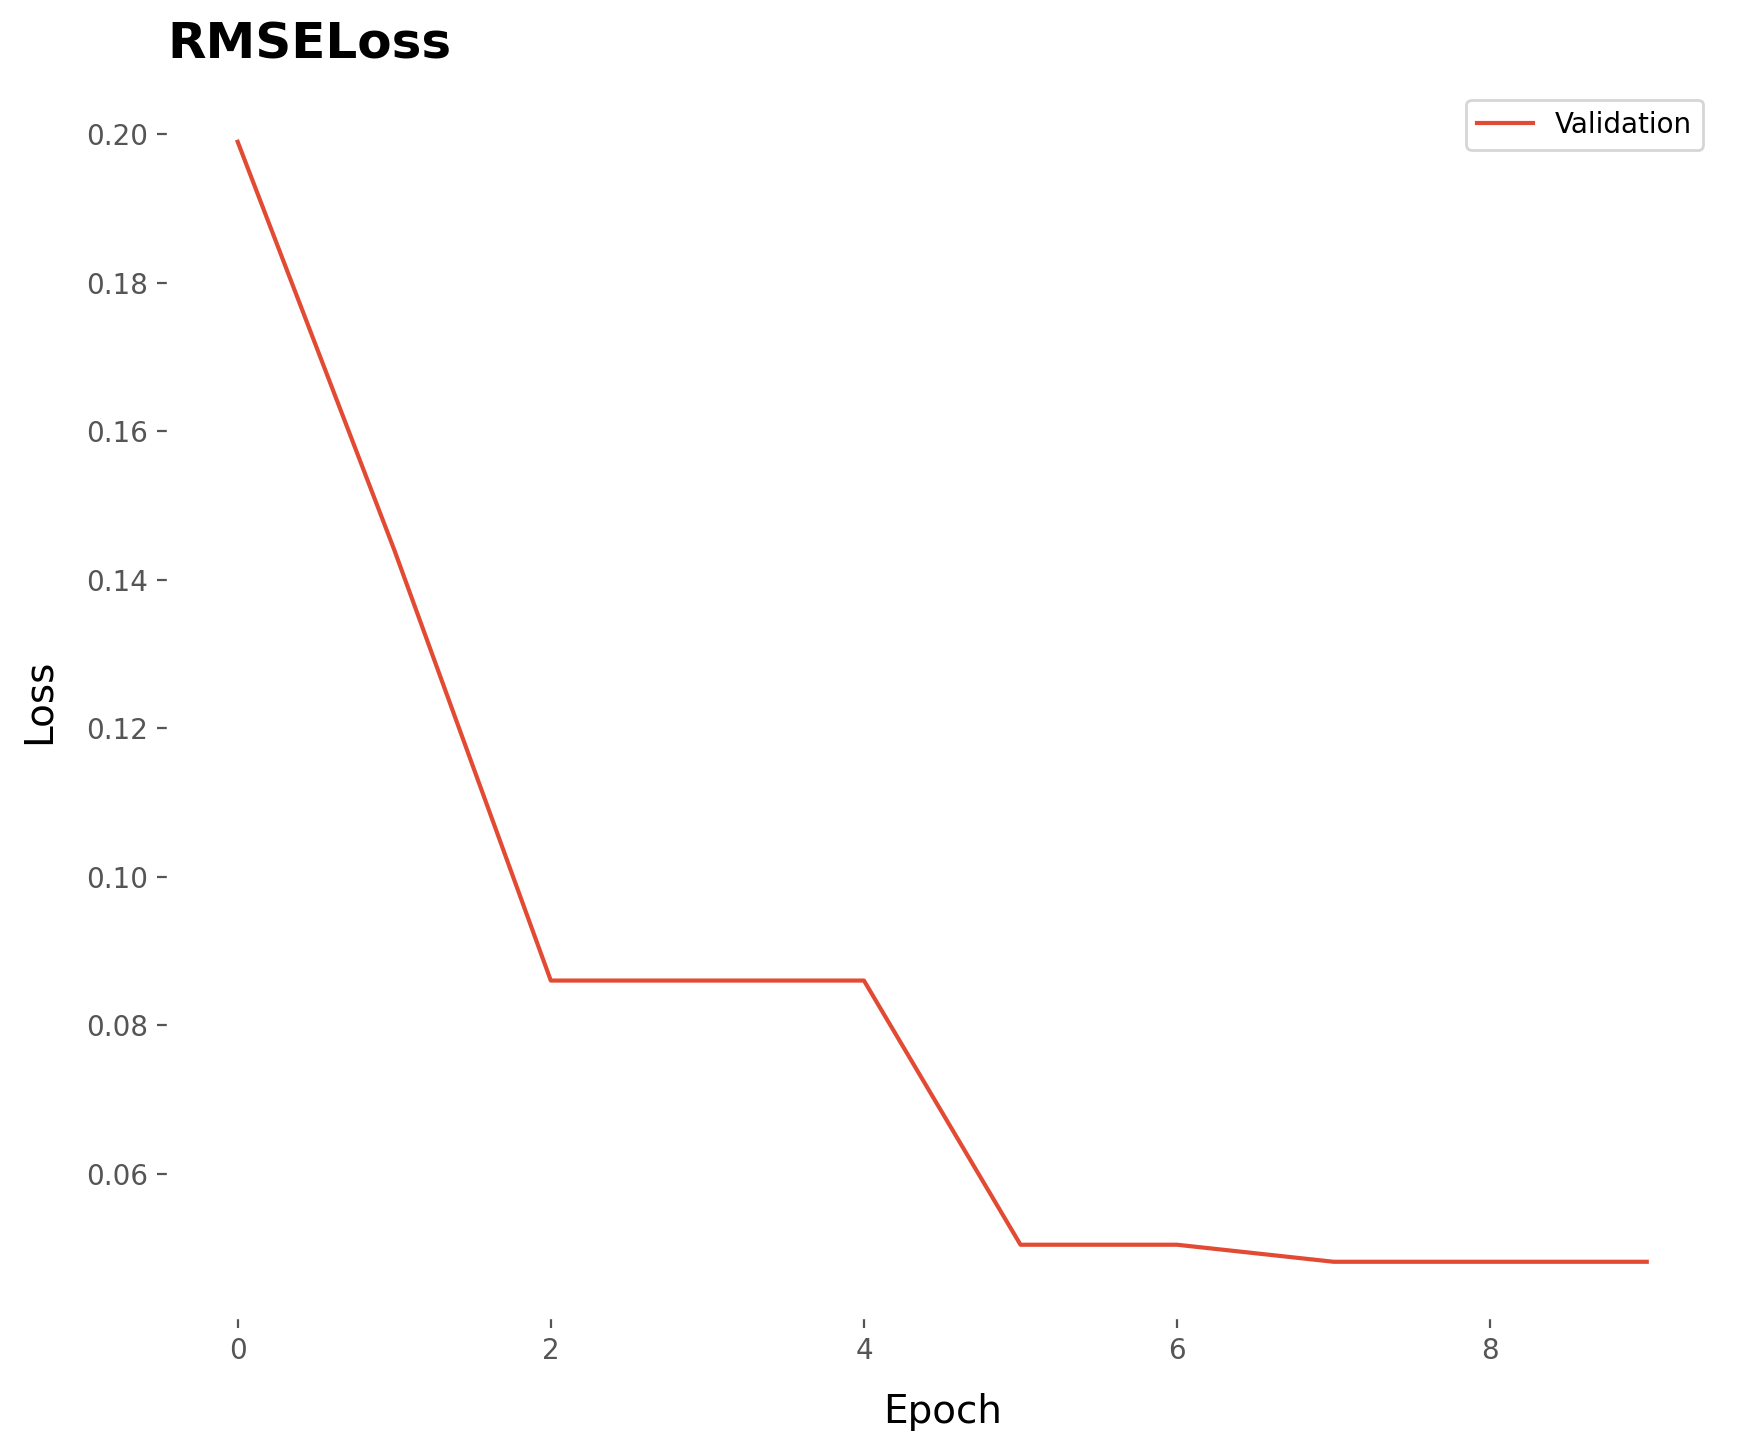

Chromosome #2425052 with the loss of 0.04818 and 260 epochs:
learning_rate = 0.031, num_layers = 2, hidden_size = 8
Chromosome #1323810 with the loss of 1.695 and 299 epochs:
learning_rate = 0.03, num_layers = 8, hidden_size = 128
Chromosome #0877534 with the loss of 0.2002 and 239 epochs:
learning_rate = 0.001, num_layers = 6, hidden_size = 16
Chromosome #1050252 with the loss of 0.2008 and 266 epochs:
learning_rate = 0.03, num_layers = 5, hidden_size = 8
Chromosome #1050252 with the loss of 0.2008 and 266 epochs:
learning_rate = 0.03, num_layers = 5, hidden_size = 8
Chromosome #1050252 with the loss of 0.2008 and 266 epochs:
learning_rate = 0.03, num_layers = 5, hidden_size = 8
Chromosome #2162587 with the loss of 0.05048 and 222 epochs:
learning_rate = 0.03, num_layers = 2, hidden_size = 8
Chromosome #2162587 with the loss of 0.05048 and 222 epochs:
learning_rate = 0.03, num_layers = 2, hidden_size = 8
Chromosome #2425052 with the loss of 0.04818 and 260 epochs:
learning_rate = 0.03

In [ ]:
ga_optimizer.fit(X_val_with, y_val_with)

In [ ]:
seed_everything()
ga_lstm_model = LSTM(input_size=X_train_with.shape[2],
                     hidden_size=ga_optimizer.population.best_indivdual.hidden_size,
                     num_layers=ga_optimizer.population.best_indivdual.num_layers)
ga_lstm_model.to(device)

LSTM(
  (lstm): LSTM(12, 8, num_layers=2, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(ga_lstm_model.parameters(),
                             lr=ga_optimizer.population.best_indivdual.learning_rate)

Epoch: 260


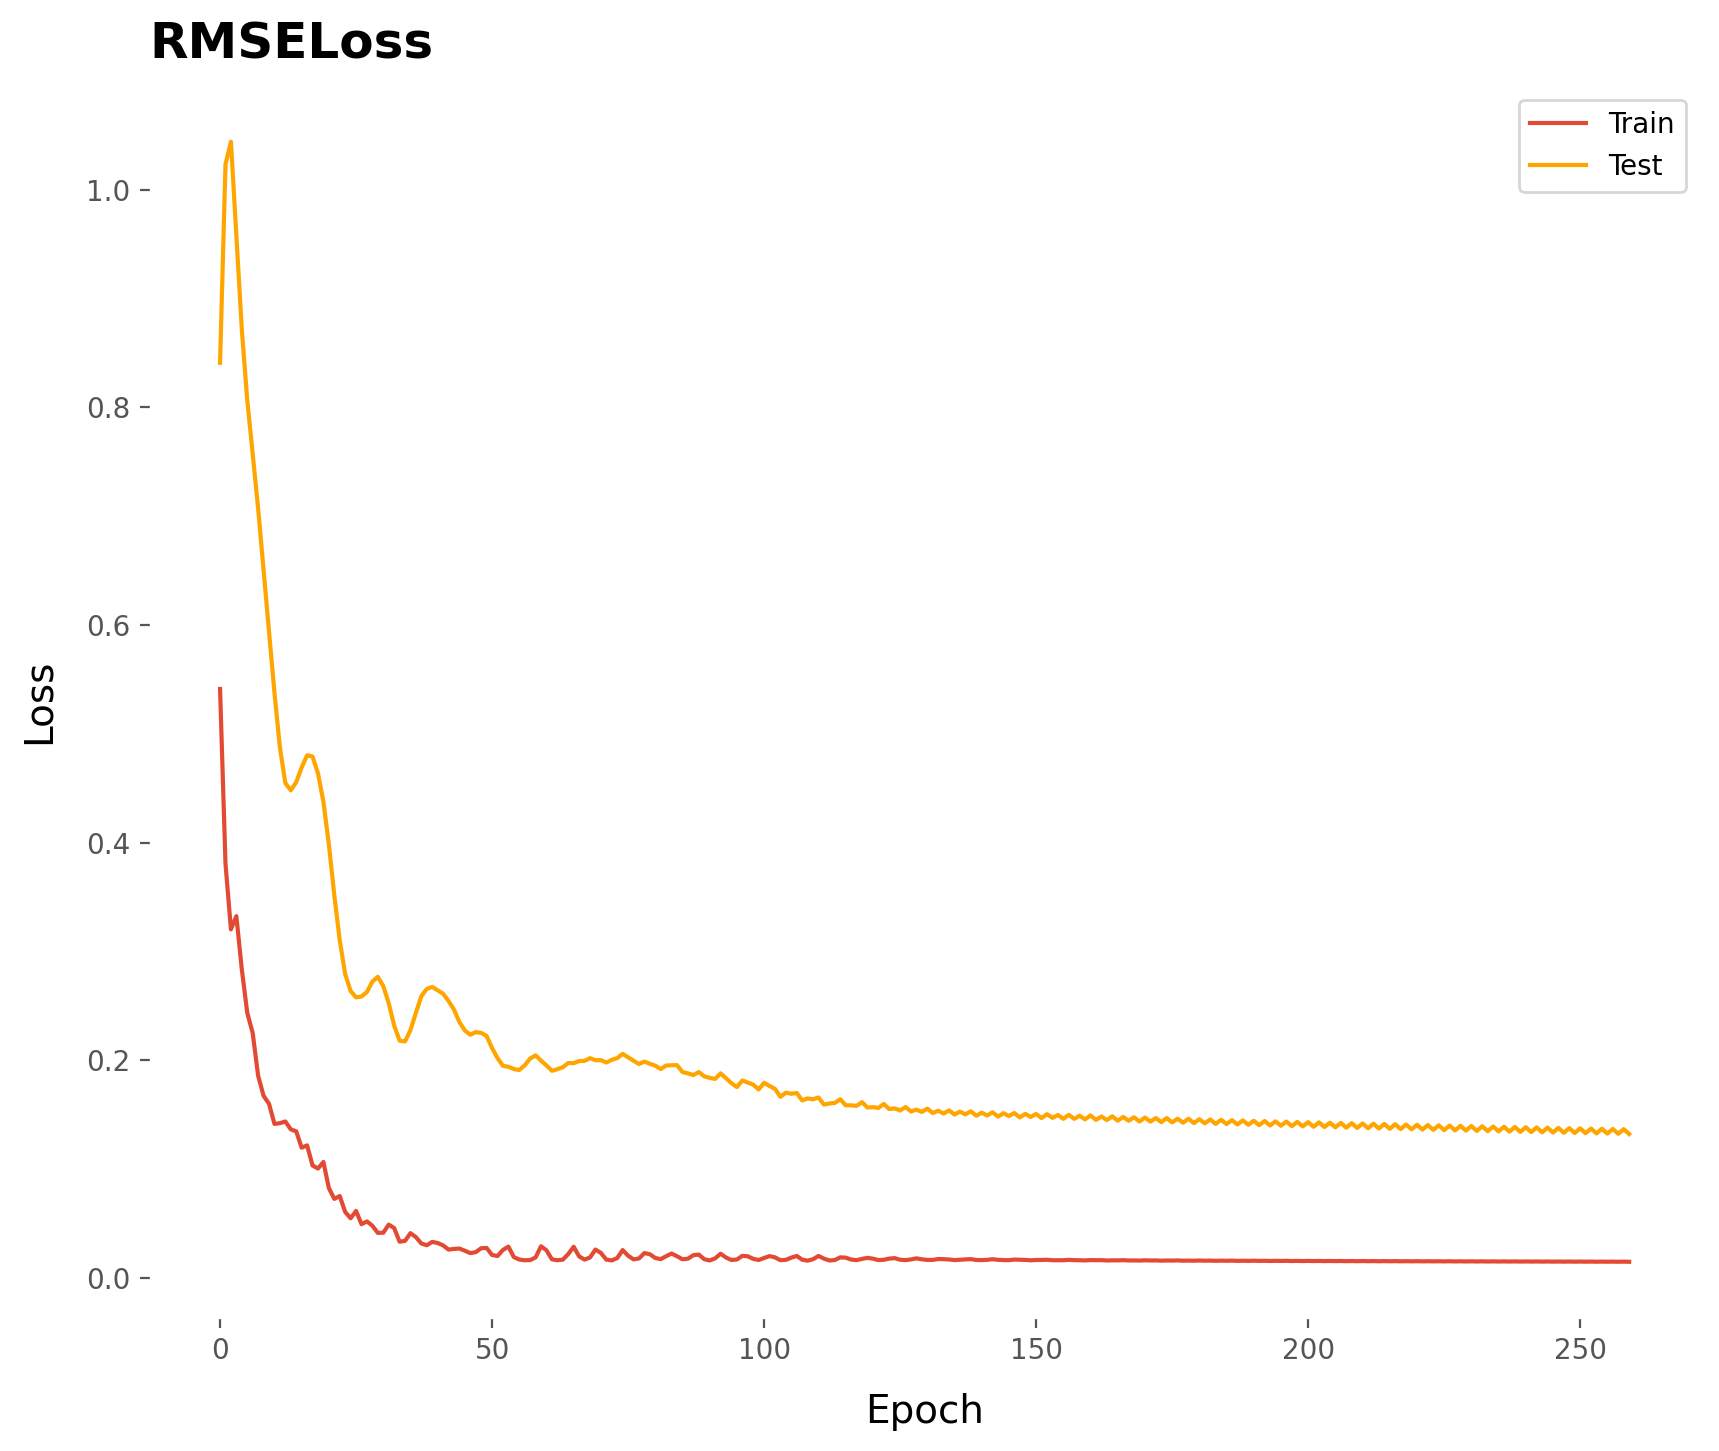

Train loss: 0.0147
Test loss: 0.1322


In [ ]:
seed_everything()
train_loss_ga_lstm_with, test_loss_ga_lstm_with = \
    train(ga_lstm_model, criterion, optimizer, device,
          torch.vstack((X_train_with, X_val_with)),
          torch.vstack((y_train_with, y_val_with)),
          X_test_with, y_test_with,
          n_epochs=ga_optimizer.population.best_indivdual.num_epochs_base)

In [ ]:
y_pred_train_ga_lstm_with, y_train, y_pred_test_ga_lstm_with, y_test = \
    get_predictions(ga_lstm_model, scaler_without,
                    torch.vstack((X_train_with, X_val_with)),
                    torch.vstack((y_train_with, y_val_with)),
                    X_test_with, y_test_with)

In [ ]:
eval_losses(y_pred_train_ga_lstm_with, y_train,
            y_pred_test_ga_lstm_with, y_test)

Train RMSE = 155.87
Train MAE = 8147.9
Train SMAPE = 1.2899

Test RMSE = 457.69
Test MAE = 6910.409
Test SMAPE = 4.257

R_sq = 0.5429173132091087


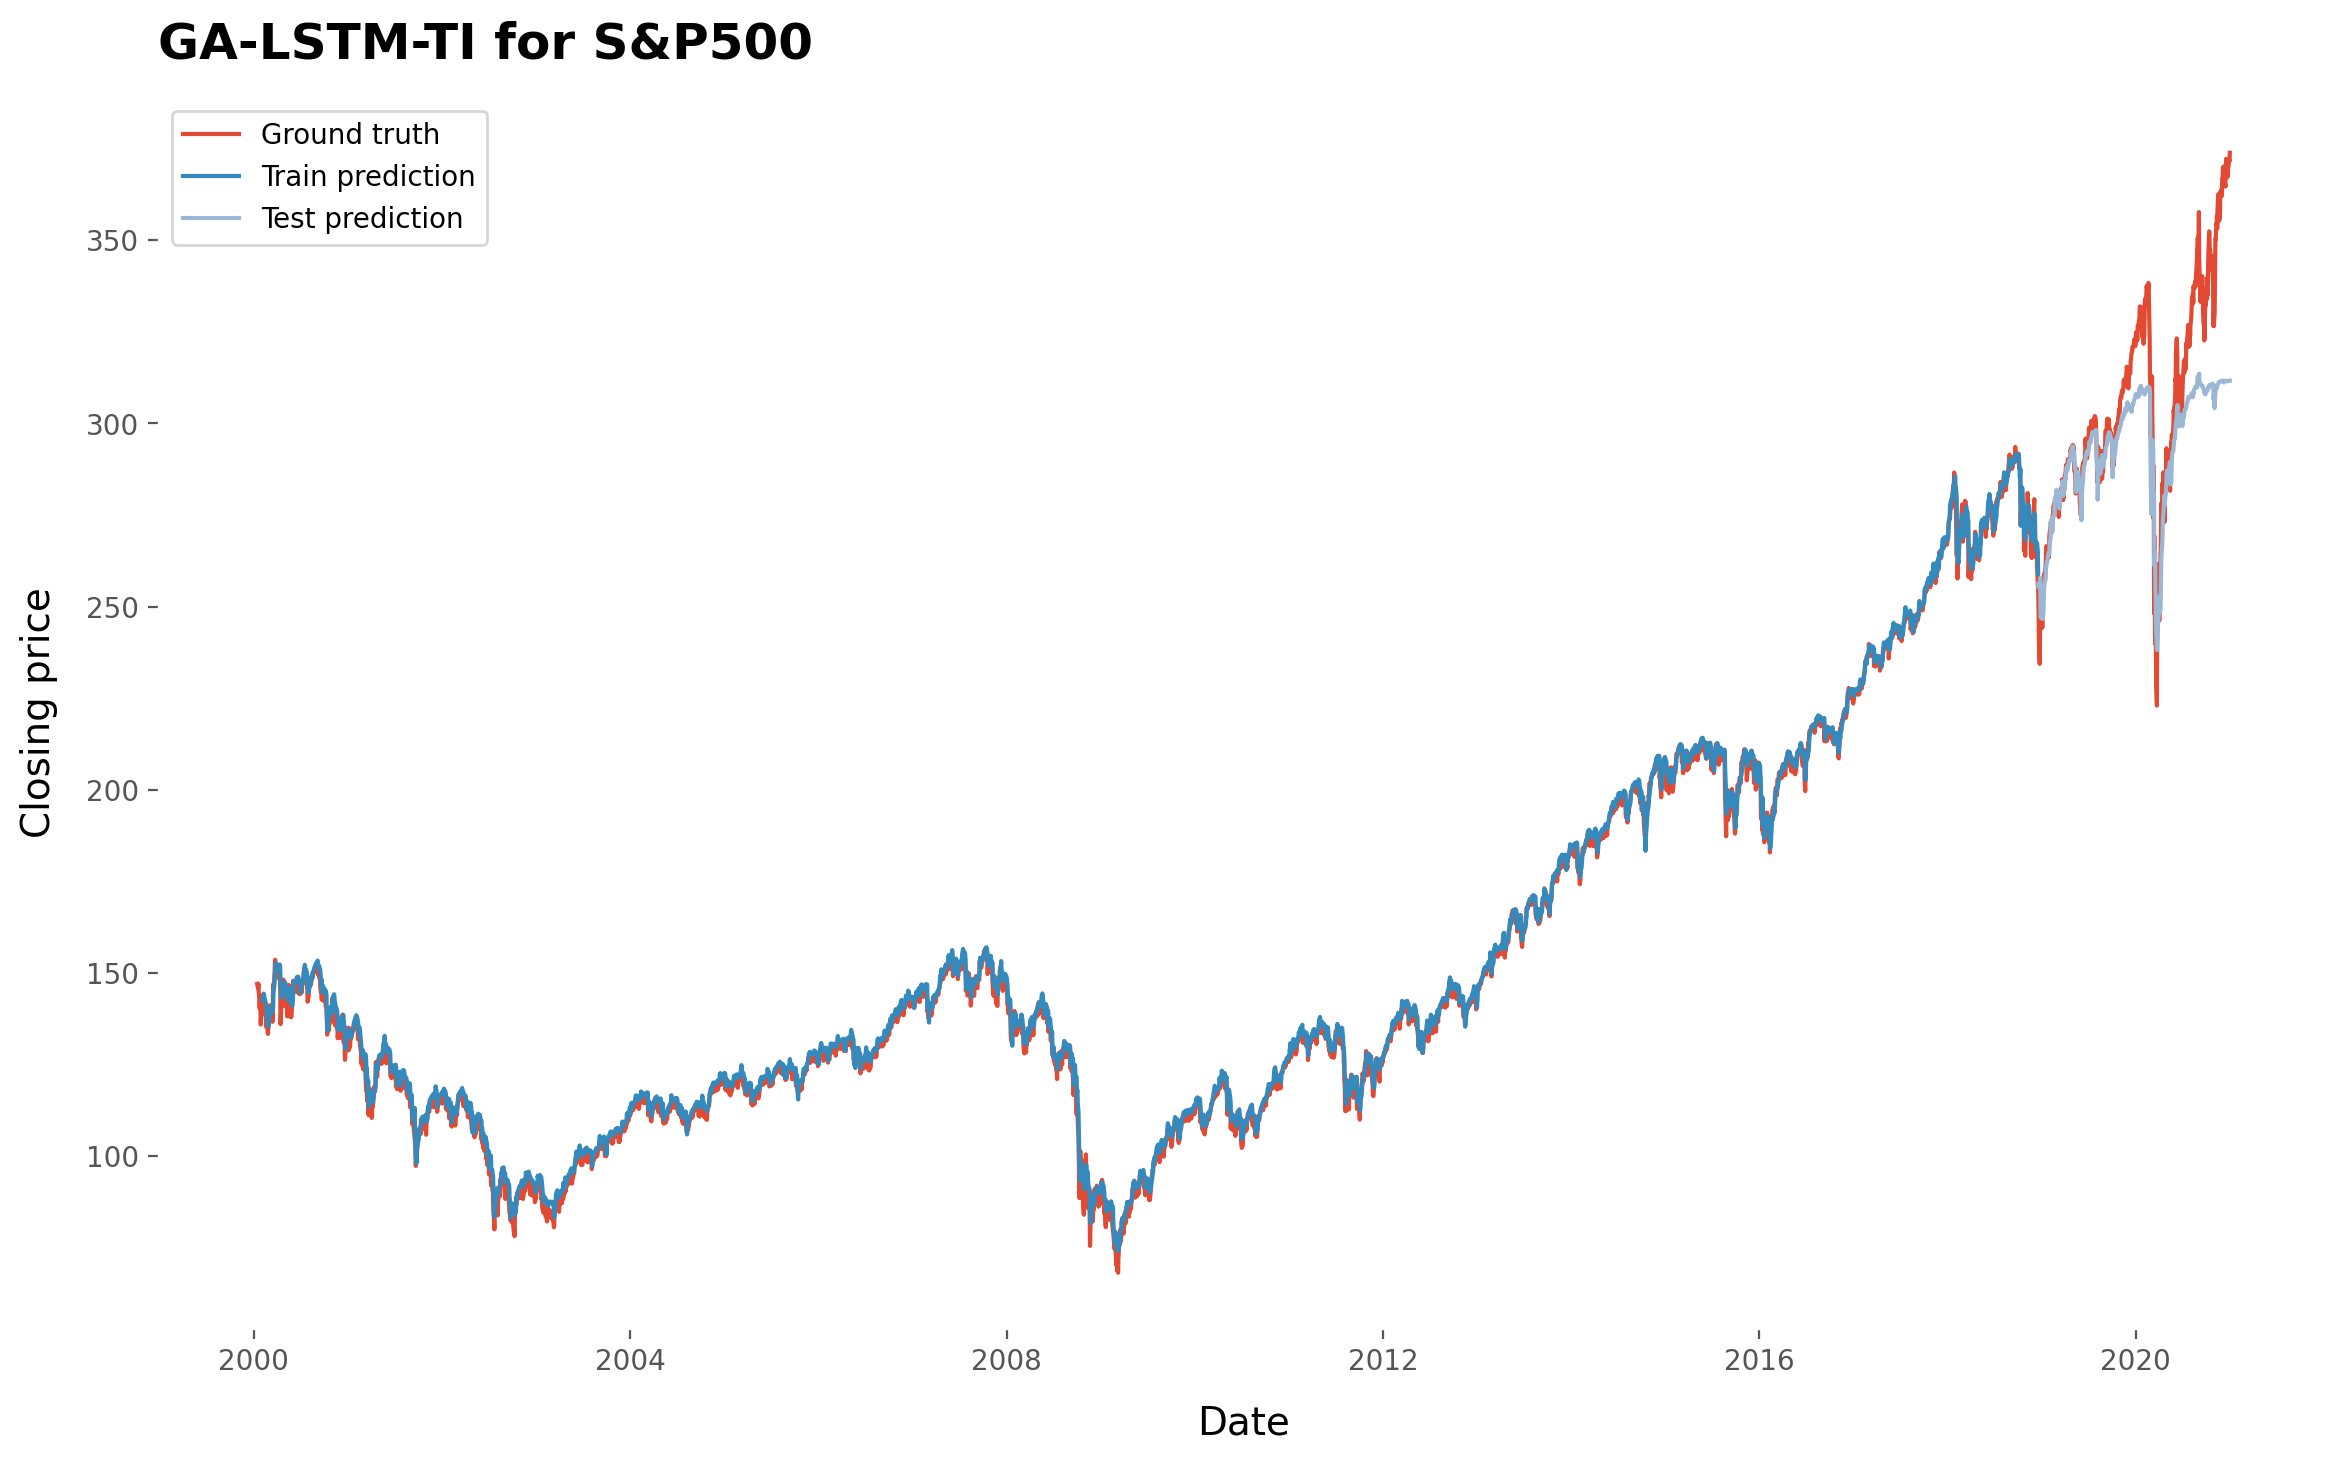

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(f'GA-LSTM-TI for S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth')
plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], y_pred_train_ga_lstm_with.ravel(), label='Train prediction')
plt.plot(df.index[val_size+train_size+window_size-1:], y_pred_test_ga_lstm_with.ravel(), label='Test prediction', color='#9BB7D4')

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

# Particle Swarm Optimization


In [ ]:
!pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=a925ca4c601cfdce1a80bf7026b848b714d5be09b0d67cb94a32781582701f72
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


#### PSO without Technical Indicators

In [ ]:
from src.pso import PSO
pso=PSO(swarmsize=100,
    omega=0.5,
    maxiter=10,
    criterion=criterion,
    device=device,
    model="LSTM",
    X_val=X_val_without,
    y_val=y_val_without
    )
lb=[0,60,8,2]
ub=[1,300,256,15]
result=pso.fit(lb,ub)

No constraints given.
Best after iteration 1: [1.49670609e-03 2.53704565e+02 2.09651889e+02 4.97891709e+00] 0.14750966429710388
Best after iteration 2: [1.49670609e-03 2.53704565e+02 2.09651889e+02 4.97891709e+00] 0.14750966429710388
Best after iteration 3: [1.49670609e-03 2.53704565e+02 2.09651889e+02 4.97891709e+00] 0.14750966429710388
New best for swarm at iteration 4: [6.05507657e-03 2.16460868e+02 1.80499934e+02 2.83866248e+00] 0.11064554005861282
Best after iteration 4: [6.05507657e-03 2.16460868e+02 1.80499934e+02 2.83866248e+00] 0.11064554005861282
Best after iteration 5: [6.05507657e-03 2.16460868e+02 1.80499934e+02 2.83866248e+00] 0.11064554005861282
New best for swarm at iteration 6: [2.55924970e-03 2.26900516e+02 1.92055665e+02 3.42668032e+00] 0.05840890482068062
Best after iteration 6: [2.55924970e-03 2.26900516e+02 1.92055665e+02 3.42668032e+00] 0.05840890482068062
Best after iteration 7: [2.55924970e-03 2.26900516e+02 1.92055665e+02 3.42668032e+00] 0.05840890482068062
Be

In [ ]:
print("Learning Rate: ",result[0][0])
print("Epochs: ",int(result[0][1]))
print("No of Hidden Units: ",int(result[0][2]))
print("No of Hidden Layers: ",int(result[0][3]))
print("Loss: ",result[1])

Learning Rate:  0.001911562389825509
Epochs:  210
No of Hidden Units:  192
No of Hidden Layers:  3
Loss:  0.03197423368692398


In [ ]:
seed_everything()
pso_lstm_model_without = LSTM(input_size=X_train_without.shape[2],
                     hidden_size=192,
                     num_layers=3,
                              )
pso_lstm_model_without.to(device)

LSTM(
  (lstm): LSTM(1, 192, num_layers=3, batch_first=True)
  (fc): Linear(in_features=192, out_features=1, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(pso_lstm_model_without.parameters(),
                             lr= 0.03197423368692398)

Epoch: 210


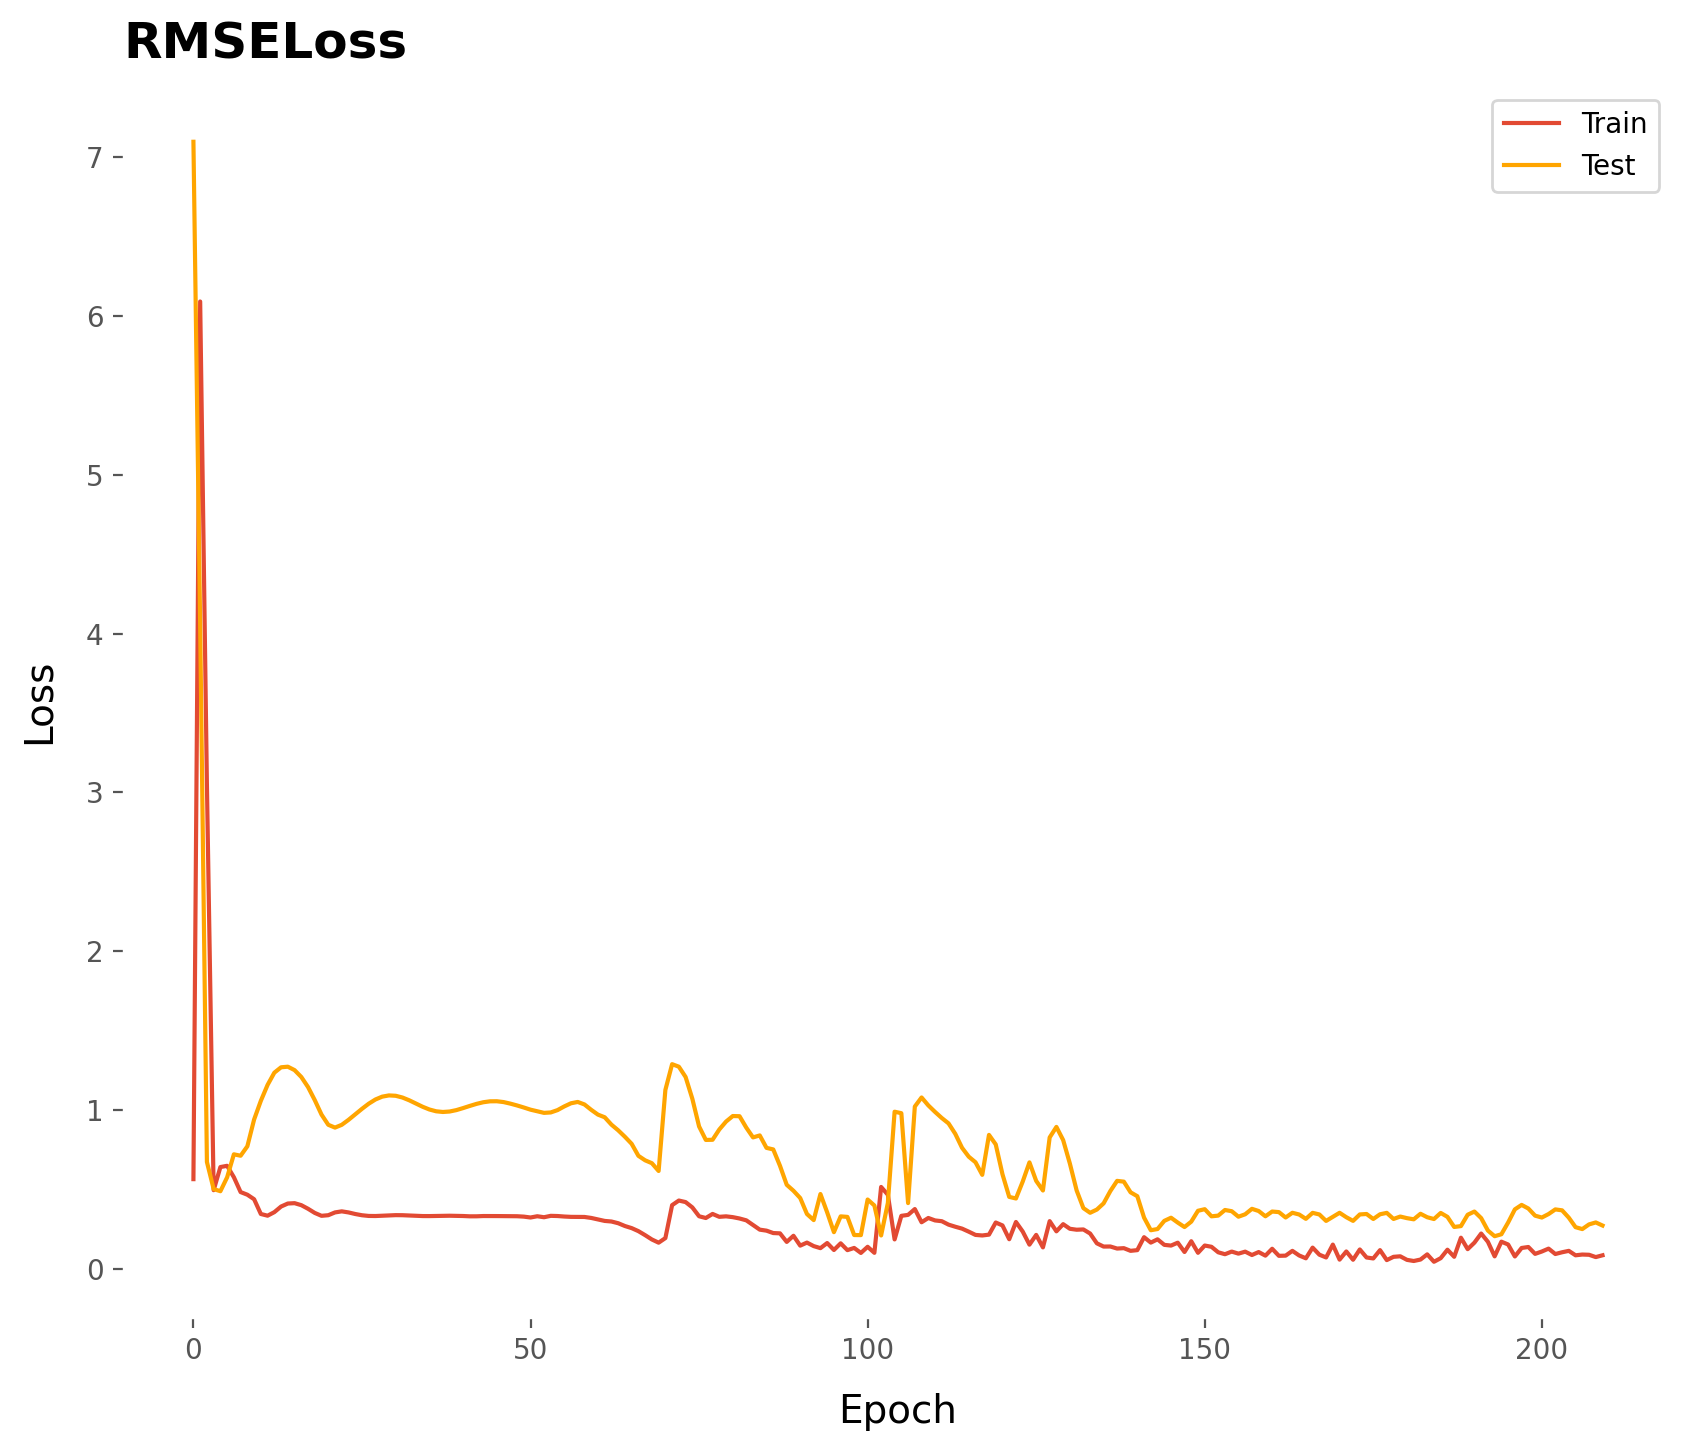

Train loss: 0.08611
Test loss: 0.2735


In [ ]:
seed_everything()
train_loss_pso_lstm_without, test_loss_pso_lstm_without = \
    train(pso_lstm_model_without, criterion, optimizer, device,
          torch.vstack((X_train_without, X_val_without)),
          torch.vstack((y_train_without, y_val_without)),
          X_test_without, y_test_without,
          n_epochs=210)

In [ ]:
y_pred_train_pso_lstm_without, y_train, y_pred_test_pso_lstm_without, y_test = \
    get_predictions(pso_lstm_model_without, scaler_without,
                    torch.vstack((X_train_without, X_val_without)),
                    torch.vstack((y_train_without, y_val_without)),
                    X_test_without, y_test_without)

In [ ]:
eval_losses(y_pred_train_pso_lstm_without, y_train,
            y_pred_test_pso_lstm_without, y_test)

Train RMSE = 612.81
Train MAE = 3.1831e+04
Train SMAPE = 5.0817

Test RMSE = 947.22
Test MAE = 17508.74
Test SMAPE = 11.425

R_sq = -0.9577334547050371


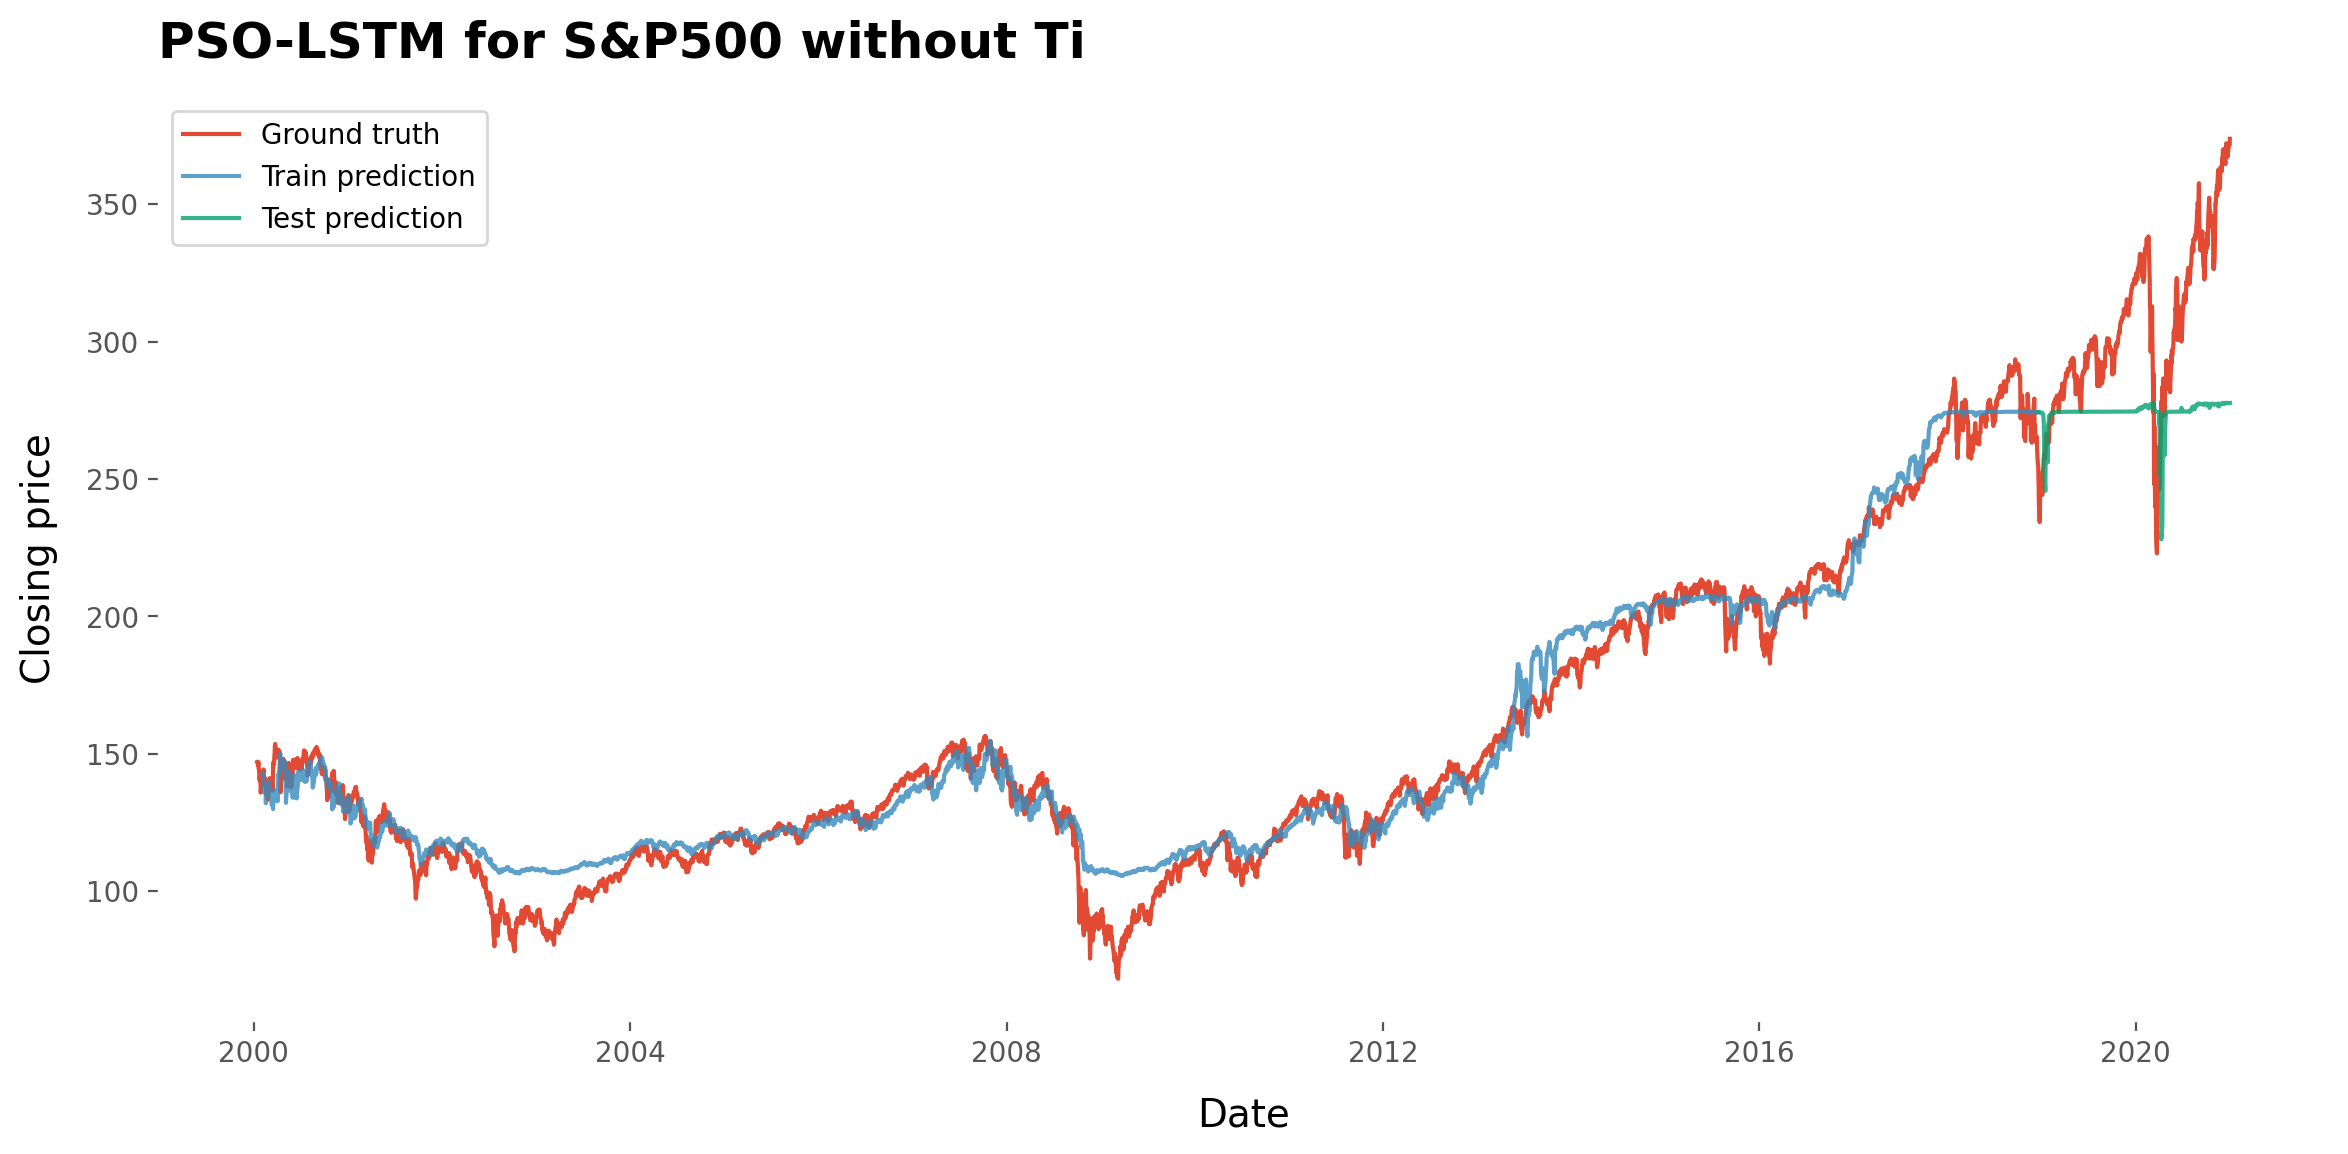

In [ ]:
plt.figure(figsize=(14, 6))
plt.title(f'PSO-LSTM for S&P500 without Ti', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth')
plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], y_pred_train_pso_lstm_without.ravel(), label='Train prediction', alpha=0.8)
plt.plot(df.index[val_size+train_size+window_size-1:], y_pred_test_pso_lstm_without.ravel(), label='Test prediction', color='#00A170', alpha=0.8)

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

#### PSO-LSTM with Technical Indicators

In [ ]:
from src.pso import PSO
pso=PSO(swarmsize=100,
    omega=0.5,
    maxiter=10,
    criterion=criterion,
    device=device,
    model="LSTM",
    X_val=X_val_with,
    y_val=y_val_with
    )
lb=[0,60,8,2]
ub=[1,300,256,15]
result=pso.fit(lb,ub)

No constraints given.
Best after iteration 1: [1.54060937e-03 1.10249084e+02 9.00300685e+01 2.81015770e+00] 0.07213332504034042
Best after iteration 2: [1.54060937e-03 1.10249084e+02 9.00300685e+01 2.81015770e+00] 0.07213332504034042
Best after iteration 3: [1.54060937e-03 1.10249084e+02 9.00300685e+01 2.81015770e+00] 0.07213332504034042
New best for swarm at iteration 4: [4.17785342e-03 1.23457775e+02 9.94379511e+01 2.68981578e+00] 0.0358731672167778
Best after iteration 4: [4.17785342e-03 1.23457775e+02 9.94379511e+01 2.68981578e+00] 0.0358731672167778
Best after iteration 5: [4.17785342e-03 1.23457775e+02 9.94379511e+01 2.68981578e+00] 0.0358731672167778
Best after iteration 6: [4.17785342e-03 1.23457775e+02 9.94379511e+01 2.68981578e+00] 0.0358731672167778
Best after iteration 7: [4.17785342e-03 1.23457775e+02 9.94379511e+01 2.68981578e+00] 0.0358731672167778
Best after iteration 8: [4.17785342e-03 1.23457775e+02 9.94379511e+01 2.68981578e+00] 0.0358731672167778
Best after iteratio

In [ ]:
print("Learning Rate: ",result[0][0])
print("Epochs: ",int(result[0][1]))
print("No of Hidden Units: ",int(result[0][2]))
print("No of Hidden Layers: ",int(result[0][3]))
print("Loss: ",result[1])

Learning Rate:  0.003582084312903284
Epochs:  125
No of Hidden Units:  134
No of Hidden Layers:  2
Loss:  0.027650490403175354


In [ ]:
seed_everything()
pso_lstm_model_with = LSTM(input_size=X_train_with.shape[2],
                     hidden_size=134,
                     num_layers=2,
                              )
pso_lstm_model_with.to(device)

LSTM(
  (lstm): LSTM(12, 134, num_layers=2, batch_first=True)
  (fc): Linear(in_features=134, out_features=1, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(pso_lstm_model_with.parameters(),
                             lr=0.003582084312903284)

Epoch: 125


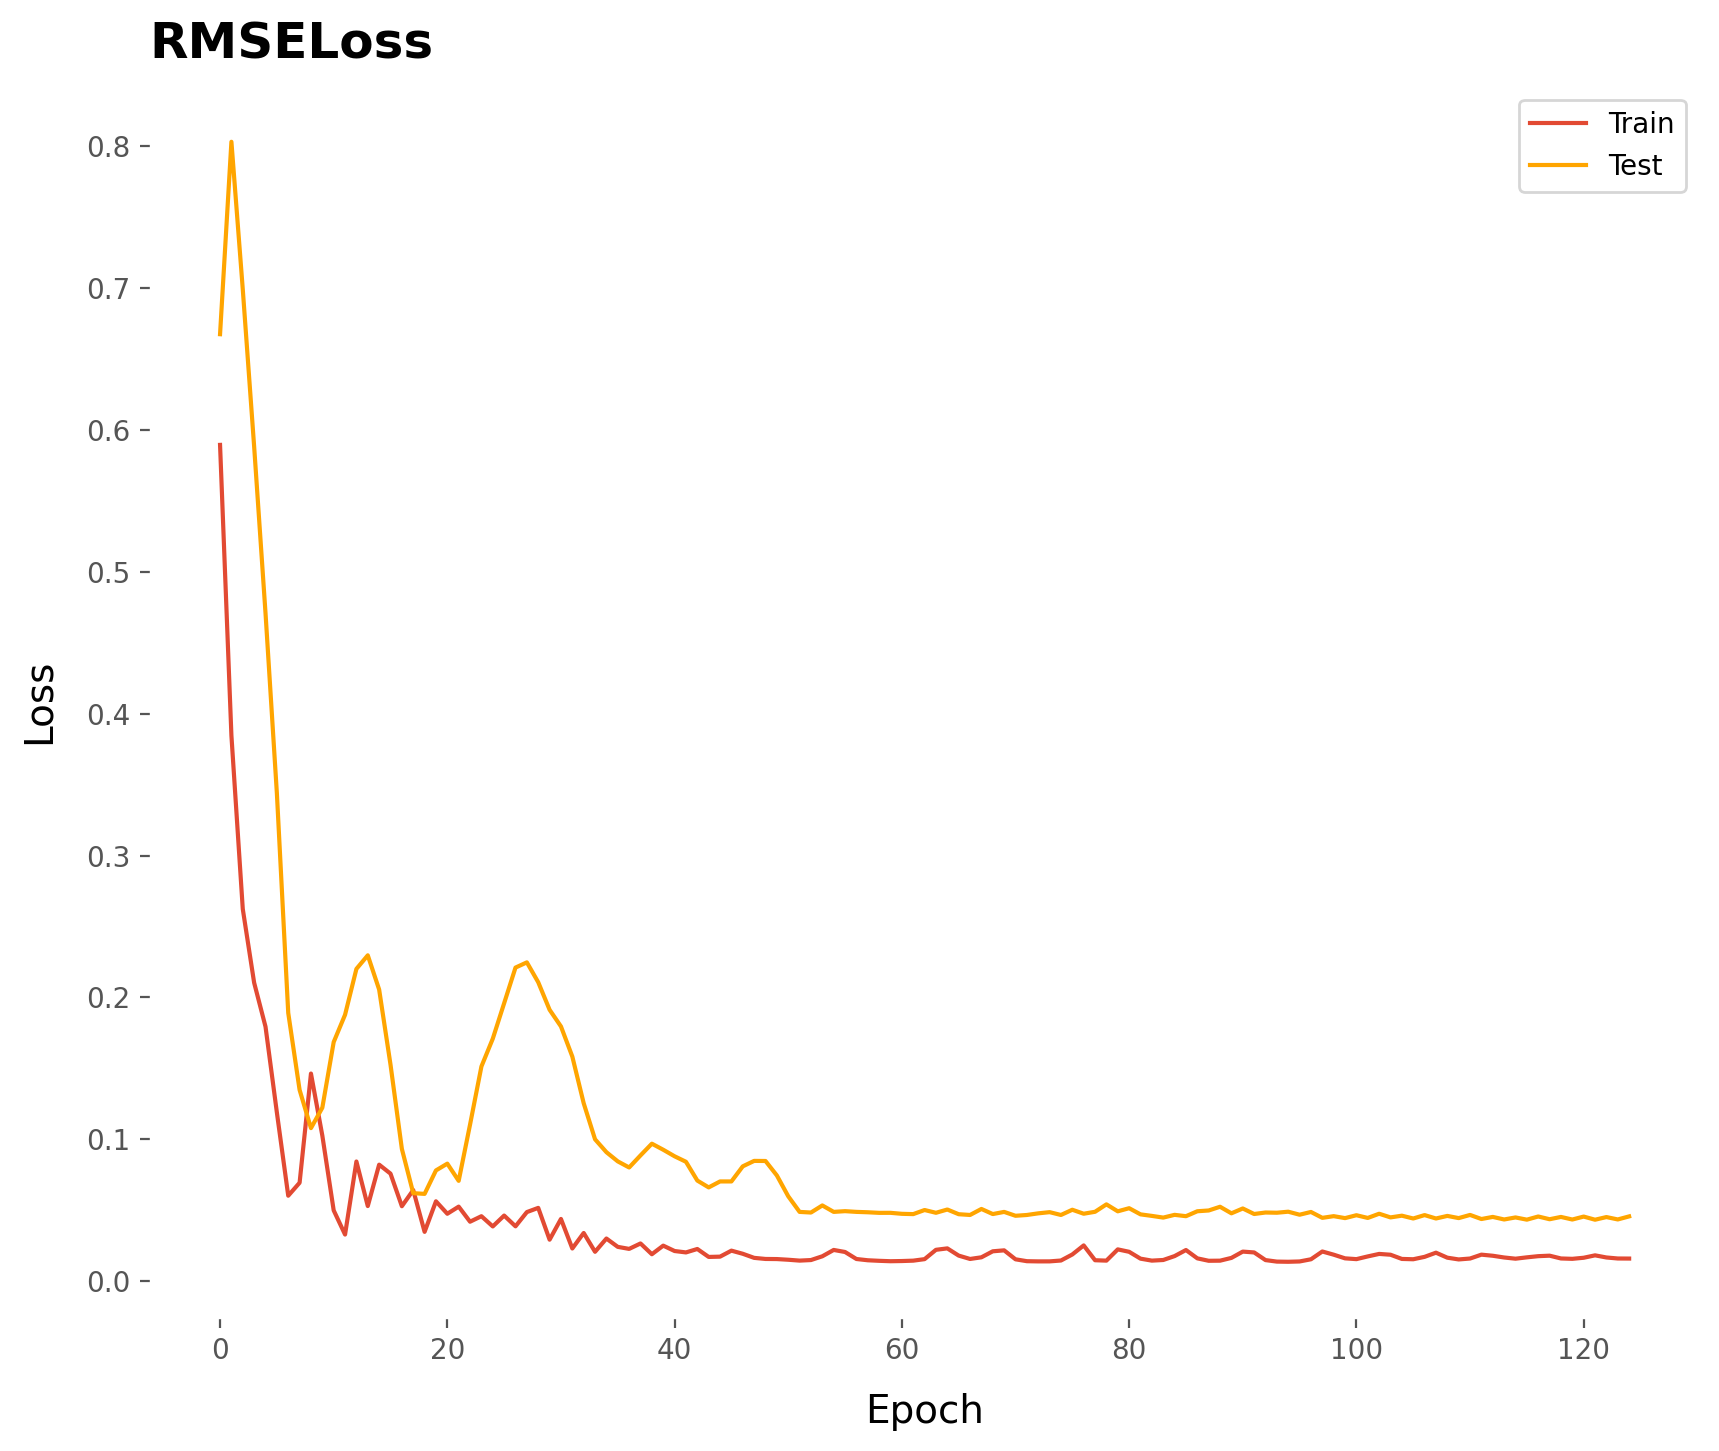

Train loss: 0.01601
Test loss: 0.04573


In [ ]:
seed_everything()
train_loss_pso_lstm_with, test_loss_pso_lstm_with = \
    train(pso_lstm_model_with, criterion, optimizer, device,
          torch.vstack((X_train_with, X_val_with)),
          torch.vstack((y_train_with, y_val_with)),
          X_test_with, y_test_with,
          n_epochs=125)

In [ ]:
y_pred_train_pso_lstm_with, y_train, y_pred_test_pso_lstm_with, y_test = \
    get_predictions(pso_lstm_model_with, scaler_without,
                    torch.vstack((X_train_with, X_val_with)),
                    torch.vstack((y_train_with, y_val_with)),
                    X_test_with, y_test_with)

In [ ]:
eval_losses(y_pred_train_pso_lstm_with, y_train,
            y_pred_test_pso_lstm_with, y_test)

Train RMSE = 181.63
Train MAE = 9660.7
Train SMAPE = 1.5535

Test RMSE = 158.35
Test MAE = 2669.823
Test SMAPE = 1.7232

R_sq = 0.9452853502291941


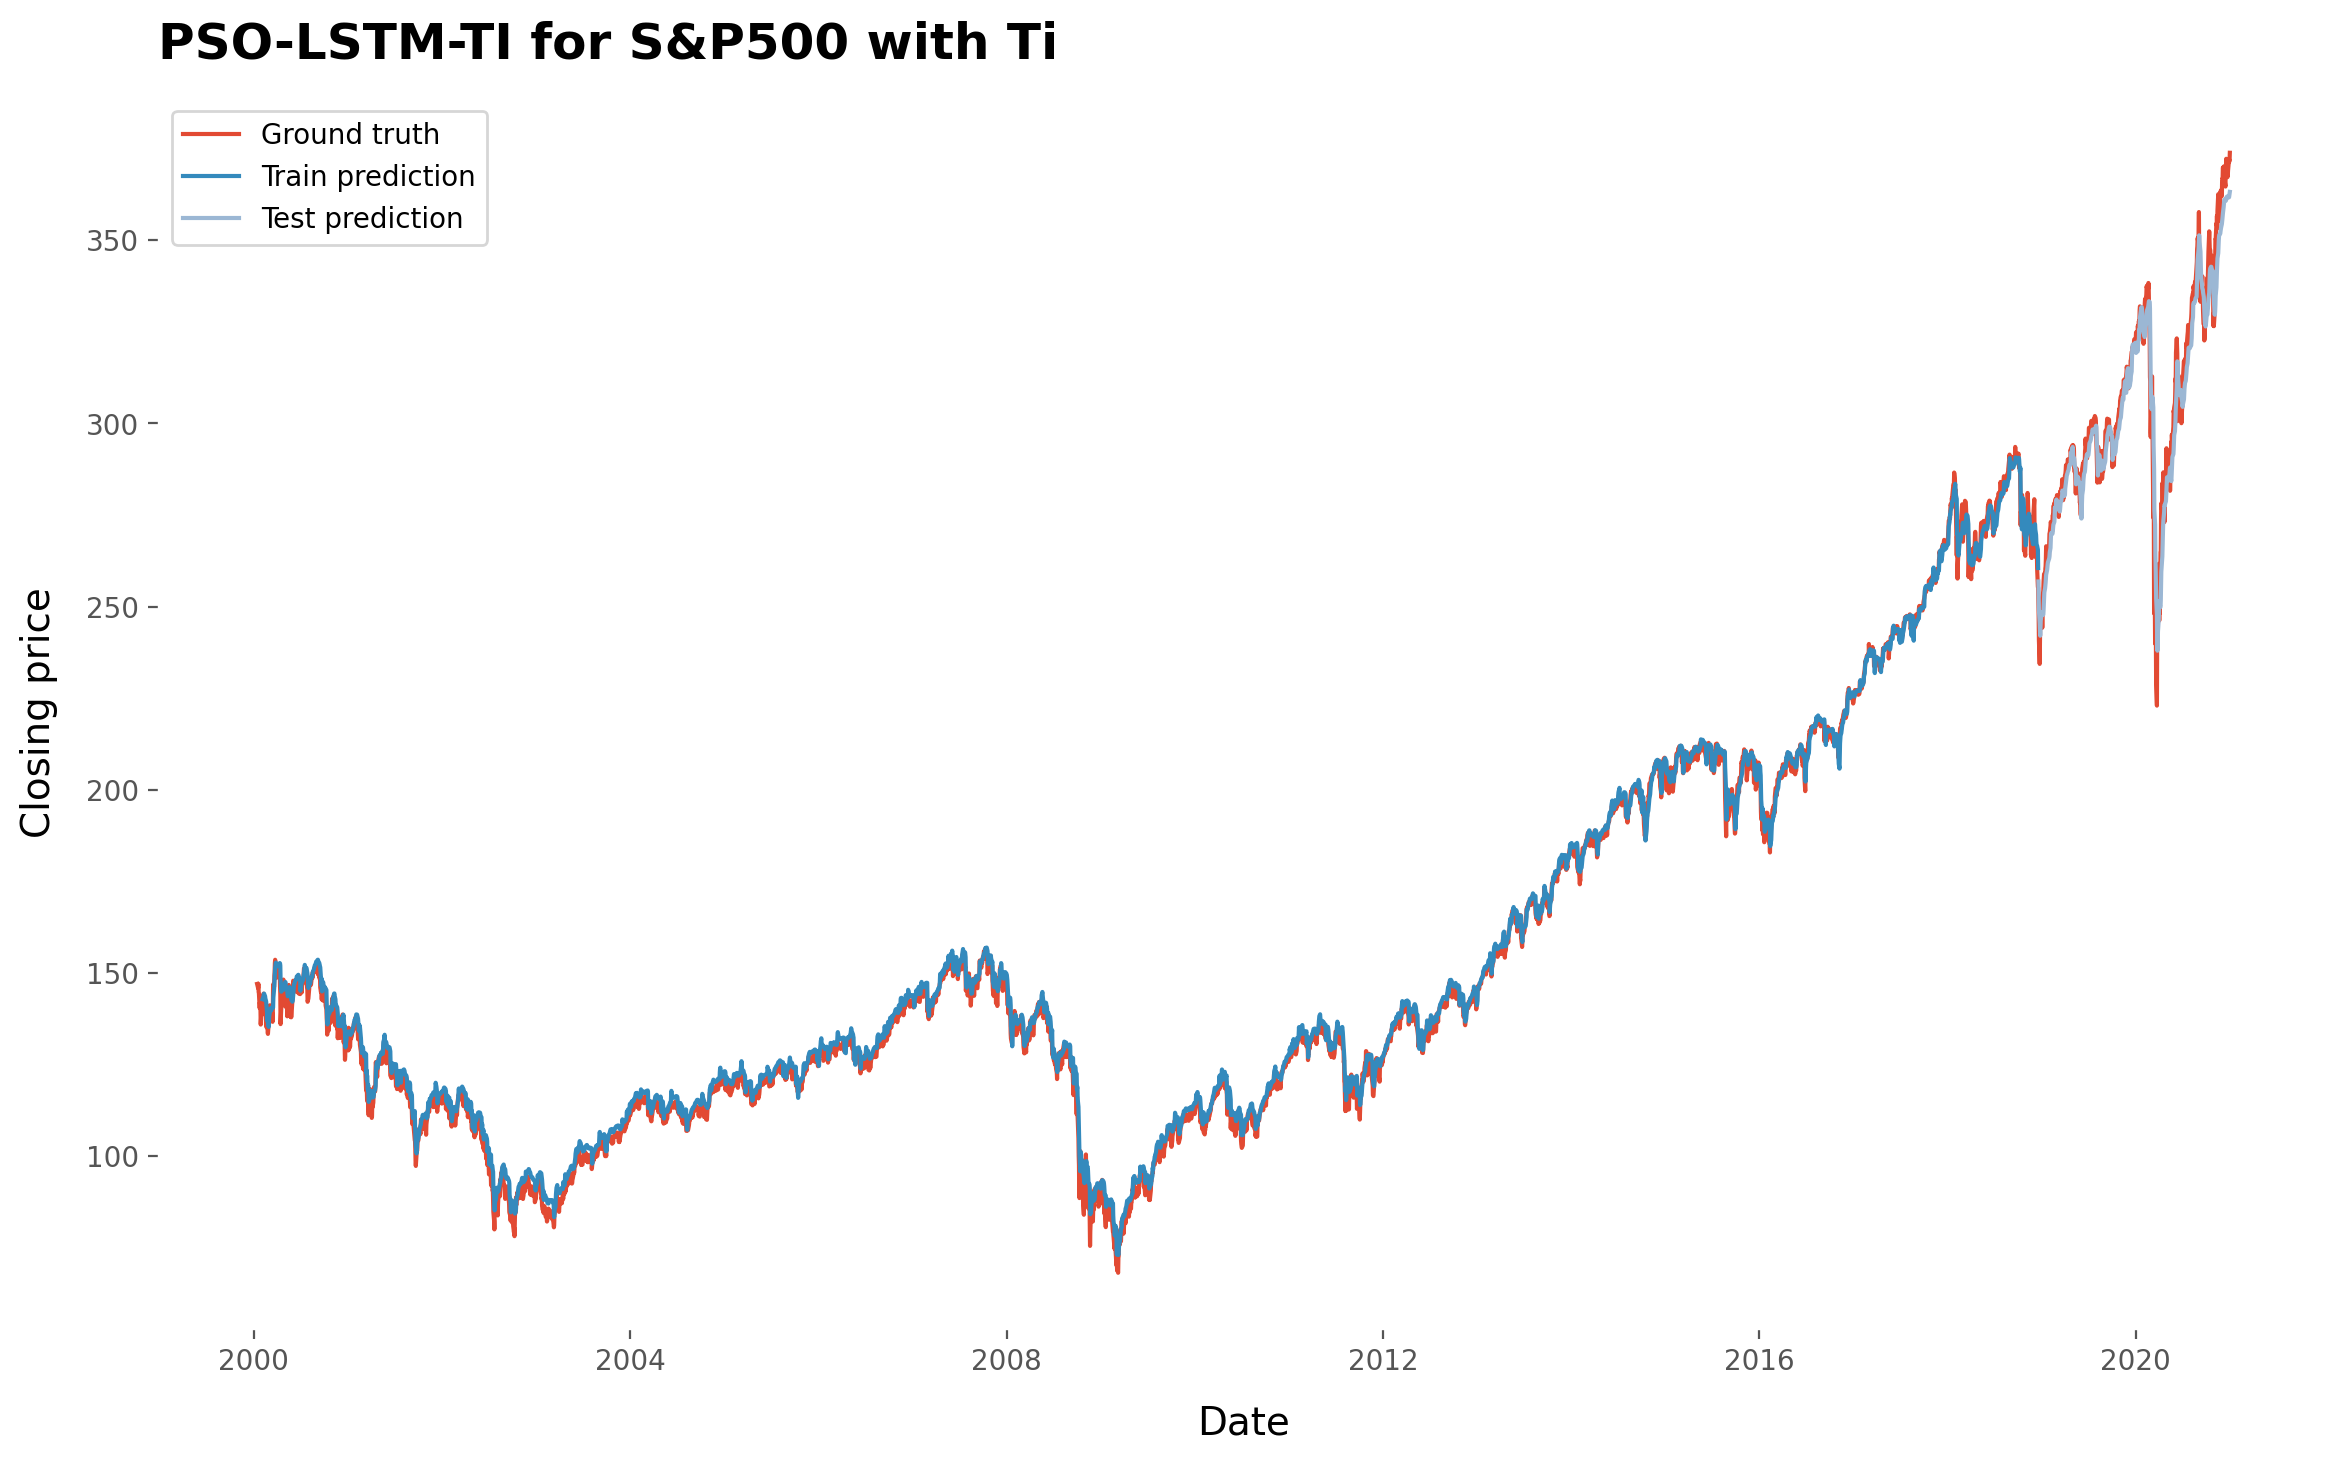

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(f'PSO-LSTM-TI for S&P500 with Ti', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth')
plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], y_pred_train_pso_lstm_with.ravel(), label='Train prediction')
plt.plot(df.index[val_size+train_size+window_size-1:], y_pred_test_pso_lstm_with.ravel(), label='Test prediction', color='#9BB7D4')

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

# Differential Evolution

#### DE without Technical Indicators

In [ ]:
from src.differential_evolution import DE
de=DE(popsize=100,
    maxiter=10,
    criterion=criterion,
    device=device,
    model="LSTM",
    X_val=X_val_without,
    y_val=y_val_without)
bounds=[(0,1),(60,300),(8,256),(2,15)]
result = de.fit(bounds)

differential_evolution step 1: f(x)= 0.149717
differential_evolution step 2: f(x)= 0.0439371
differential_evolution step 3: f(x)= 0.0439371
differential_evolution step 4: f(x)= 0.0439371
differential_evolution step 5: f(x)= 0.0439371
differential_evolution step 6: f(x)= 0.0292733
differential_evolution step 7: f(x)= 0.0292733
differential_evolution step 8: f(x)= 0.0292733
differential_evolution step 9: f(x)= 0.0292733
differential_evolution step 10: f(x)= 0.0292733
Polishing solution with 'L-BFGS-B'


In [ ]:
print("Loss:",result.fun)
print("Learning Rate:",result.x[0])
print("Epochs:",int(result.x[1]))
print("Number of hidden units:",int(result.x[2]))
print("Number of hidden layers:",int(result.x[3]))

Loss: 0.02785455994307995
Learning Rate: 0.004225638854521699
Epochs: 185
Number of hidden units: 46
Number of hidden layers: 2


In [ ]:
de_lstm_model_without = LSTM(input_size=X_train_without.shape[2],
                     hidden_size=46,
                     num_layers=2,
                              )
de_lstm_model_without.to(device)

LSTM(
  (lstm): LSTM(1, 46, num_layers=2, batch_first=True)
  (fc): Linear(in_features=46, out_features=1, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(de_lstm_model_without.parameters(),
                             lr=0.004225638854521699)

Epoch: 185


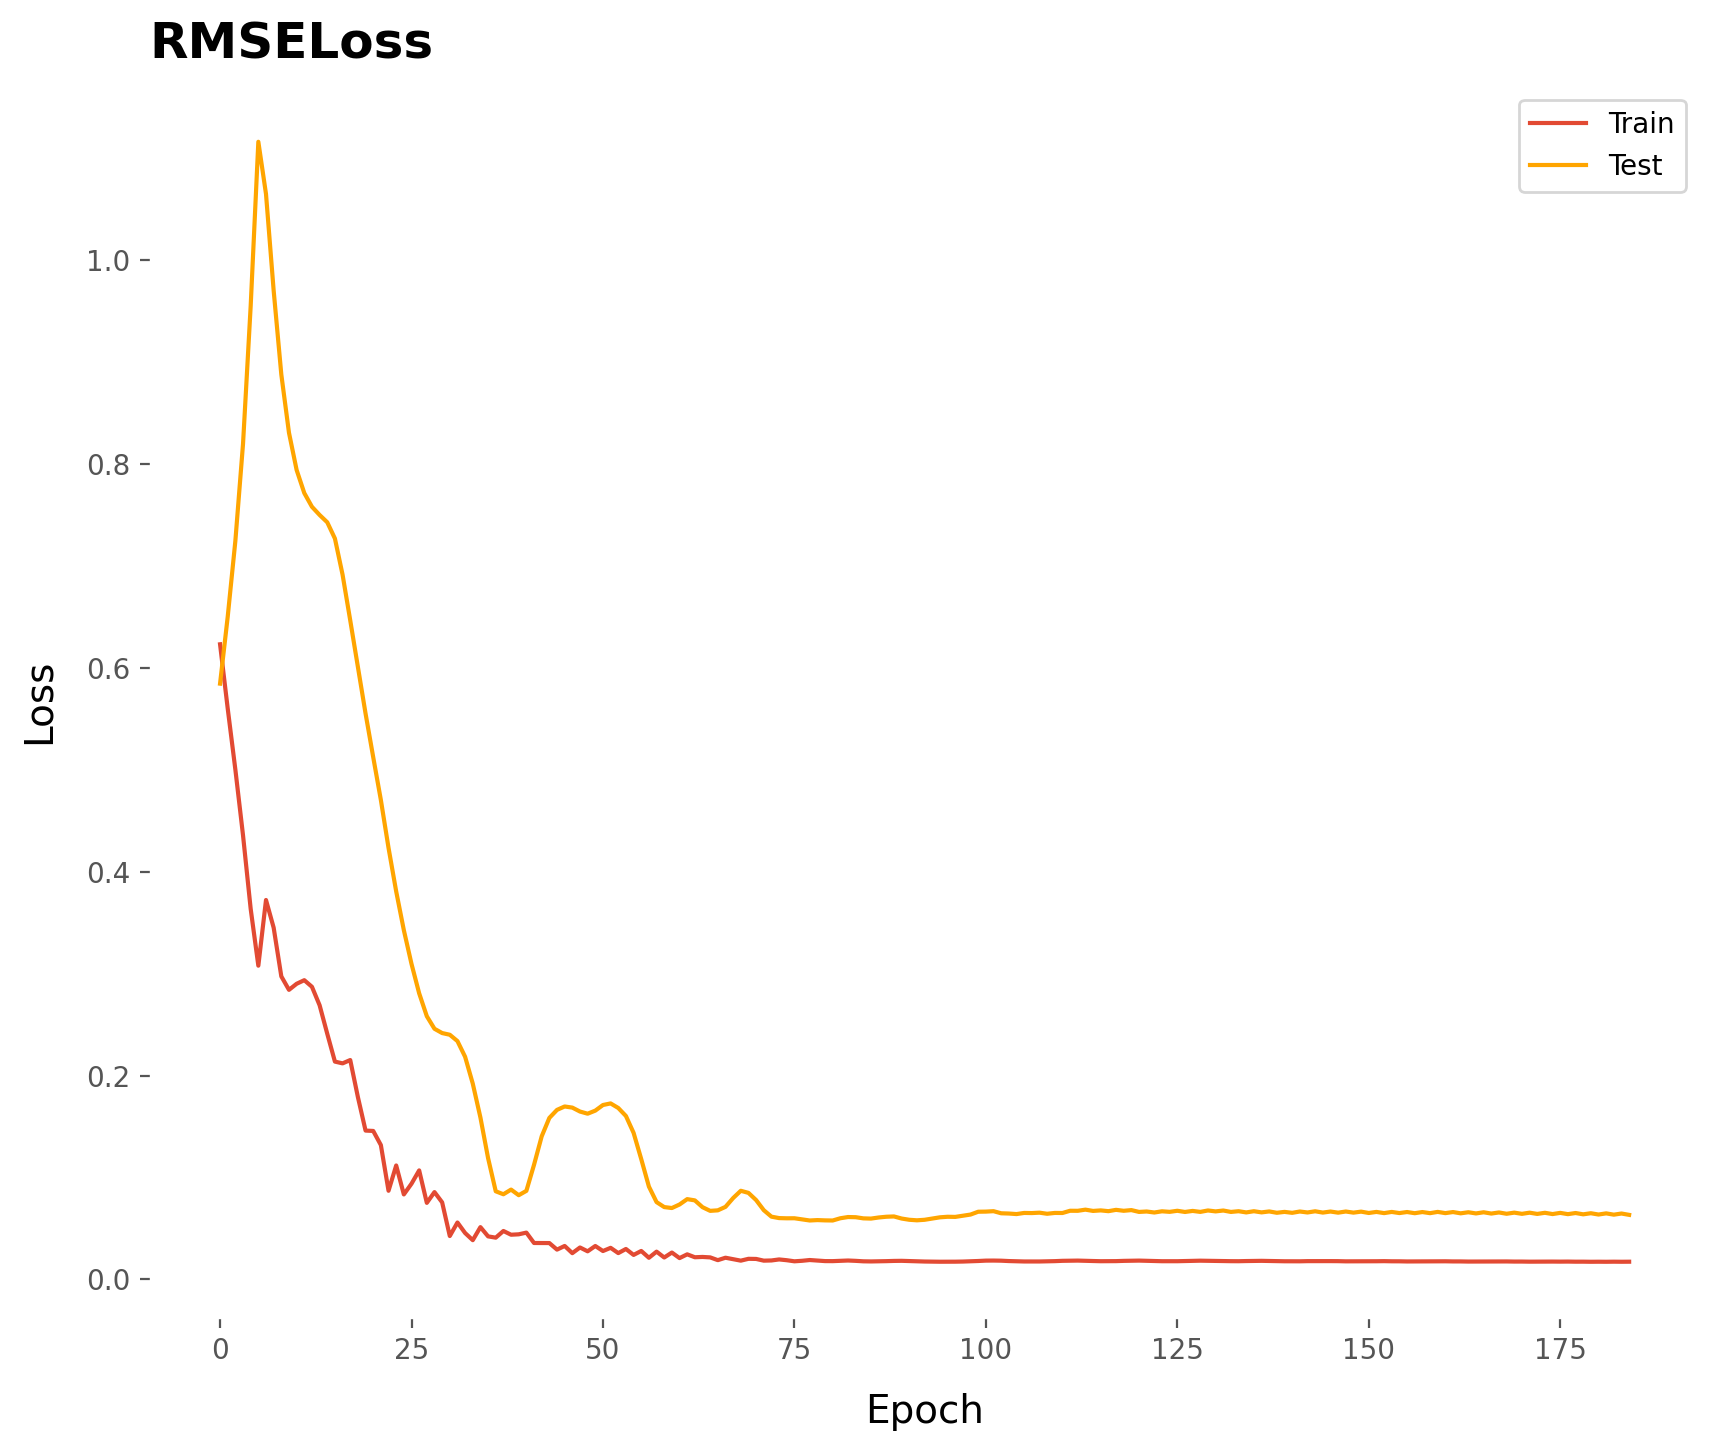

Train loss: 0.01738
Test loss: 0.06336


In [ ]:
seed_everything()
train_loss_de_lstm_without, test_loss_de_lstm_without = \
    train(de_lstm_model_without, criterion, optimizer, device,
          torch.vstack((X_train_without, X_val_without)),
          torch.vstack((y_train_without, y_val_without)),
          X_test_without, y_test_without,
          n_epochs=185)

In [ ]:
y_pred_train_de_lstm_without, y_train, y_pred_test_de_lstm_without, y_test = \
    get_predictions(de_lstm_model_without, scaler_without,
                    torch.vstack((X_train_without, X_val_without)),
                    torch.vstack((y_train_without, y_val_without)),
                    X_test_without, y_test_without)

In [ ]:
eval_losses(y_pred_train_de_lstm_without, y_train,
            y_pred_test_de_lstm_without, y_test)

Train RMSE = 181.98
Train MAE = 9777.5
Train SMAPE = 1.5254

Test RMSE = 219.39
Test MAE = 3747.886
Test SMAPE = 2.3685

R_sq = 0.8949740531848536


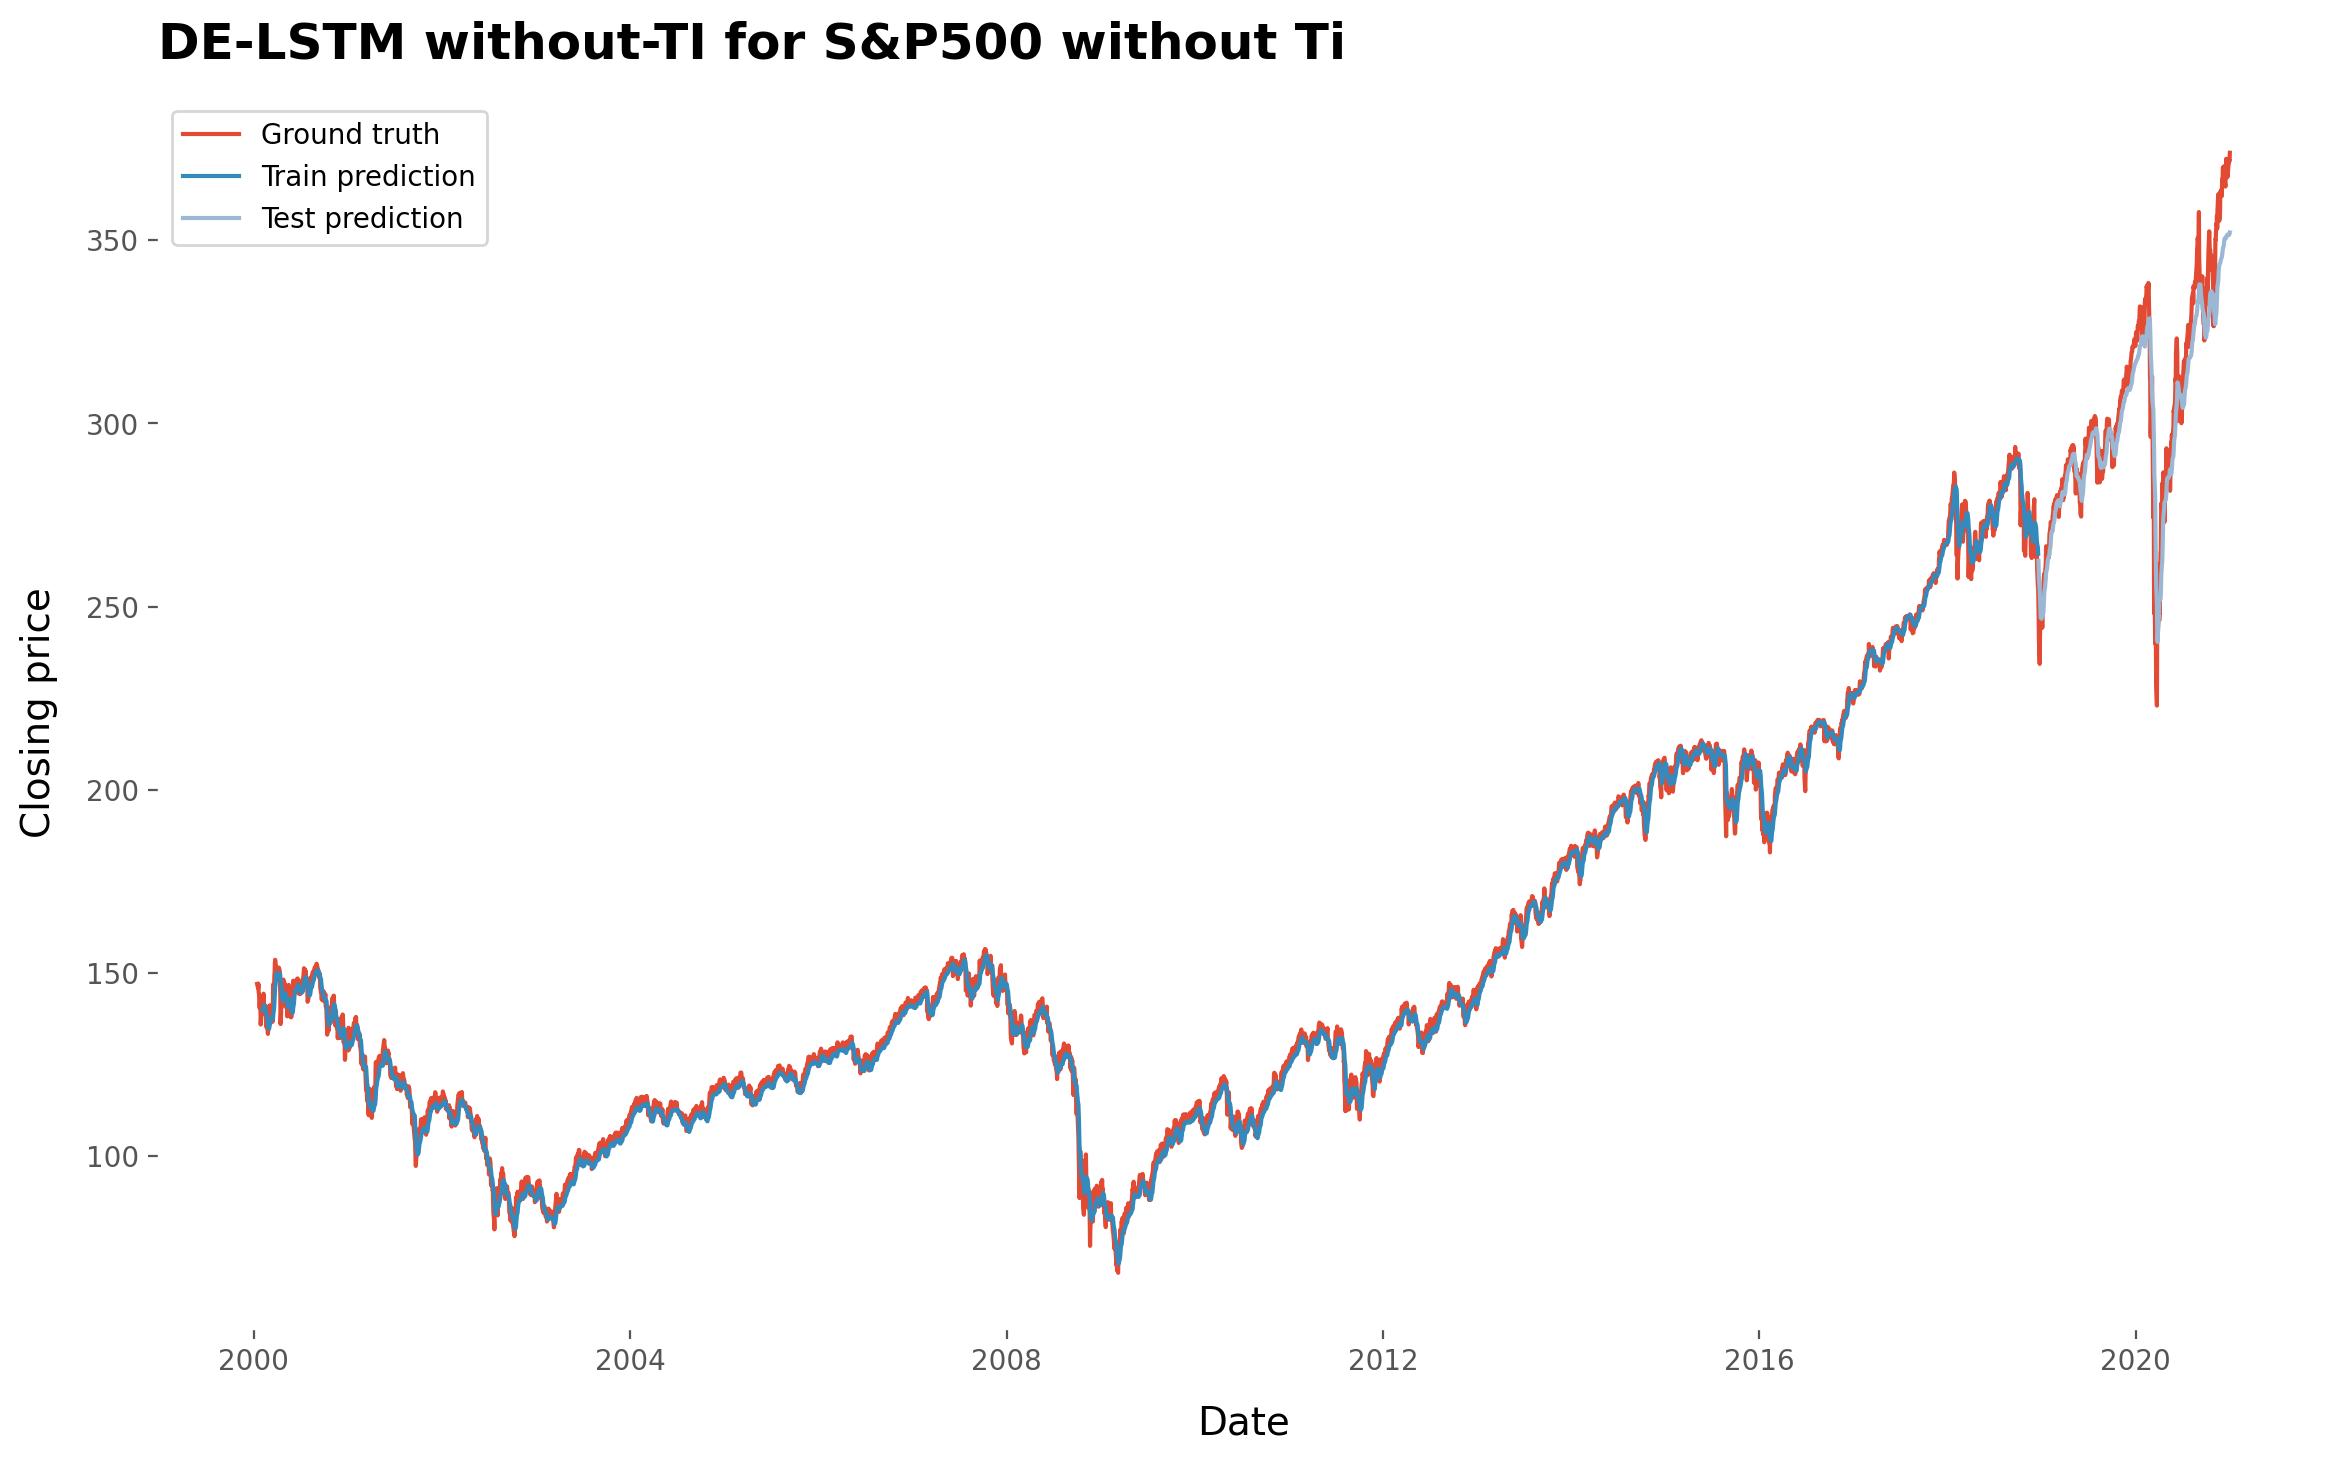

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(f'DE-LSTM without-TI for S&P500 without Ti', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth')
plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], y_pred_train_de_lstm_without.ravel(), label='Train prediction')
plt.plot(df.index[val_size+train_size+window_size-1:], y_pred_test_de_lstm_without.ravel(), label='Test prediction', color='#9BB7D4')

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

#### DE with Technical Indicators

In [ ]:
from src.differential_evolution import DE
de=DE(popsize=100,
    maxiter=10,
    criterion=criterion,
    device=device,
    model="LSTM",
    X_val=X_val_with,
    y_val=y_val_with)
bounds=[(0,1),(60,300),(8,256),(2,15)]
result = de.fit(bounds)

differential_evolution step 1: f(x)= 0.0672641
differential_evolution step 2: f(x)= 0.0423762
differential_evolution step 3: f(x)= 0.0423762
differential_evolution step 4: f(x)= 0.0423762
differential_evolution step 5: f(x)= 0.0273821
differential_evolution step 6: f(x)= 0.0273821
differential_evolution step 7: f(x)= 0.0273821
differential_evolution step 8: f(x)= 0.0273821
differential_evolution step 9: f(x)= 0.0273821
differential_evolution step 10: f(x)= 0.0273821
Polishing solution with 'L-BFGS-B'


In [ ]:
print("Loss:",result.fun)
print("Learning Rate:",result.x[0])
print("Epochs:",int(result.x[1]))
print("Number of hidden units:",int(result.x[2]))
print("Number of hidden layers:",int(result.x[3]))

Loss: 0.02454010397195816
Learning Rate: 0.00962906556637339
Epochs: 85
Number of hidden units: 48
Number of hidden layers: 2


In [ ]:
de_lstm_model_with = LSTM(input_size=X_train_with.shape[2],
                     hidden_size=48,
                     num_layers=2,
                              )
de_lstm_model_with.to(device)

LSTM(
  (lstm): LSTM(12, 48, num_layers=2, batch_first=True)
  (fc): Linear(in_features=48, out_features=1, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(de_lstm_model_with.parameters(),
                             lr= 0.00962906556637339)

Epoch: 85


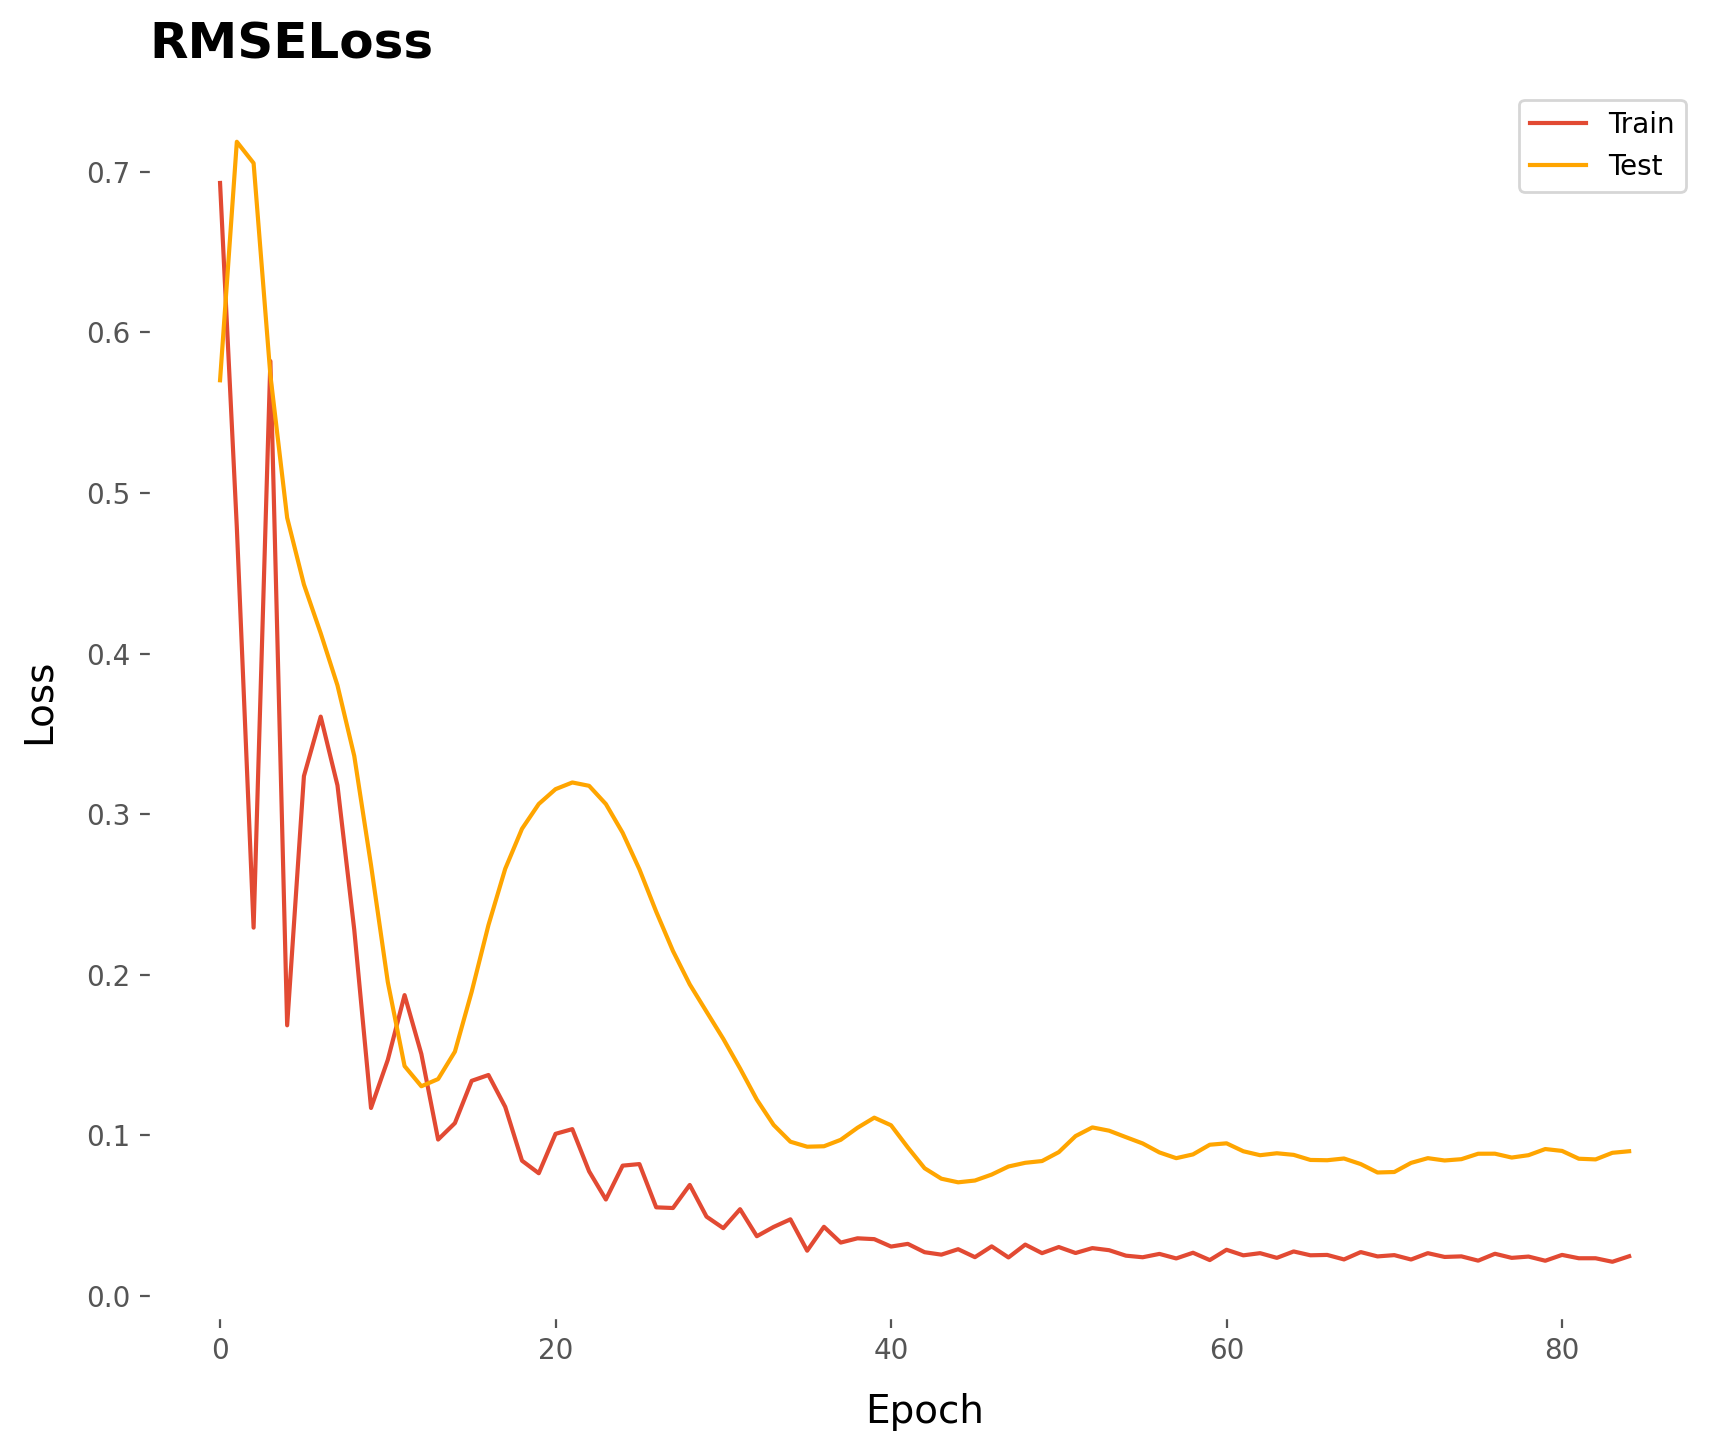

Train loss: 0.02477
Test loss: 0.09015


In [ ]:
seed_everything()
train_loss_de_lstm_with, test_loss_de_lstm_with = \
    train(de_lstm_model_with, criterion, optimizer, device,
          torch.vstack((X_train_with, X_val_with)),
          torch.vstack((y_train_with, y_val_with)),
          X_test_with, y_test_with,
          n_epochs=85)

In [ ]:
y_pred_train_de_lstm_with, y_train, y_pred_test_de_lstm_with, y_test = \
    get_predictions(de_lstm_model_with, scaler_without,
                    torch.vstack((X_train_with, X_val_with)),
                    torch.vstack((y_train_with, y_val_with)),
                    X_test_with, y_test_with)

In [ ]:
eval_losses(y_pred_train_de_lstm_with, y_train,
            y_pred_test_de_lstm_with, y_test)

Train RMSE = 234.86
Train MAE = 1.3174e+04
Train SMAPE = 2.1664

Test RMSE = 312.18
Test MAE = 5283.583
Test SMAPE = 3.2931

R_sq = 0.7873532183906612


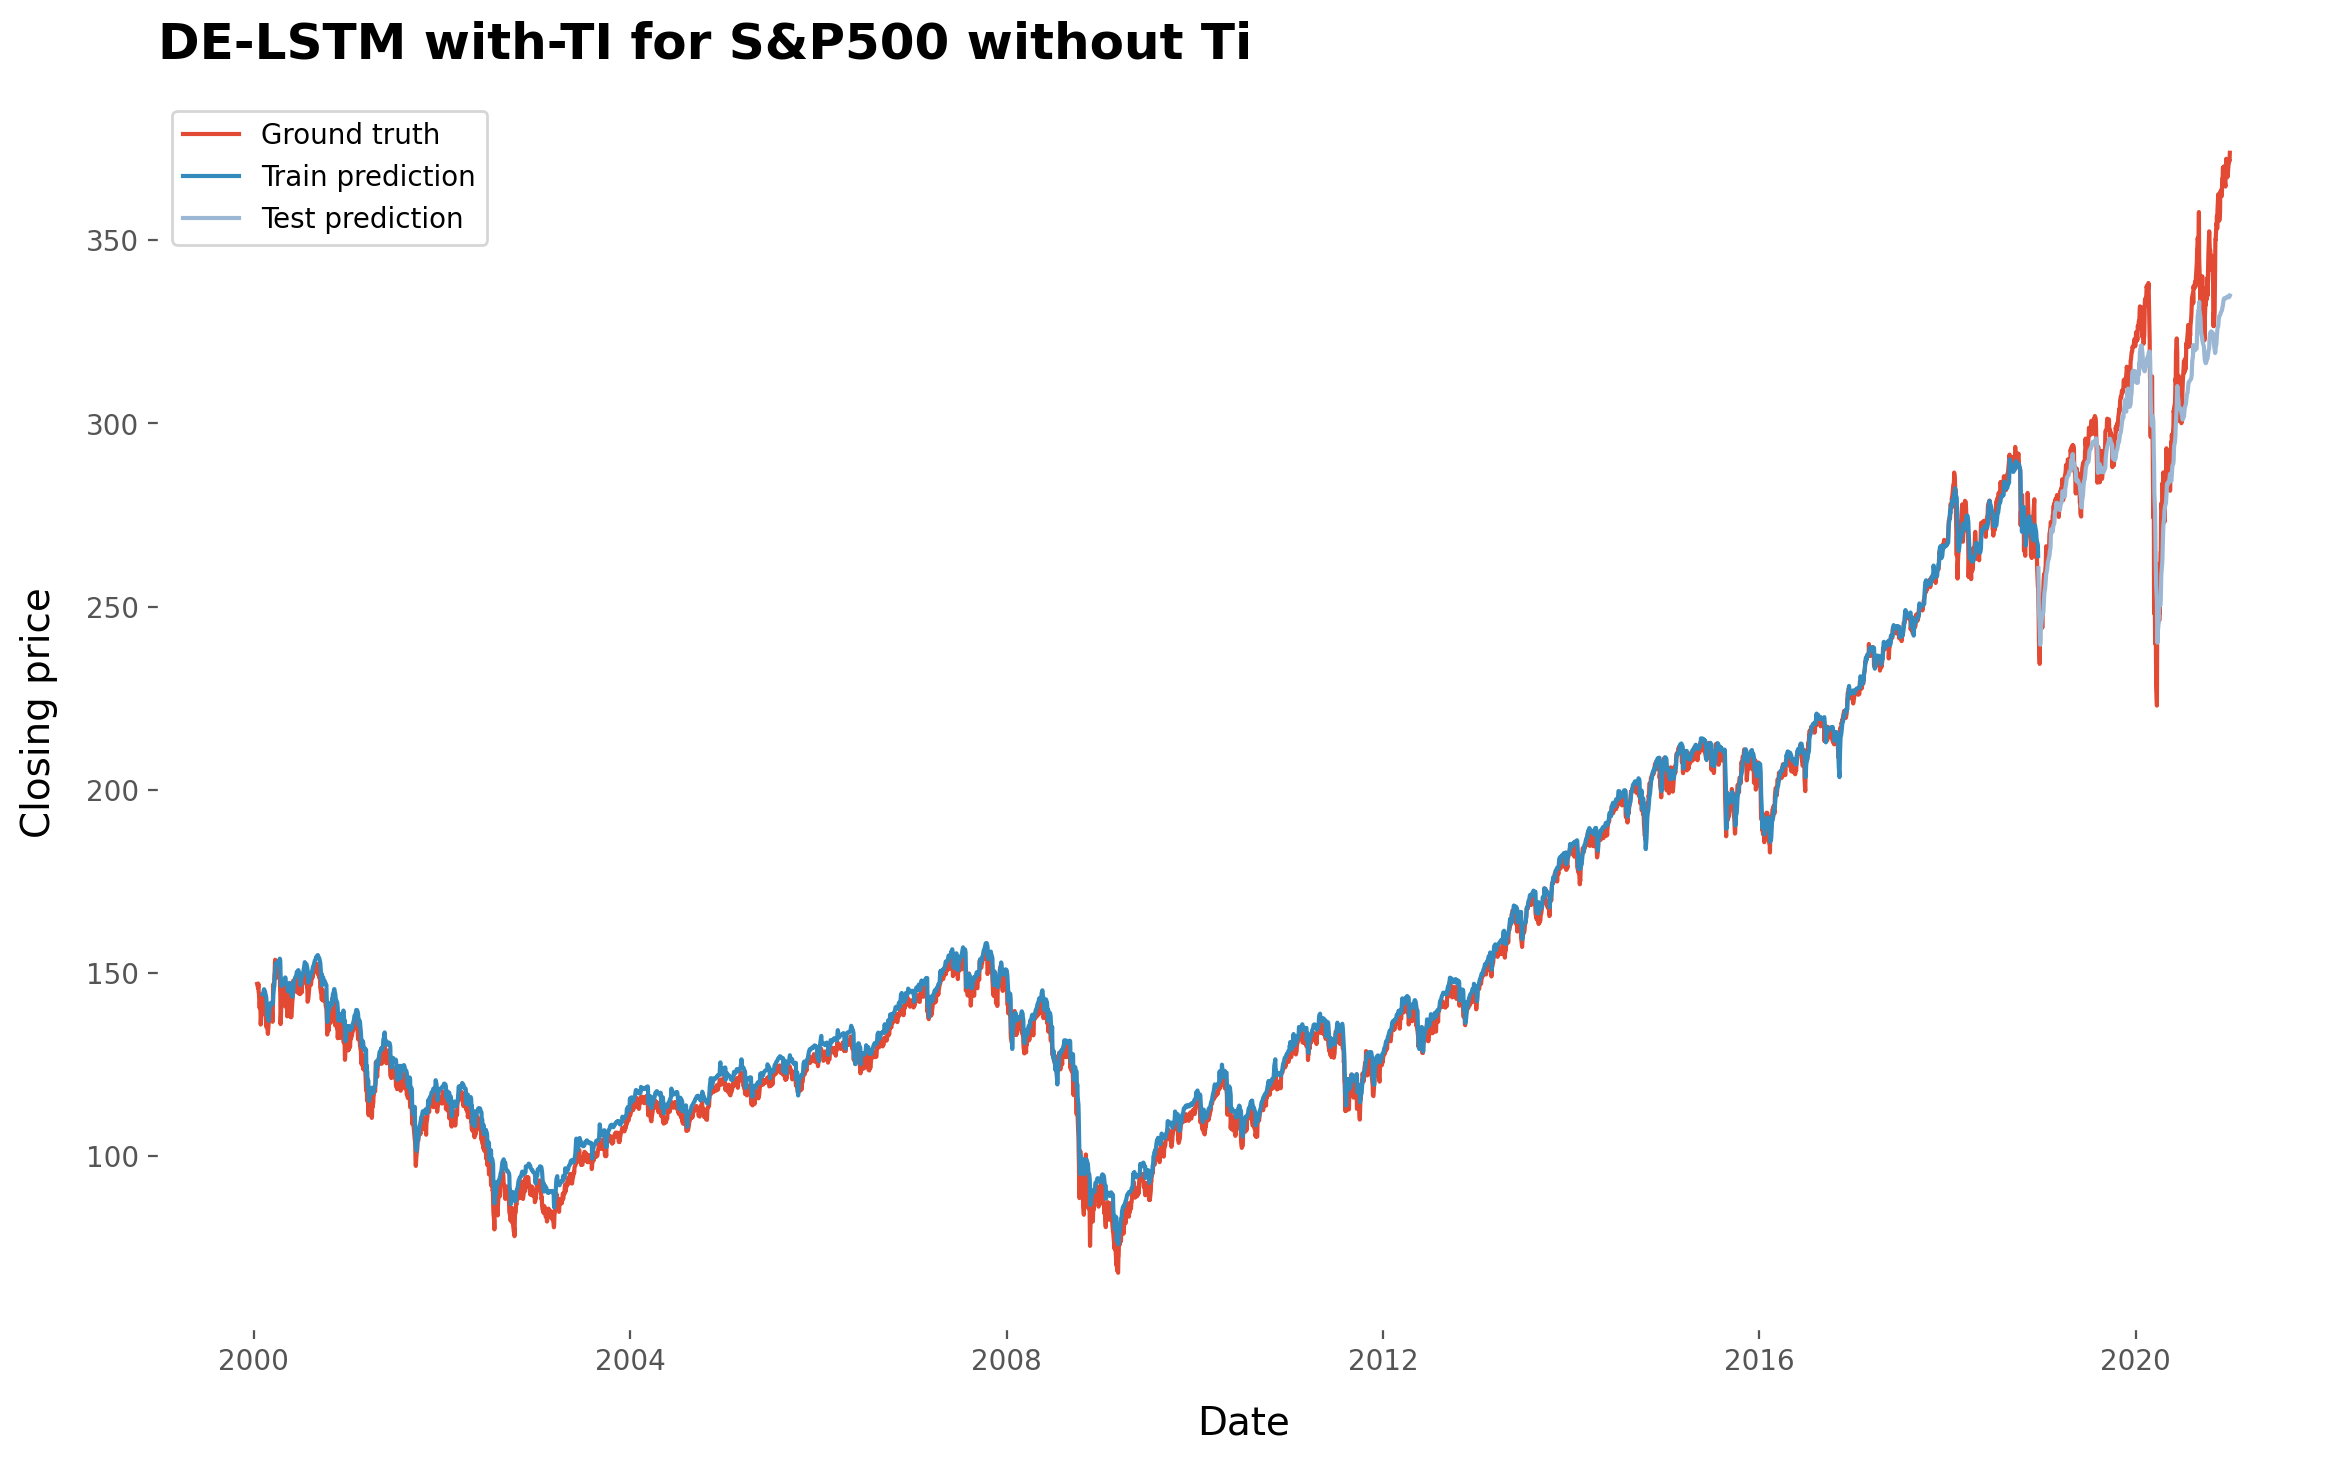

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(f'DE-LSTM with-TI for S&P500 without Ti', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth')
plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], y_pred_train_de_lstm_with.ravel(), label='Train prediction')
plt.plot(df.index[val_size+train_size+window_size-1:], y_pred_test_de_lstm_with.ravel(), label='Test prediction', color='#9BB7D4')

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

In [ ]:
ga_wo_ti_loss=[0.04331,0.1995,0.2001,0.3351,0.1266,0.1266,0.07949,0.07949,0.07949,0.04331]
ga_w_ti_loss=[0.04818,1.695,0.2002,0.2008,0.2008,0.05048,0.05048,0.04818,0.04818,0.04818]
pso_wo_ti_loss=[0.14750966429710388,0.14750966429710388,0.14750966429710388,0.11064554005861282,0.11064554005861282,0.05840890482068062,0.05840890482068062,0.05840890482068062,0.05840890482068062,0.03197423368692398]
pso_w_ti_loss=[0.07213332504034042,0.07213332504034042,0.07213332504034042,0.0358731672167778,0.0358731672167778,0.0358731672167778,0.0358731672167778,0.0358731672167778,0.0358731672167778,0.027650490403175354]
de_wo_ti_loss=[0.149717,0.0439371,0.0439371,0.0439371,0.0439371,0.0292733,0.0292733,0.0292733,0.0292733,0.0292733]
de_w_ti_loss=[0.0672641,0.0423762,0.0423762,0.0423762,0.0273821,0.0273821,0.0273821,0.0273821,0.0273821,0.0273821]

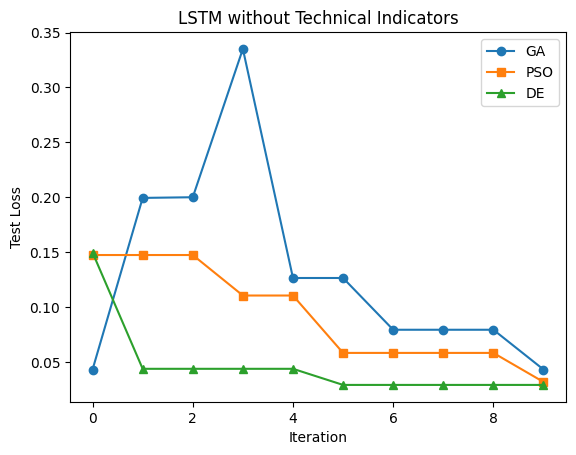

In [ ]:
import matplotlib.pyplot as plt

# Data
ga_wo_ti_loss = [0.04331, 0.1995, 0.2001, 0.3351, 0.1266, 0.1266, 0.07949, 0.07949, 0.07949, 0.04331]
pso_wo_ti_loss = [0.14750966429710388, 0.14750966429710388, 0.14750966429710388, 0.11064554005861282, 0.11064554005861282, 0.05840890482068062, 0.05840890482068062, 0.05840890482068062, 0.05840890482068062, 0.03197423368692398]
de_wo_ti_loss = [0.149717, 0.0439371, 0.0439371, 0.0439371, 0.0439371, 0.0292733, 0.0292733, 0.0292733, 0.0292733, 0.0292733]

# Method names
methods = ['Method 1', 'Method 2', 'Method 3']

# Plot
plt.plot(ga_wo_ti_loss, label='GA', marker='o')
plt.plot(pso_wo_ti_loss, label='PSO', marker='s')
plt.plot(de_wo_ti_loss, label='DE', marker='^')

# Labels and Title
plt.xlabel('Iteration')
plt.ylabel('Test Loss')
plt.title('LSTM without Technical Indicators')

# Legend
plt.legend()

# Show plot
plt.show()


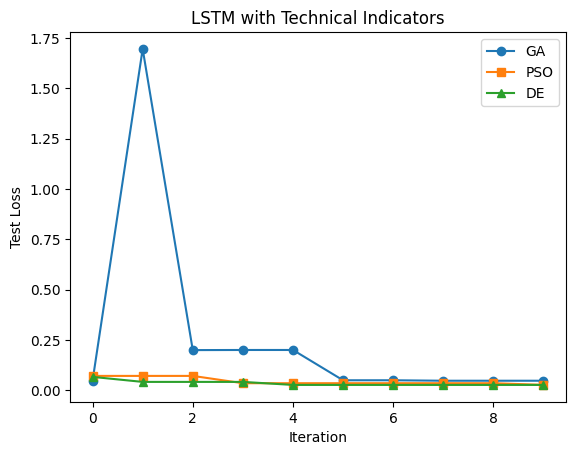

In [ ]:
import matplotlib.pyplot as plt

# Data
ga_w_ti_loss=[0.04818,1.695,0.2002,0.2008,0.2008,0.05048,0.05048,0.04818,0.04818,0.04818]
pso_w_ti_loss=[0.07213332504034042,0.07213332504034042,0.07213332504034042,0.0358731672167778,0.0358731672167778,0.0358731672167778,0.0358731672167778,0.0358731672167778,0.0358731672167778,0.027650490403175354]
de_w_ti_loss=[0.0672641,0.0423762,0.0423762,0.0423762,0.0273821,0.0273821,0.0273821,0.0273821,0.0273821,0.0273821]

# Method names
methods = ['Method 1', 'Method 2', 'Method 3']

# Plot
plt.plot(ga_w_ti_loss, label='GA', marker='o')
plt.plot(pso_w_ti_loss, label='PSO', marker='s')
plt.plot(de_w_ti_loss, label='DE', marker='^')

# Labels and Title
plt.xlabel('Iteration')
plt.ylabel('Test Loss')
plt.title('LSTM with Technical Indicators')

# Legend
plt.legend()

# Show plot
plt.show()
